# Data Leakage 문제 존재하면 shuffle 시켜도 나중에 Case랑 Date별로 다시 정렬시켜주는 코드 쓰면 됨

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 23.6 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=d9d13a80dd0b53a17d1d83e275b90ba556786eade85ae845a113623b1dae4730
  Stored in directory: /root/.cache/pip/wheels/fe/f6/cb/40331472edf4fd399b8cad02973c6acbdf26898342928327fe
Successfully built filterpy


In [194]:
import random
import pandas as pd
import numpy as np
import os
import glob
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from tqdm import tqdm

In [209]:
def preprocessing(input_path):
  all_input_list = sorted(glob.glob(input_path))
  train = pd.DataFrame()
  for datapath in all_input_list:
    data = pd.read_csv(datapath) # 이게 지금 28일치 * 24시
    data['obs_time'] = data.index % 24 # 시간통일
    print(data)
    data = abs(data)
    col_list = data.columns
    for i in range(0,len(col_list)):
      col = col_list[i]    
      if '누적' in col :
        data[col] = data.groupby((data.obs_time == 0).cumsum()).agg(col_list[i-1]).cumsum()
    data.to_csv(datapath,index=False)
    train = pd.concat([train,data])
  return train
input_path_train = '/content/drive/MyDrive/상추/original_data/train_input/*.csv'
input_path_test = '/content/drive/MyDrive/상추/original_data/test_input/*.csv'

preprocessing(input_path_train)
preprocessing(input_path_test)

     DAT  obs_time    내부온도관측치    내부습도관측치      co2관측치     ec관측치  시간당분무량  \
0      0         0  25.300000  81.835000  536.016667  1.407439     0.0   
1      0         1  25.680357  81.264286  528.696429  1.409003   126.0   
2      0         2  25.273333  81.471666  532.833333  1.406913     0.0   
3      0         3  25.355000  81.398334  545.566667  1.406689   126.0   
4      0         4  25.391667  81.483333  558.583333  1.411070     0.0   
..   ...       ...        ...        ...         ...       ...     ...   
667   27        19  30.880000  82.255000  464.433333  0.000000   252.0   
668   27        20  29.068333  82.506667  534.633333  0.000000   126.0   
669   27        21  28.246667  82.835000  563.433333  0.000000     0.0   
670   27        22  28.005000  82.850000  577.150000  0.000000   126.0   
671   27        23  27.868333  82.453333  588.616667  0.000000     0.0   

     일간누적분무량   시간당백색광량   일간누적백색광량  시간당적색광량   일간누적적색광량  시간당청색광량  일간누적청색광량  \
0       0.00      0.00       0.00  

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,2594.56,6.1882,146712.9397,0.0,22242.1668,0.0,10457.954,6.1882,179413.0605
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,2801.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605


In [210]:
train_input_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/train_input/*.csv'))
train_target_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/train_target/*.csv'))

test_input_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/test_input/*.csv'))
test_target_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/test_target/*.csv'))
def make_dataset(all_input_list, all_target_list):
    df_all = pd.DataFrame()
    length = len(all_input_list)
    for idx in range(length):
        X = pd.read_csv(all_input_list[idx])
        y = pd.read_csv(all_target_list[idx])
        y['DAT'] = y['DAT']-1
        df_concat = pd.merge(X, y, on='DAT', how='left')
        df_concat['Case'] = idx+1
        df_all = pd.concat([df_all, df_concat])
    return df_all

train = make_dataset(train_input_list, train_target_list)
test = make_dataset(test_input_list, test_target_list)

In [211]:
train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,predicted_weight_g,Case
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259,86.591508,28
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28


In [212]:
train['내부온도관측치'][train['내부온도관측치'] == 0] = train['내부온도관측치'].mean()

<ipython-input-212-a3a709d65087>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['내부온도관측치'][train['내부온도관측치'] == 0] = train['내부온도관측치'].mean()


In [213]:
train['내부습도관측치'][train['내부습도관측치'] == 0] = train['내부습도관측치'].mean()
train['내부습도관측치'][train['내부습도관측치'] == 0]

<ipython-input-213-e5bc6e872e71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['내부습도관측치'][train['내부습도관측치'] == 0] = train['내부습도관측치'].mean()


Series([], Name: 내부습도관측치, dtype: float64)

In [214]:
train['05시내부온도관측치누적'] = 0
train['19시내부온도관측치누적'] = 0
train['23시내부온도관측치누적'] = 0

train['05시내부습도관측치누적'] = 0
train['19시내부습도관측치누적'] = 0
train['23시내부습도관측치누적'] = 0

train['05시co2관측치누적'] = 0
train['19시co2관측치누적'] = 0
train['23시co2관측치누적'] = 0

train['05시ec관측치누적'] = 0
train['19시ec관측치누적'] = 0
train['23시ec관측치누적'] = 0

train['05시분무량누적'] = 0
train['19시분무량누적'] = 0
train['23시분무량누적'] = 0

train['05시백색광누적'] = 0
train['19시백색광누적'] = 0
train['23시백색광누적'] = 0

train['05시적색광누적'] = 0
train['19시적색광누적'] = 0
train['23시적색광누적'] = 0

train['05시청색광누적'] = 0
train['19시청색광누적'] = 0
train['23시청색광누적'] = 0

train['05시총광량누적'] = 0
train['19시총광량누적'] = 0
train['23시총광량누적'] = 0



test['05시내부온도관측치누적'] = 0
test['19시내부온도관측치누적'] = 0
test['23시내부온도관측치누적'] = 0

test['05시내부습도관측치누적'] = 0
test['19시내부습도관측치누적'] = 0
test['23시내부습도관측치누적'] = 0

test['05시co2관측치누적'] = 0
test['19시co2관측치누적'] = 0
test['23시co2관측치누적'] = 0

test['05시ec관측치누적'] = 0
test['19시ec관측치누적'] = 0
test['23시ec관측치누적'] = 0

test['05시분무량누적'] = 0
test['19시분무량누적'] = 0
test['23시분무량누적'] = 0

test['05시백색광누적'] = 0
test['19시백색광누적'] = 0
test['23시백색광누적'] = 0

test['05시적색광누적'] = 0
test['19시적색광누적'] = 0
test['23시적색광누적'] = 0

test['05시청색광누적'] = 0
test['19시청색광누적'] = 0
test['23시청색광누적'] = 0

test['05시총광량누적'] = 0
test['19시총광량누적'] = 0
test['23시총광량누적'] = 0

train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,...,0,0,0,0,0,0,0,0,0,0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0


In [215]:
train = train.drop(train.filter(regex='일간누적').columns, axis=1)
test = test.drop(test.filter(regex='일간누적').columns, axis=1)
train #관측치에 칼만필터 씌워볼까?

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
train_new = train
test_new = test

In [217]:
train['시간대'] = 0
train['시간대'][(train['obs_time'] >= 0) & (train['obs_time'] <= 5)] = 1
train['시간대'][(train['obs_time'] > 5) & (train['obs_time'] < 20)] = 2
train['시간대'][(train['obs_time'] >= 20) & (train['obs_time'] <= 23)] = 3

test['시간대'] = 0
test['시간대'][(test['obs_time'] >= 0) & (test['obs_time'] <= 5)] = 1
test['시간대'][(test['obs_time'] > 5) & (test['obs_time'] < 20)] = 2
test['시간대'][(test['obs_time'] >= 20) & (test['obs_time'] <= 23)] = 3

test

<ipython-input-217-cb022eb2c26f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] >= 0) & (train['obs_time'] <= 5)] = 1
<ipython-input-217-cb022eb2c26f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] > 5) & (train['obs_time'] < 20)] = 2
<ipython-input-217-cb022eb2c26f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] >= 20) & (train['obs_t

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,6.1882,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3


In [218]:
train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3


In [219]:

train['측정될수분량2'] = 0
for i in range(22,3361,24):
  s = train.iloc[i,6] + train.iloc[i+1,6] * ((train.iloc[i, 3] + train.iloc[i+1,3]) / 2)
  train.iloc[i, 41] = s


test['측정될수분량2'] = 0
for i in range(22,3361,24):
  s = test.iloc[i,6] + test.iloc[i+1,6] * ((test.iloc[i, 3] + test.iloc[i+1,3]) / 2)
  test.iloc[i, 41] = s
test


train['측정될수분량1'] = 0
for i in range(22,3361,24):
  s = train.iloc[i+1,6] * (train.iloc[i+1,3])
  train.iloc[i, 42] = s


test['측정될수분량1'] = 0
for i in range(22,3361,24):
  s = test.iloc[i+1,6] * (test.iloc[i+1,3])
  test.iloc[i, 42] = s
test



train['측정될수분량3'] = 0
for i in range(22,3361,24):
  s = (train.iloc[i,6] + train.iloc[i+1,6]) * ((train.iloc[i, 3] + train.iloc[i+1,3]) / 2)
  train.iloc[i, 43] = s


test['측정될수분량3'] = 0
for i in range(22,3361,24):
  s = (test.iloc[i,6] + test.iloc[i+1,6]) * ((test.iloc[i, 3] + test.iloc[i+1,3]) / 2)
  test.iloc[i, 43] = s
test

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대,측정될수분량2,측정될수분량1,측정될수분량3
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,6.1882,0.0,0.0,...,0,0,0,0,0,0,2,0.0,0.0,0.000000
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.000000
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.000000
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,126.0,0.0,7233.764995


In [220]:
train_x = train.drop(['predicted_weight_g'], axis = 1)
train_y = train['predicted_weight_g']
test_x = test.drop(['predicted_weight_g'], axis=1)

In [221]:
train_x = train_x.groupby(['DAT','Case','시간대']).sum().reset_index()
train_y_ready = train.groupby(['DAT','Case','시간대']).mean().reset_index()
test_x = test_x.groupby(['DAT','Case','시간대']).sum().reset_index()

In [222]:
train_x = train_x.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
train_y_ready = train_y_ready.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
test_x = test_x.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
train_x.drop(['index'], axis = 1, inplace=True)
test_x.drop(['index'], axis = 1, inplace=True)

In [223]:
x = train_x.groupby(['Case'])['내부온도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x.drop(['level_1'], axis = 1, inplace = True)
train_x['내부온도관측치'] = x

x2 = train_x.groupby(['Case'])['내부습도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x2.drop(['level_1'], axis = 1, inplace = True)
train_x['내부습도관측치'] = x2

x3 = train_x.groupby(['Case'])['co2관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x3.drop(['level_1'], axis = 1, inplace = True)
train_x['co2관측치'] = x3

x4 = train_x.groupby(['Case'])['ec관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x4.drop(['level_1'], axis = 1, inplace = True)
train_x['ec관측치'] = x4

x5 = train_x.groupby(['Case'])['시간당분무량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x5.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당분무량'] = x5

x6 = train_x.groupby(['Case'])['시간당백색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x6.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당백색광량'] = x6

x7 = train_x.groupby(['Case'])['시간당적색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x7.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당적색광량'] = x7

x8 = train_x.groupby(['Case'])['시간당청색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x8.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당청색광량'] = x8

x9 = train_x.groupby(['Case'])['시간당총광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x9.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당총광량'] = x9



t = test_x.groupby(['Case'])['내부온도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t.drop(['level_1'], axis = 1, inplace = True)
test_x['내부온도관측치'] = t

t2 = test_x.groupby(['Case'])['내부습도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t2.drop(['level_1'], axis = 1, inplace = True)
test_x['내부습도관측치'] = t2

t3 = test_x.groupby(['Case'])['co2관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t3.drop(['level_1'], axis = 1, inplace = True)
test_x['co2관측치'] = t3

t4 = test_x.groupby(['Case'])['ec관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t4.drop(['level_1'], axis = 1, inplace = True)
test_x['ec관측치'] = t4

t5 = test_x.groupby(['Case'])['시간당분무량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t5.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당분무량'] = t5

t6 = test_x.groupby(['Case'])['시간당백색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t6.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당백색광량'] = t6

t7 = test_x.groupby(['Case'])['시간당적색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t7.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당적색광량'] = t7

t8 = test_x.groupby(['Case'])['시간당청색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t8.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당청색광량'] = t8

t9 = test_x.groupby(['Case'])['시간당총광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t9.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당총광량'] = t9
test_x

,DAT,Case,시간대,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,...,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,측정될수분량2,측정될수분량1,측정될수분량3
0,0,1,1,15,157.490197,360.230509,2828.300000,6.198982,2307.00,0.000000e+00,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
1,0,1,2,175,551.546862,1200.858842,9320.750000,20.733929,10708.13,2.094768e+05,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
2,0,1,3,86,659.753530,1472.930508,11177.350000,24.897336,12246.13,2.094768e+05,...,0,0,0,0,0,0,0,53287.214088,53776.170332,53287.214088
3,1,1,1,15,823.168133,1894.221383,13990.538136,31.151334,13784.13,2.094768e+05,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,1,1,2,175,1237.346465,2748.433049,20432.738136,45.598078,20692.27,4.189937e+05,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,26,5,2,175,18064.448119,34045.100123,298129.376915,138.152084,82523.29,4.830401e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
416,26,5,3,86,18167.036452,34274.596790,300117.860248,141.815671,82649.29,4.830401e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
417,27,5,1,15,18309.500067,34618.675321,302802.869570,147.366055,83027.29,4.830401e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
418,27,5,2,175,18669.410066,35426.903655,308281.619570,160.379524,85243.85,4.977114e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000


In [224]:
train_new_x = train_new.drop(['predicted_weight_g'], axis = 1)
train_new_y = train_new['predicted_weight_g']
test_new_x = test_new.drop(['predicted_weight_g'], axis=1)

In [225]:
train_new_x = train_new_x.groupby(['DAT','Case']).sum().reset_index()
train_new_y_ready = train_new.groupby(['DAT','Case']).mean().reset_index()
test_new_x = test_new_x.groupby(['DAT','Case']).sum().reset_index()

In [226]:
train_new_x = train_new_x.sort_values(by=['Case','DAT'], axis=0).reset_index()
train_new_y_ready = train_new_y_ready.sort_values(by=['Case','DAT',], axis=0).reset_index()
test_new_x = test_new_x.sort_values(by=['Case','DAT'], axis=0).reset_index()
train_new_x.drop(['index'], axis = 1, inplace=True)
test_new_x.drop(['index'], axis = 1, inplace=True)

In [227]:
for i in range(784):
  #온도
  train_new_x.iloc[i,12] = train_x.iloc[0 + (3*i),4]
  train_new_x.iloc[i,13] = train_x.iloc[1 + (3*i),4]
  train_new_x.iloc[i,14] = train_x.iloc[2 + (3*i),4]
  #습도
  train_new_x.iloc[i,15] = train_x.iloc[0 + (3*i),5]
  train_new_x.iloc[i,16] = train_x.iloc[1 + (3*i),5]
  train_new_x.iloc[i,17] = train_x.iloc[2 + (3*i),5]
  #co2
  train_new_x.iloc[i,18] = train_x.iloc[0 + (3*i),6]
  train_new_x.iloc[i,19] = train_x.iloc[1 + (3*i),6]
  train_new_x.iloc[i,20] = train_x.iloc[2 + (3*i),6]
  #ec
  train_new_x.iloc[i,21] = train_x.iloc[0 + (3*i),7]
  train_new_x.iloc[i,22] = train_x.iloc[1 + (3*i),7]
  train_new_x.iloc[i,23] = train_x.iloc[2 + (3*i),7]
  #분무
  train_new_x.iloc[i,24] = train_x.iloc[0 + (3*i),8]
  train_new_x.iloc[i,25] = train_x.iloc[1 + (3*i),8]
  train_new_x.iloc[i,26] = train_x.iloc[2 + (3*i),8]
  #백색
  train_new_x.iloc[i,27] = train_x.iloc[0 + (3*i),9]
  train_new_x.iloc[i,28] = train_x.iloc[1 + (3*i),9]
  train_new_x.iloc[i,29] = train_x.iloc[2 + (3*i),9]
  #적색
  train_new_x.iloc[i,30] = train_x.iloc[0 + (3*i),10]
  train_new_x.iloc[i,31] = train_x.iloc[1 + (3*i),10]
  train_new_x.iloc[i,32] = train_x.iloc[2 + (3*i),10]
  #청색
  train_new_x.iloc[i,33] = train_x.iloc[0 + (3*i),11]
  train_new_x.iloc[i,34] = train_x.iloc[1 + (3*i),11]
  train_new_x.iloc[i,35] = train_x.iloc[2 + (3*i),11]
  #총광
  train_new_x.iloc[i,36] = train_x.iloc[0 + (3*i),12]
  train_new_x.iloc[i,37] = train_x.iloc[1 + (3*i),12]
  train_new_x.iloc[i,38] = train_x.iloc[2 + (3*i),12]

for i in range(len(test_new_x)):
  #온도
  test_new_x.iloc[i,12] = test_x.iloc[0 + (3*i),4]
  test_new_x.iloc[i,13] = test_x.iloc[1 + (3*i),4]
  test_new_x.iloc[i,14] = test_x.iloc[2 + (3*i),4]
  #습도
  test_new_x.iloc[i,15] = test_x.iloc[0 + (3*i),5]
  test_new_x.iloc[i,16] = test_x.iloc[1 + (3*i),5]
  test_new_x.iloc[i,17] = test_x.iloc[2 + (3*i),5]
  #co2
  test_new_x.iloc[i,18] = test_x.iloc[0 + (3*i),6]
  test_new_x.iloc[i,19] = test_x.iloc[1 + (3*i),6]
  test_new_x.iloc[i,20] = test_x.iloc[2 + (3*i),6]
  #ec
  test_new_x.iloc[i,21] = test_x.iloc[0 + (3*i),7]
  test_new_x.iloc[i,22] = test_x.iloc[1 + (3*i),7]
  test_new_x.iloc[i,23] = test_x.iloc[2 + (3*i),7]
  #분무
  test_new_x.iloc[i,24] = test_x.iloc[0 + (3*i),8]
  test_new_x.iloc[i,25] = test_x.iloc[1 + (3*i),8]
  test_new_x.iloc[i,26] = test_x.iloc[2 + (3*i),8]
  #백색
  test_new_x.iloc[i,27] = test_x.iloc[0 + (3*i),9]
  test_new_x.iloc[i,28] = test_x.iloc[1 + (3*i),9]
  test_new_x.iloc[i,29] = test_x.iloc[2 + (3*i),9]
  #적색
  test_new_x.iloc[i,30] = test_x.iloc[0 + (3*i),10]
  test_new_x.iloc[i,31] = test_x.iloc[1 + (3*i),10]
  test_new_x.iloc[i,32] = test_x.iloc[2 + (3*i),10]
  #청색
  test_new_x.iloc[i,33] = test_x.iloc[0 + (3*i),11]
  test_new_x.iloc[i,34] = test_x.iloc[1 + (3*i),11]
  test_new_x.iloc[i,35] = test_x.iloc[2 + (3*i),11]
  #총광
  test_new_x.iloc[i,36] = test_x.iloc[0 + (3*i),12]
  test_new_x.iloc[i,37] = test_x.iloc[1 + (3*i),12]
  test_new_x.iloc[i,38] = test_x.iloc[2 + (3*i),12]
test_new_x

,DAT,Case,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,...,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대,측정될수분량2,측정될수분량1,측정될수분량3
0,0,1,276,659.753530,1472.930508,11177.350000,24.897336,12246.13,209476.7582,0.0000,...,0.000,0.000,0.000,0.000000e+00,2.094768e+05,2.094768e+05,46,53287.214088,53776.170332,53287.214088
1,1,1,276,688.051268,1515.552541,11127.871469,24.828015,9215.14,209516.9815,0.0000,...,0.000,0.000,0.000,2.094768e+05,4.189937e+05,4.189937e+05,46,769.000000,0.000000,46255.350024
2,2,1,276,681.777709,1465.085341,11733.194068,24.794710,11911.77,209625.2750,0.0000,...,0.000,0.000,0.000,4.189937e+05,6.286190e+05,6.286190e+05,46,389.630000,0.000000,24671.696329
3,3,1,276,675.930000,1544.551663,11865.466667,24.811042,12297.57,209588.1458,0.0000,...,0.000,0.000,0.000,6.286190e+05,8.382072e+05,8.382072e+05,46,53630.059726,53435.246823,53630.059726
4,4,1,276,655.253275,1603.898332,12680.383333,24.931104,8874.35,209628.3691,0.0000,...,0.000,0.000,0.000,8.382072e+05,1.047836e+06,1.047836e+06,46,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,276,621.237343,1360.970960,11056.883333,5.876635,3198.84,146685.0928,22270.2984,...,87742.798,98213.284,98213.284,4.518548e+06,4.697974e+06,4.697974e+06,46,119.570000,0.000000,6792.871341
136,24,5,276,610.544249,1367.500518,10527.803448,21.898880,3250.28,146233.3542,22192.5228,...,98213.284,108649.307,108649.307,4.697974e+06,4.876835e+06,4.876835e+06,46,7218.014999,7205.309989,7218.014999
137,25,5,276,600.999883,1375.736610,10654.514124,21.982178,2733.42,146647.9636,22248.7860,...,108649.307,119110.394,119110.394,4.876835e+06,5.056193e+06,5.056193e+06,46,7191.450008,7126.139987,7191.450008
138,26,5,276,614.828333,1369.153332,10744.616667,22.039573,2985.42,146579.8934,22253.7504,...,119110.394,129568.348,129568.348,5.056193e+06,5.235485e+06,5.235485e+06,46,0.000000,0.000000,0.000000


In [228]:
train_new_y = train_new_y_ready['predicted_weight_g']
train_new_y

0       0.167719
1       0.181787
2       0.265921
3       0.423650
4       0.475272
         ...    
779    64.875499
780    74.002614
781    76.342275
782    82.621245
783    86.591508
Name: predicted_weight_g, Length: 784, dtype: float64

In [229]:
train_new_x.drop(['obs_time','시간대','내부온도관측치','내부습도관측치','co2관측치','ec관측치'], axis = 1, inplace = True)
test_new_x.drop(['obs_time','시간대','내부온도관측치','내부습도관측치','co2관측치','ec관측치'], axis = 1, inplace = True)

In [230]:
train_x = train_new_x
train_y = train_new_y
test_x = test_new_x

In [231]:
train_x = train_x.drop(train_x.filter(regex='시간당').columns, axis=1)
test_x = test_x.drop(test_x.filter(regex='시간당').columns, axis=1)


In [232]:
check = pd.concat([train_x,train_y],axis=1)
z = check[(check['DAT'] == 0) | (check['DAT'] == 27)]
for idx,i in enumerate(z.columns):
  if((i == 'DAT') | (i == 'predicted_weight_g') | (i == 'Case')):
    continue
  z.drop([i],axis=1,inplace = True)
z

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,DAT,Case,predicted_weight_g
0,0,1,0.167719
27,27,1,82.251627
28,0,2,1.051178
55,27,2,65.505384
56,0,3,0.685391
83,27,3,44.324891
84,0,4,1.656917
111,27,4,128.563772
112,0,5,4.223077
139,27,5,150.635598


In [233]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           784 non-null    int64  
 1   Case          784 non-null    int64  
 2   05시내부온도관측치누적  784 non-null    float64
 3   19시내부온도관측치누적  784 non-null    float64
 4   23시내부온도관측치누적  784 non-null    float64
 5   05시내부습도관측치누적  784 non-null    float64
 6   19시내부습도관측치누적  784 non-null    float64
 7   23시내부습도관측치누적  784 non-null    float64
 8   05시co2관측치누적   784 non-null    float64
 9   19시co2관측치누적   784 non-null    float64
 10  23시co2관측치누적   784 non-null    float64
 11  05시ec관측치누적    784 non-null    float64
 12  19시ec관측치누적    784 non-null    float64
 13  23시ec관측치누적    784 non-null    float64
 14  05시분무량누적      784 non-null    float64
 15  19시분무량누적      784 non-null    float64
 16  23시분무량누적      784 non-null    float64
 17  05시백색광누적      784 non-null    float64
 18  19시백색광누적      784 non-null    

In [234]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           140 non-null    int64  
 1   Case          140 non-null    int64  
 2   05시내부온도관측치누적  140 non-null    float64
 3   19시내부온도관측치누적  140 non-null    float64
 4   23시내부온도관측치누적  140 non-null    float64
 5   05시내부습도관측치누적  140 non-null    float64
 6   19시내부습도관측치누적  140 non-null    float64
 7   23시내부습도관측치누적  140 non-null    float64
 8   05시co2관측치누적   140 non-null    float64
 9   19시co2관측치누적   140 non-null    float64
 10  23시co2관측치누적   140 non-null    float64
 11  05시ec관측치누적    140 non-null    float64
 12  19시ec관측치누적    140 non-null    float64
 13  23시ec관측치누적    140 non-null    float64
 14  05시분무량누적      140 non-null    float64
 15  19시분무량누적      140 non-null    float64
 16  23시분무량누적      140 non-null    float64
 17  05시백색광누적      140 non-null    float64
 18  19시백색광누적      140 non-null    

In [235]:
train_x['하루평균온도'] = (train_x['05시내부온도관측치누적'] + train_x['19시내부온도관측치누적'] + train_x['23시내부온도관측치누적']) / 3
train_x['하루평균습도'] = (train_x['05시내부습도관측치누적'] + train_x['19시내부습도관측치누적'] + train_x['23시내부습도관측치누적']) / 3
train_x['하루평균co2'] = (train_x['05시co2관측치누적'] + train_x['19시co2관측치누적'] + train_x['23시co2관측치누적']) / 3
train_x['하루평균ec'] = (train_x['05시ec관측치누적'] + train_x['19시ec관측치누적'] + train_x['23시ec관측치누적']) / 3
train_x['하루평균분무량'] = (train_x['05시분무량누적'] + train_x['19시분무량누적'] + train_x['23시분무량누적']) / 3
train_x['하루평균백색광'] = (train_x['05시백색광누적'] + train_x['19시백색광누적'] + train_x['23시백색광누적']) / 3
train_x['하루평균적색광'] = (train_x['05시적색광누적'] + train_x['19시적색광누적'] + train_x['23시적색광누적']) / 3
train_x['하루평균청색광'] = (train_x['05시청색광누적'] + train_x['19시청색광누적'] + train_x['23시청색광누적']) / 3
train_x['하루평균총광량'] = (train_x['05시총광량누적'] + train_x['19시총광량누적'] + train_x['23시총광량누적']) / 3


test_x['하루평균온도'] = (test_x['05시내부온도관측치누적'] + test_x['19시내부온도관측치누적'] + test_x['23시내부온도관측치누적']) / 3
test_x['하루평균습도'] = (test_x['05시내부습도관측치누적'] + test_x['19시내부습도관측치누적'] + test_x['23시내부습도관측치누적']) / 3
test_x['하루평균co2'] = (test_x['05시co2관측치누적'] + test_x['19시co2관측치누적'] + test_x['23시co2관측치누적']) / 3
test_x['하루평균ec'] = (test_x['05시ec관측치누적'] + test_x['19시ec관측치누적'] + test_x['23시ec관측치누적']) / 3
test_x['하루평균분무량'] = (test_x['05시분무량누적'] + test_x['19시분무량누적'] + test_x['23시분무량누적']) / 3
test_x['하루평균백색광'] = (test_x['05시백색광누적'] + test_x['19시백색광누적'] + test_x['23시백색광누적']) / 3
test_x['하루평균적색광'] = (test_x['05시적색광누적'] + test_x['19시적색광누적'] + test_x['23시적색광누적']) / 3
test_x['하루평균청색광'] = (test_x['05시청색광누적'] + test_x['19시청색광누적'] + test_x['23시청색광누적']) / 3
test_x['하루평균총광량'] = (test_x['05시총광량누적'] + test_x['19시총광량누적'] + test_x['23시총광량누적']) / 3
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,측정될수분량3,하루평균온도,하루평균습도,하루평균co2,하루평균ec,하루평균분무량,하루평균백색광,하루평균적색광,하루평균청색광,하루평균총광량
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,53287.214088,456.263530,1011.339953,7775.466667,17.276749,8420.420000,1.396512e+05,0.0000,0.000000,1.396512e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,46255.350024,1136.106465,2543.712494,18909.499247,42.158254,18645.890000,3.491547e+05,0.0000,0.000000,3.491547e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,24671.696329,1821.706952,4008.123946,30455.271092,66.944550,29785.240000,5.587439e+05,0.0000,0.000000,5.587439e+05
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,53630.059726,2498.107506,5523.282831,42255.565537,91.756953,41827.753333,7.683444e+05,0.0000,0.000000,7.683444e+05
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,0.000000,3160.903024,7113.847275,54720.137759,116.639399,52099.510000,9.779594e+05,0.0000,0.000000,9.779594e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,6792.871341,16148.948989,29746.767441,264713.876009,72.759171,72598.886667,4.342044e+06,201397.4340,94723.122000,4.638165e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,7218.014999,16765.109349,31111.669626,275472.668346,91.090874,75847.023333,4.488428e+06,223615.8820,105170.632667,4.817215e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,7191.450008,17367.649232,32483.939569,286040.176915,113.032090,78792.586667,4.634938e+06,245845.9136,115623.365000,4.996407e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,0.000000,17975.257008,33856.157346,296786.510248,135.085656,81654.150000,4.781541e+06,268098.0092,126082.363333,5.175721e+06


In [236]:
train_x = train_x.drop(train_x.filter(regex = '총광').columns, axis =1)
test_x = test_x.drop(test_x.filter(regex = '총광').columns, axis =1)


train_x['ec_x_분무05'] = (train_x['05시ec관측치누적']+1) * (train_x['05시분무량누적']+1)
train_x['ec_x_분무19'] = (train_x['19시ec관측치누적']+1) * (train_x['19시분무량누적']+1)
train_x['ec_x_분무23'] = (train_x['23시ec관측치누적']+1) * (train_x['23시분무량누적']+1)
train_x['ec_x_분무평균'] = (train_x['하루평균ec']+1) * (train_x['하루평균분무량']+1)

test_x['ec_x_분무05'] = (test_x['05시ec관측치누적']+1) * (test_x['05시분무량누적']+1)
test_x['ec_x_분무19'] = (test_x['19시ec관측치누적']+1) * (test_x['19시분무량누적']+1)
test_x['ec_x_분무23'] = (test_x['23시ec관측치누적']+1) * (test_x['23시분무량누적']+1)
test_x['ec_x_분무평균'] = (test_x['하루평균ec']+1) * (test_x['하루평균분무량']+1)



train_x['적색_+_청색05'] = (train_x['05시적색광누적']) + (train_x['05시청색광누적'])
train_x['적색_+_청색19'] = (train_x['19시적색광누적']) + (train_x['19시청색광누적'])
train_x['적색_+_청색23'] = (train_x['23시적색광누적']) + (train_x['23시청색광누적'])
train_x['적색_+_청색평균'] = (train_x['하루평균적색광']) + (train_x['하루평균청색광'])

test_x['적색_+_청색05'] = (test_x['05시적색광누적']) + (test_x['05시청색광누적'])
test_x['적색_+_청색19'] = (test_x['19시적색광누적']) + (test_x['19시청색광누적'])
test_x['적색_+_청색23'] = (test_x['23시적색광누적']) + (test_x['23시청색광누적'])
test_x['적색_+_청색평균'] = (test_x['하루평균적색광']) + (test_x['하루평균청색광'])


In [237]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           784 non-null    int64  
 1   Case          784 non-null    int64  
 2   05시내부온도관측치누적  784 non-null    float64
 3   19시내부온도관측치누적  784 non-null    float64
 4   23시내부온도관측치누적  784 non-null    float64
 5   05시내부습도관측치누적  784 non-null    float64
 6   19시내부습도관측치누적  784 non-null    float64
 7   23시내부습도관측치누적  784 non-null    float64
 8   05시co2관측치누적   784 non-null    float64
 9   19시co2관측치누적   784 non-null    float64
 10  23시co2관측치누적   784 non-null    float64
 11  05시ec관측치누적    784 non-null    float64
 12  19시ec관측치누적    784 non-null    float64
 13  23시ec관측치누적    784 non-null    float64
 14  05시분무량누적      784 non-null    float64
 15  19시분무량누적      784 non-null    float64
 16  23시분무량누적      784 non-null    float64
 17  05시백색광누적      784 non-null    float64
 18  19시백색광누적      784 non-null    

In [238]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           140 non-null    int64  
 1   Case          140 non-null    int64  
 2   05시내부온도관측치누적  140 non-null    float64
 3   19시내부온도관측치누적  140 non-null    float64
 4   23시내부온도관측치누적  140 non-null    float64
 5   05시내부습도관측치누적  140 non-null    float64
 6   19시내부습도관측치누적  140 non-null    float64
 7   23시내부습도관측치누적  140 non-null    float64
 8   05시co2관측치누적   140 non-null    float64
 9   19시co2관측치누적   140 non-null    float64
 10  23시co2관측치누적   140 non-null    float64
 11  05시ec관측치누적    140 non-null    float64
 12  19시ec관측치누적    140 non-null    float64
 13  23시ec관측치누적    140 non-null    float64
 14  05시분무량누적      140 non-null    float64
 15  19시분무량누적      140 non-null    float64
 16  23시분무량누적      140 non-null    float64
 17  05시백색광누적      140 non-null    float64
 18  19시백색광누적      140 non-null    

In [239]:
train_x.drop(train_x.filter(regex = '백색'), axis = 1, inplace=True)
test_x.drop(test_x.filter(regex = '백색'), axis = 1, inplace=True)

train_x.drop(train_x.filter(regex = '청색'), axis = 1, inplace=True)
test_x.drop(test_x.filter(regex = '청색'), axis = 1, inplace=True)

In [240]:
train_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,하루평균온도,하루평균습도,하루평균co2,하루평균ec,하루평균분무량,하루평균적색광,ec_x_분무05,ec_x_분무19,ec_x_분무23,ec_x_분무평균
0,0,1,152.375357,543.497022,648.737022,488.959286,1548.437616,1873.470950,3273.179762,10802.813095,...,448.203134,1303.622617,8972.751984,23.270043,2682.846667,9116.8448,3.521074e+03,1.074594e+05,1.364875e+05,6.513707e+04
1,1,1,802.423055,1203.154720,1309.763053,2363.573595,3423.836927,3747.271928,16105.807923,23392.424589,...,1105.113609,3178.227483,21638.724589,56.546059,6659.120000,22818.5888,1.858032e+05,4.784304e+05,5.375161e+05,3.832637e+05
2,2,1,1465.109946,1846.319946,1950.046613,4235.789751,5287.029753,5609.433087,28612.826002,36268.142669,...,1753.825502,5044.084197,34413.526002,89.881512,10712.963333,36507.0944,6.320298e+05,1.126382e+06,1.216881e+06,9.737012e+05
3,3,1,2102.321331,2476.117657,2577.822656,6094.882606,7142.959272,7466.219273,41656.083912,53215.550578,...,2385.420548,6901.353717,50491.617245,123.452354,14733.380000,50202.2192,1.359387e+06,2.036533e+06,2.157985e+06,1.833728e+06
4,4,1,2730.360368,3112.468700,3214.372034,7955.275545,9016.890547,9341.378879,59940.042104,67442.975437,...,3019.067034,8771.181657,65645.030992,157.143396,18641.933333,63895.1376,2.328741e+06,3.209621e+06,3.360449e+06,2.948257e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,23,28,16924.798611,17314.583610,17410.510277,32531.546176,33353.864510,33585.191177,274662.719060,280926.952393,...,17216.630833,33156.867288,279457.941282,581.940200,357467.726667,108869.8436,1.970806e+08,2.132453e+08,2.150474e+08,2.083829e+08
780,24,28,17552.605851,17919.984185,18016.789185,33938.389108,34789.454108,35024.420775,285424.226531,291661.038678,...,17829.793074,34584.087997,290234.534629,610.356669,365772.813333,128048.4240,2.178648e+08,2.255612e+08,2.274649e+08,2.236183e+08
781,25,28,18161.116713,18518.971712,18614.863378,35378.022844,36231.462844,36470.189510,296363.720287,302643.803620,...,18431.650601,36026.558399,301217.131398,638.951950,368854.636667,150374.9856,2.303067e+08,2.379806e+08,2.398952e+08,2.360499e+08
782,26,28,18758.823379,19115.493377,19226.358377,36825.764510,37675.707843,37913.426176,307403.486954,313160.003620,...,19033.558378,37471.632843,311834.153620,667.246668,371617.196667,172659.6256,2.427676e+08,2.501907e+08,2.520665e+08,2.483326e+08


In [241]:
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,하루평균온도,하루평균습도,하루평균co2,하루평균ec,하루평균분무량,하루평균적색광,ec_x_분무05,ec_x_분무19,ec_x_분무23,ec_x_분무평균
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,456.263530,1011.339953,7775.466667,17.276749,8420.420000,0.0000,1.661525e+04,2.327515e+05,3.171680e+05,1.539162e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,1136.106465,2543.712494,18909.499247,42.158254,18645.890000,0.0000,4.432103e+05,9.642666e+05,1.088681e+06,8.047672e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,1821.706952,4008.123946,30455.271092,66.944550,29785.240000,0.0000,1.353080e+06,2.299793e+06,2.520410e+06,2.023813e+06
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,2498.107506,5523.282831,42255.565537,91.756953,41827.753333,0.0000,2.916614e+06,4.245585e+06,4.582283e+06,3.879908e+06
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,3160.903024,7113.847275,54720.137759,116.639399,52099.510000,0.0000,5.111651e+06,6.513238e+06,6.832547e+06,6.129073e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,16148.948989,29746.767441,264713.876009,72.759171,72598.886667,201397.4340,5.019786e+06,5.387534e+06,5.665717e+06,5.354907e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,16765.109349,31111.669626,275472.668346,91.090874,75847.023333,223615.8820,6.085622e+06,7.297294e+06,7.600360e+06,6.984911e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,17367.649232,32483.939569,286040.176915,113.032090,78792.586667,245845.9136,8.043660e+06,9.313736e+06,9.621612e+06,8.984997e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,17975.257008,33856.157346,296786.510248,135.085656,81654.150000,268098.0092,1.007673e+07,1.148343e+07,1.180376e+07,1.111209e+07


In [242]:
basic_col = train_x.columns
kal_train = train_x

for i in range(2,34):
  train_x['kf_X_'+str(i)]=0

for j in range(1,29):
  kal = train_x[train_x['Case'] == j]
  for i in tqdm(range(len(basic_col))):
      if((i == 0) | (i == 1)):
        continue
      current=0
      if(i == 0):
        break
      sum_c=[]
      z = kal.loc[:, kal.columns[i]]
      a = []           #필터링 된 피쳐(after)
      b = []           #필터링 전 피쳐(before)
      my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
      my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
      my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
      my_filter.H = np.array([[1.,0.]])    # Measurement function
      my_filter.P *= 1000.                 # covariance matrix
      my_filter.R = 5                      # state uncertainty
      my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
      for k in z.values:
          my_filter.predict()
          my_filter.update(k)
          # do something with the output
          x = my_filter.x
          a.extend(x[0])
          b.append(k)
      sum_c=sum_c+a
      #train_x.loc[(j+0)*24:(j+1)*24+1,'kf_X_'+str(i)]=sum_c
      print(sum_c)
      train_x['kf_X_'+str(i)][train_x['Case'] == j] = sum_c

train_x

basic_col = test_x.columns
kal_test = test_x

for i in range(2,34):
  test_x['kf_X_'+str(i)]=0

for j in range(1,6): #수정 Data_Leakage
  kal = test_x[test_x['Case'] == j]
  for i in tqdm(range(len(basic_col))):
      if((i == 0) | (i == 1)):
        continue
      current=0
      sum_c=[]
      z = kal.loc[:, kal.columns[i]]
      a = []           #필터링 된 피쳐(after)
      b = []           #필터링 전 피쳐(before)
      my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
      my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
      my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
      my_filter.H = np.array([[1.,0.]])    # Measurement function
      my_filter.P *= 1000.                 # covariance matrix
      my_filter.R = 5                      # state uncertainty
      my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
      for k in z.values:
          my_filter.predict()
          my_filter.update(k)
          # do something with the output
          x = my_filter.x
          a.extend(x[0])
          b.append(k)
      sum_c=sum_c+a
      test_x['kf_X_'+str(i)][test_x['Case'] == j] = sum_c

#fillna도 해줘야함


  0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-242-adade0d04c3f>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['kf_X_'+str(i)][train_x['Case'] == j] = sum_c
100%|██████████| 33/33 [00:00<00:00, 256.77it/s]


[152.00035640944512, 796.8496630990326, 1459.7096071431981, 2105.226471553372, 2740.076130277208, 3376.817828589704, 4013.5198891315026, 4651.123249175116, 5288.115581605644, 5917.926378045451, 6543.233875628347, 7164.969466098377, 7784.481718558382, 8400.722639160913, 9016.928929922326, 9632.158544777412, 10245.494986771315, 10857.556360577024, 11468.98292976228, 12079.63905326224, 12702.18012813803, 13334.091335073312, 13972.81556660472, 14615.731577855642, 15261.958357611124, 15911.10745369591, 16563.759188931912, 17221.73238356196]
[542.1466557024318, 1199.3682283837866, 1847.1030880284188, 2482.2293302614103, 3117.675606881321, 3754.4485612001363, 4393.094922635962, 5030.748343903398, 5660.707999120707, 6285.573588983737, 6906.846041002451, 7526.043901913896, 8142.253097678247, 8758.343985543006, 9373.44151104203, 9986.929744833793, 10598.941475427977, 11210.407954149483, 11821.320258845519, 12440.667847578232, 13071.219213036862, 13709.51926583732, 14352.740831426514, 14999.29584

  0%|          | 0/33 [00:00<?, ?it/s]

[143.11388066209722, 726.2743273091012, 1290.6096000283687, 1823.514765200356, 2395.7740389262176, 3002.9977323539697, 3613.551766983334, 4230.239687778926, 4856.78546250391, 5486.915463574867, 6128.714492855877, 6780.601081018272, 7437.916416128424, 8089.064283648359, 8733.343140344557, 9372.774942617307, 10026.817119205283, 10684.469913871508, 11329.506506173462, 11975.789328942412, 12627.70605645913, 13277.488992110437, 13927.163113776627, 14585.144165093012, 15240.900173910843, 15889.129148009319, 16533.270127527267, 17173.80700696077]
[519.1421423632465, 1081.4093710179577, 1596.6892822075051, 2159.3418228535816, 2756.223367704894, 3375.946291584039, 3990.8608674010748, 4616.927028563101, 5249.940740613955, 5885.5039676429515, 6535.058241519304, 7194.292953839168, 7850.59336121578, 8496.940360790106, 9132.164076433037, 9780.770340539235, 10440.630390299393, 11090.79081033015, 11734.257871654225, 12383.348301643167, 13033.68437767905, 13683.350775166624, 14335.760701618101, 14991.7

100%|██████████| 33/33 [00:00<00:00, 257.97it/s]


[58248.96498771273, 116427.21989661672, 174955.38986896584, 233404.67629987243, 291831.9825148308, 350249.2241937155, 408659.6104456095, 467062.65235829575, 525463.8751458713, 583865.0515472604, 642263.4940657037, 700661.0648834324, 759059.8491082827, 817458.6183607907, 875857.3647773816, 934255.6998957663, 992653.7153428951, 1051049.7205751217, 1109447.5069905731, 1167847.376685216, 1226248.0026399978, 1284648.9473240583, 1343047.4823031754, 1401446.293332613, 1459846.4757331251, 1518243.3769674243, 1576637.412722382, 1635028.9309881895]
[58248.96498771273, 116427.21989661672, 174955.38986896584, 233405.83191061445, 291832.6438776636, 350249.6181288632, 408659.84680692886, 467062.7901109884, 525463.9484160453, 583865.0812580064, 642263.4936458316, 700661.0432805275, 759059.8124748927, 817458.5710443864, 875857.3099251738, 934255.6398367654, 992653.6518361287, 1051049.6549747272, 1109447.4403577445, 1167847.3098652887, 1226247.9363161474, 1284648.8820550074, 1343047.4185497903, 1401446

  0%|          | 0/33 [00:00<?, ?it/s]

[83.86725278985429, 500.7865246330633, 923.1849129553594, 1341.581062175705, 1772.5677575825025, 2190.6115707575686, 2596.7621134647375, 3019.1271054651484, 3447.9263212013257, 3884.2829072326463, 4326.774967298108, 4779.9130018361375, 5250.042008414875, 5719.50727735676, 6192.236723557481, 6683.322834305408, 7184.319300940707, 7683.3456440228065, 8172.248913989302, 8646.480117055791, 9107.613088128945, 9559.213696358283, 10001.252436186762, 10436.284418769155, 10869.92058450436, 11301.314545542635, 11727.515928086164, 12157.785606983747]
[357.9337521028322, 776.858822138041, 1196.4223615761284, 1623.2917372835277, 2037.8523478831323, 2447.3814283665506, 2867.1297881527657, 3297.66159955842, 3732.649781552616, 4175.76168855602, 4626.05537238792, 5084.857159488066, 5555.52770215153, 6026.2226330129315, 6505.22732206506, 7004.293654706935, 7507.164540451379, 8001.199052034083, 8481.04748878541, 8946.885230168891, 9401.336652021622, 9846.56160960591, 10284.380298687982, 10719.516002440101

 73%|███████▎  | 24/33 [00:00<00:00, 239.43it/s]

[1278.2793017496142, 2556.677966506465, 3640.7222350167153, 4265.359317453695, 4869.807964289306, 5531.541692839798, 6275.806624734393, 7129.848484295777, 8087.507130722182, 9028.2806087861, 10018.927700464867, 11085.735926423558, 12182.794815482974, 13247.65189520339, 14340.17345066747, 15390.815101690401, 16857.161147917388, 19045.47666433585, 21803.431876469465, 25054.5736042037, 28552.32611220998, 32319.090807931676, 36454.12904211785, 40729.60188299373, 45117.763190994236, 49664.97821898159, 54342.63521890641, 59175.50290677808]
[0.004987531165851156, 13826.310087717122, 27842.672387421113, 41829.218688176705, 55804.54066327525, 69774.65849880718, 83741.99632596066, 97707.69556696674, 111672.35719734864, 125636.32514115202, 140732.85627867936, 156584.38275376346, 172958.64715267124, 189690.38491100268, 206678.2218435168, 223858.0121416178, 241177.6684550888, 258609.04521334646, 276122.923045446, 293704.200236358, 311338.1785024356, 329010.4856426607, 346724.54526312696, 364466.699

100%|██████████| 33/33 [00:00<00:00, 238.92it/s]


[25029.16724862469, 148601.68984100161, 349801.7047423697, 575196.8902741341, 828524.2872073243, 1141785.4167884141, 1508549.5488312165, 1965523.8161620942, 2521221.189685751, 3147295.989947703, 3857966.3033431955, 4672791.064946519, 5587735.452903513, 6577590.50569826, 7659490.193227959, 8819291.252284516, 10234189.704605252, 12254750.242250053, 14942469.1680764, 18259392.290035177, 22117188.79685147, 26518132.4098093, 31577882.50183779, 37198979.05342971, 43341086.67330415, 50088897.75958084, 57463608.58674438, 65554289.76107166]


  0%|          | 0/33 [00:00<?, ?it/s]

[97.76392347408455, 549.4241766258768, 1048.4277543478227, 1553.5187425084416, 2064.3030633428407, 2586.1491314610294, 3117.3935902954963, 3642.9954265100455, 4159.411376127703, 4668.353377149123, 5170.631796620431, 5670.592518162346, 6167.74198676986, 6664.015624309229, 7160.547992598475, 7657.610397364526, 8158.581827292504, 8663.679088232042, 9175.601570109664, 9693.165737268171, 10213.22953318323, 10732.285368688476, 11251.544622153611, 11769.392212820852, 12283.865557026496, 12794.770679993579, 13304.472225754726, 13811.769770720688]
[388.40397526116845, 880.9836279041805, 1384.732308336975, 1891.2253907488243, 2407.16293826369, 2933.78261785682, 3463.1721618772717, 3984.605228224341, 4496.200978841375, 5001.854119552068, 5503.079381964818, 6001.481990405729, 6498.08181958429, 6993.671289140705, 7489.579242074086, 7987.569092891267, 8489.578144749534, 8996.804982591471, 9511.038679537702, 10029.595512182568, 10549.52613792304, 11067.610666886143, 11586.240244402774, 12103.00244646

 79%|███████▉  | 26/33 [00:00<00:00, 257.87it/s]

[16302.054663392457, 33793.97153755364, 51353.0047511282, 68891.04516898579, 86431.58315112765, 103953.59047359205, 121473.81862960769, 139000.68154487447, 156496.83008595326, 174000.84718287087, 191131.37556919, 208361.11028986057, 225352.6103059479, 242349.2208905486, 259455.68932227299, 276639.72607198876, 293898.6474979174, 311202.9349202823, 328551.6100428481, 345943.8043970998, 363368.0522273191, 380812.68541167787, 398275.53346830525, 415747.64892015565, 433230.7197463313, 450729.5412696112, 468237.79878194805, 485755.4719219083]
[16302.054663392457, 33793.97153755364, 51353.0047511282, 68891.04516898579, 86431.58315112765, 103953.59047359205, 121473.81862960769, 139000.68154487447, 156496.83008595326, 174000.84718287087, 191131.37556919, 208361.11028986057, 225352.6103059479, 242349.2208905486, 259455.68932227299, 276639.72607198876, 293898.6474979174, 311202.9349202823, 328551.6100428481, 345943.8043970998, 363368.0522273191, 380812.68541167787, 398275.53346830525, 415747.6489

  0%|          | 0/33 [00:00<?, ?it/s]

[133.27168627472338, 722.4933072474835, 1317.937317114058, 1918.8903549121676, 2518.4319232554913, 3117.82138400617, 3716.5777973103186, 4311.368915572542, 4905.9373185669465, 5498.921903496566, 6091.748556150851, 6683.830159336813, 7274.746464342775, 7864.111802178268, 8454.181623739563, 9044.823230238244, 9634.140045846585, 10224.639534605289, 10816.944294227153, 11412.085445803337, 12011.180275236646, 12607.899721072445, 13201.541695121241, 13792.31271465391, 14380.948555139877, 14967.217311896706, 15551.377841276939, 16133.729967445346]
[501.5330799417067, 1093.0714567315422, 1691.5252188612153, 2292.5710375501426, 2892.4621303951735, 3491.52328539004, 4088.0133061389956, 4682.182966370964, 5274.181580159864, 5866.450793216726, 6457.613232210444, 7048.205290234547, 7637.771486107376, 8226.636399913794, 8816.205688237913, 9406.24170226701, 9995.41894107009, 10585.949842608723, 11178.805572977579, 11775.591971753982, 12374.197877648083, 12969.54409363591, 13561.849150536806, 14151.53

100%|██████████| 33/33 [00:00<00:00, 251.22it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.00128498


  0%|          | 0/33 [00:00<?, ?it/s]

[125.5411461450235, 683.2798617174452, 1248.5441343904454, 1817.6788100255235, 2392.962006538979, 2974.8535562699367, 3557.507584161714, 4130.982499218652, 4698.432927846232, 5262.570953863348, 5827.530019748721, 6394.5272368727565, 6967.320249719488, 7546.781752875778, 8132.223227839698, 8720.556144724107, 9311.37984357798, 9906.671118335049, 10506.863876546748, 11110.298046820537, 11718.315180880336, 12328.656452049181, 12940.180676004367, 13556.0499232738, 14176.867866728137, 14805.92383123776, 15439.996343939583, 16084.543482159486]
[477.0247693381391, 1037.9442556689398, 1605.2722781631387, 2177.469626874037, 2756.278450987553, 3339.3214504791285, 3918.5774580328007, 4488.560632463221, 5053.308776375873, 5617.208226193584, 6182.690634479674, 6751.196987818907, 7326.903862940405, 7908.9733821512555, 8496.538551738855, 9085.634202517358, 9678.468019292182, 10276.201651153637, 10878.220350472935, 11483.738524853956, 12094.120119549105, 12704.480993069345, 13318.257763271436, 13936.35

 82%|████████▏ | 27/33 [00:00<00:00, 269.35it/s]

[24467.935561173523, 42019.6157014833, 59566.17214780316, 77095.30975586647, 94630.83798731363, 112082.12881472494, 129565.59879897967, 147076.39120499222, 164600.13382228068, 182125.31195322296, 199660.84233740508, 217182.55215809075, 234704.78685830647, 252224.79038795232, 269750.07124453294, 287276.58725044085, 304803.30106295855, 322335.43466931576, 339869.8298112504, 357403.4361250669, 374940.7962981604, 392478.8164269391, 410017.38257967395, 427557.2735248615, 445096.2992646249, 462633.4467672434, 480173.61052500445, 497716.40975773643]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.000

100%|██████████| 33/33 [00:00<00:00, 252.64it/s]


[135756.29281213786, 513680.891307051, 1095202.655255583, 1874773.3028949415, 2851373.9779616473, 4027764.1348865665, 5411625.120452432, 7002541.185287487, 8801402.23737876, 10803105.225382805, 13004510.571835298, 15427906.43634649, 18063131.30107955, 20877859.868271098, 23874384.32131669, 27055365.92652513, 30415329.070176054, 33949250.425415464, 37653437.454488836, 41520619.31454719, 45541234.572973475, 49717207.09178242, 54033430.425620936, 58479377.988050506, 63037672.78492499, 67709910.23209077, 72487164.58603878, 77379664.1408794]
[67468.37333152535, 370299.78257434664, 877296.2202722863, 1583284.2269995566, 2486607.948625711, 3588850.0336649152, 4895688.438203436, 6410062.116652041, 8131919.76497713, 10058686.556777408, 12186466.828483317, 14528967.42795504, 17095037.17997994, 19842338.746355996, 22771622.873241514, 25886233.725836273, 29183116.88899371, 32656806.66096364, 36303084.64631016, 40116773.40565785, 44087636.532243975, 48215563.66366049, 52490255.53476032, 56899329.01

  0%|          | 0/33 [00:00<?, ?it/s]

[140.70324145175562, 753.5031519446234, 1385.6057115498616, 2045.224579584763, 2708.597826263381, 3391.5501647492315, 4085.9951995084284, 4783.2286162650325, 5470.945683883512, 6155.472523020292, 6834.4166021692945, 7510.695567945306, 8187.458984314019, 8869.90584468105, 9556.077027218738, 10241.014410553162, 10923.619107475104, 11603.486028463622, 12285.468256922224, 12971.501818657334, 13651.578425832533, 14321.864876623078, 14972.33696073899, 15610.4217795066, 16240.003584872627, 16852.705028674107, 17445.75672627213, 18020.937388165683]
[520.8528665319354, 1144.5621405350914, 1800.748079538009, 2466.7026405799033, 3140.7332611535535, 3826.6676764528424, 4529.352087285747, 5223.11933276915, 5910.013982099134, 6591.934060789209, 7270.371710238401, 7943.994845235586, 8622.886302313786, 9306.669209679974, 9992.729854192354, 10674.098496080778, 11356.02872547895, 12037.070086104226, 12720.36194016492, 13402.026396440042, 14075.975898042063, 14734.588022664979, 15376.661817422644, 16008.

 79%|███████▉  | 26/33 [00:00<00:00, 254.75it/s]

[17455.875311775104, 34952.95905726732, 52528.88013835416, 70055.90876257443, 87585.30744894863, 105121.4284636605, 122644.33964517812, 140168.61269519577, 157701.14918231792, 175223.73718841732, 192743.67835182988, 210264.8148825934, 227780.81734998772, 245300.93867850484, 262822.4477393043, 280348.85533645214, 297871.6502228149, 315395.1455541862, 332917.16993547254, 350430.8538561423, 367951.5682080941, 385466.50560301536, 402978.97970389586, 420486.46830633044, 437988.8415490681, 455489.3168327448, 472993.10362996627, 490499.2868010543]
[17455.875311775104, 34952.95905726732, 52528.88013835416, 70055.90876257443, 87585.30744894863, 105121.4284636605, 122644.33964517812, 140168.61269519577, 157701.14918231792, 175223.73718841732, 192743.67835182988, 210264.8148825934, 227780.81734998772, 245300.93867850484, 262822.4477393043, 280348.85533645214, 297871.6502228149, 315395.1455541862, 332917.16993547254, 350430.8538561423, 367951.5682080941, 385466.50560301536, 402978.97970389586, 420

100%|██████████| 33/33 [00:00<00:00, 237.49it/s]


[586811.8894493696, 1943393.5318412902, 3539247.8697100324, 5046610.098424212, 6414066.682283318, 7723744.8423484685, 9007955.682061762, 11109690.963619014, 15178889.494724546, 20878540.74186141, 28046983.883718755, 36604725.73694724, 46494980.13390931, 57720897.13039122, 70316091.20931119, 84348224.61416107, 99853368.55022769, 116898677.34908883, 135561298.59036392, 155977539.75604504, 178300367.6469914, 202746992.7088286, 229429744.43197465, 258683831.99084595, 290604832.89308643, 325357428.071233, 363027914.92073584, 403611442.25061196]
[291330.42300626915, 1452726.4153617853, 2986849.2927802647, 4537013.437008353, 5952808.026253862, 7288668.345858564, 8588291.665758856, 10292400.661447616, 13740789.94539429, 18867008.077630565, 25497464.140686203, 33534847.482627857, 42919353.89595119, 53639481.782091975, 65720478.20917457, 79223301.34222451, 94189078.87577878, 110685898.54730043, 128777616.96653171, 148578708.90066057, 170249024.17807832, 193978664.65071052, 219926659.67644358, 24

  0%|          | 0/33 [00:00<?, ?it/s]

[166.45220154664716, 882.6048974997848, 1623.3833806939047, 2352.5207208859074, 3063.4107547050467, 3795.6979141048996, 4563.693859388893, 5306.282657803985, 6025.896179414899, 6714.728027389907, 7387.660247084041, 8054.7554016849635, 8712.641195795211, 9374.510911853144, 10036.653757996311, 10699.672507075466, 11358.427764222846, 11998.224542762768, 12638.210491980084, 13281.865426553439, 13925.05437016976, 14567.592051245714, 15218.138297430489, 15871.928753529506, 16529.90678771332, 17193.66479830181, 17872.09432418274, 18551.37102037129]
[597.2369050093366, 1341.2474076126864, 2073.1314602313314, 2786.8876990620347, 3512.8093225873727, 4277.210893980824, 5034.271578281244, 5757.728005660588, 6452.462719218894, 7129.022614583069, 7795.8967818872, 8457.716637072115, 9115.94743687609, 9776.537397893762, 10437.882454486324, 11098.471390702032, 11742.337450992518, 12380.189779092854, 13024.127817861501, 13669.39361143429, 14310.752226011073, 14958.338950276346, 15612.125466423593, 16268

 79%|███████▉  | 26/33 [00:00<00:00, 259.92it/s]

[369.2817955123668, 2571.65584197058, 4801.014877768445, 7025.895293750787, 9249.105950059788, 11471.548023651347, 13693.58204666264, 15915.376846110163, 18137.02087646893, 20358.564532731853, 22580.038450699267, 24801.462242151778, 27022.849001062455, 29244.207778694952, 31495.89017868017, 33741.448086819255, 35996.00492187056, 38244.4390232382, 40488.00679211812, 42727.649168136966, 44964.080850810344, 47197.852087905856, 49429.392269136595, 51659.04119085019, 53887.071792359304, 56113.70687285075, 58339.131475113776, 60563.50209065825]
[1969.4812967642376, 4183.566651516227, 6410.480719405775, 8634.069436861218, 10856.493200522007, 13078.4068048474, 15300.061375891106, 17521.570166531237, 19742.9904752053, 21964.353885826218, 24185.679003793415, 26406.977385829603, 28628.25652771933, 30881.664535125336, 33128.16077809016, 35383.839400332945, 37632.798175118885, 39876.50451662751, 42116.03952353733, 44352.21207859524, 46585.63618433834, 48816.78447611158, 51046.025939144325, 53273.65

100%|██████████| 33/33 [00:00<00:00, 246.52it/s]


[1970.4788029986548, 94034.78481396394, 421633.7511435117, 948545.9802545459, 1674042.5044395952, 2595538.0341307945, 3716716.347787549, 5054974.92852898, 6617919.812422866, 8411213.209224472, 10436230.540871814, 12694848.577254932, 15194536.271563137, 17959455.49947152, 20977129.988825772, 24270745.970732342, 27857297.742003053, 31742409.113779746, 35930201.78505341, 40438747.95014936, 45287307.01722882, 50478259.05707824, 56034971.27990095, 62001815.32430413, 68430776.79868703, 75392896.11712717, 83025939.00834617, 91449180.79630944]
[2216.6633416527884, 136850.22685239682, 497999.25071286387, 1057873.8403036972, 1816180.500389072, 2769733.3619510215, 3927107.6111940295, 5302147.601502202, 6904275.9799260665, 8736739.536901517, 10799863.648268716, 13099234.381982356, 15638837.699404672, 18445061.64224665, 21506235.93028168, 24845533.907374807, 28481574.581167884, 32415176.142070234, 36653182.96593403, 41214734.83898531, 46115624.70600174, 51359967.81433532, 56976209.52132644, 6300944

  0%|          | 0/33 [00:00<?, ?it/s]

[124.26217101284982, 677.9363460930365, 1242.6413340387141, 1798.4942407022152, 2351.7168776661033, 2902.466484268309, 3452.3471355188776, 4002.6499853802143, 4553.567134527501, 5104.2038147239955, 5655.346748975094, 6205.959371969622, 6755.9776578187175, 7303.116238710518, 7847.983613983321, 8390.927171830588, 8931.982177191541, 9471.747888006274, 10009.987353316352, 10546.999397677659, 11082.872544111473, 11617.661394416366, 12151.002353431042, 12683.230514333502, 13214.72665988318, 13746.228162280573, 14278.241586133288, 14798.648870224213]
[466.94920786179836, 1029.3028625058264, 1592.8139970670002, 2145.3795404684583, 2696.803200686584, 3246.6947174151364, 3796.2995257286198, 4346.93656153164, 4898.007008152919, 5448.862208463101, 5999.309580223496, 6549.574887865108, 7098.089910357661, 7643.866425933837, 8187.415883044857, 8729.022621870043, 9269.071427168337, 9807.761304907915, 10345.113613730295, 10881.332542581578, 11416.535697044166, 11950.394329371595, 12482.95988950828, 130

 73%|███████▎  | 24/33 [00:00<00:00, 239.49it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[381.3201289488132, 939.6557340169784, 1503.0300869853206, 2056.8370914927477, 2608.8428255282165, 3159.056289864244, 3708.8461183298814, 4259.525125184439, 4810.492175087297, 5361.226312728561, 5911.905717030412, 6462.33043041957, 7011.186714873226, 7557.309084429489, 8101.194516155136, 8643.163812088282, 9183.473962313774, 9722.457539

100%|██████████| 33/33 [00:00<00:00, 230.53it/s]


[37.92412998348687, 92.57793276291318, 148.02908227169456, 203.85334879442442, 260.0799366620197, 316.7072561855234, 373.72542116928844, 431.1289688552927, 488.9625448082689, 547.2306341891322, 605.9388775335848, 665.159283240915, 725.0413871799786, 785.7641418898659, 847.5291647750473, 910.6219386962139, 975.3572843305607, 1042.102970259313, 1111.3137235568242, 1181.892527226983, 1247.0257057904728, 1301.7407030360953, 1346.5152659496507, 1382.8486930758681, 1411.965214623504, 1434.8626001104103, 1452.3714031202317, 1465.1994150590647]
[7878.984206175842, 19724.44612426558, 33115.80677141303, 50846.05454660792, 71800.40008071502, 92730.95201233524, 112684.20196700125, 132800.4754167286, 153188.71034591514, 173752.4143633079, 194994.36622649143, 216718.5721653451, 237775.2815304257, 258686.8781016133, 279745.093527493, 301115.59916095703, 322937.951326748, 344268.42877012957, 364870.6719214018, 385153.1603317876, 405720.239641799, 425814.126557742, 445552.7294911022, 465571.94790042087

  0%|          | 0/33 [00:00<?, ?it/s]

[98.18584446912764, 590.0840220015289, 1084.8362837381346, 1579.5302088781307, 2072.6198679413164, 2572.2873701738695, 3092.5841654846295, 3631.094620939824, 4170.646711619214, 4708.6399862424805, 5247.373813776296, 5795.744662506928, 6345.042896537186, 6894.964776572635, 7445.20699395711, 7988.784585704203, 8530.680549552842, 9077.483164217452, 9631.886417176298, 10182.155585389257, 10730.654094207666, 11280.39976555239, 11834.437315758849, 12395.553932901885, 12968.289898081886, 13535.146423234064, 14099.468193643934, 14656.920977756097]
[428.1476101060664, 919.0655323699154, 1414.2192000656028, 1909.3514905239058, 2407.223006556314, 2920.0449622353985, 3451.6036988309284, 3991.599055971295, 4530.275037109797, 5067.344161824802, 5608.875738906703, 6161.117913216123, 6711.5645159334335, 7260.280799678902, 7807.517151409704, 8349.835130387657, 8894.710760265874, 9443.562281222637, 9995.729341890139, 10544.565009250731, 11095.078442598637, 11644.897727605827, 12202.550102774543, 12768.5

 61%|██████    | 20/33 [00:00<00:00, 193.35it/s]

[17502.09416464308, 34947.075464701935, 52524.69793648272, 70048.7540374493, 87551.67015843838, 105071.25154451378, 122574.5665072834, 140090.08344587078, 157612.45248840787, 175132.58368002228, 192654.9374220093, 210138.952634216, 227600.70326902164, 245063.95331305813, 262368.0453949911, 279705.3366695386, 297075.52579358645, 314465.1007974098, 331880.54959933343, 349306.44171045086, 366738.0439873399, 384189.0318126723, 401652.1092411105, 419123.1062593739, 436608.257519152, 454094.7357263228, 471584.51712371217, 489075.24261156]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048

100%|██████████| 33/33 [00:00<00:00, 198.53it/s]

[15592.157938535714, 35085.42621921261, 55891.04469544611, 76332.12290521999, 95835.48151853924, 114563.58108215513, 133876.44189689896, 153892.3141137016, 173936.38570191414, 194082.76571666636, 215105.70245028136, 234046.8311459395, 251878.2291125264, 270693.3854599041, 290057.7602102153, 309481.5202277824, 329484.19688899245, 349523.81028342864, 369732.7689933402, 389801.217745863, 410183.93225034256, 430804.5137505867, 451539.186485666, 472680.5295285308, 494225.14188239054, 515890.58590633323, 537203.2575320884, 558242.2924293649]
[11668.064438939107, 29090.013751878756, 46663.52558099173, 64199.98965747928, 81710.40721368197, 99225.79519632562, 116734.82436081489, 134247.1199876292, 151767.45762835143, 169288.37741158155, 186810.1339840188, 204307.02879409326, 221777.15811192984, 239241.108138221, 256599.15507791523, 273928.8180371564, 291290.1430630084, 308674.35726593446, 326081.71532385354, 343504.1552768271, 360933.686219354, 378377.94816944835, 395836.54228057887, 413304.381


  0%|          | 0/33 [00:00<?, ?it/s]

[133.51122114645798, 727.7346538161147, 1329.7458199742875, 1932.5252049720789, 2532.3835843606607, 3132.4066711268333, 3732.810723124603, 4330.496797519759, 4938.829053569124, 5557.910073483383, 6172.859892937165, 6783.9202958188, 7390.915135646705, 7995.34220867398, 8598.1591998176, 9198.480855918942, 9797.995157336904, 10396.135073671367, 10991.938630321032, 11587.52322836664, 12183.609159153082, 12779.908449436412, 13375.319091655003, 13971.631158728718, 14568.522146561429, 15165.14307675849, 15760.700090871547, 16354.843409332558]
[494.0892945656206, 1092.8152665270325, 1695.1876285391184, 2297.4582466932125, 2896.085346513562, 3495.7257001058565, 4095.0924848630116, 4702.603837368427, 5322.122065452683, 5938.7396673188105, 6551.285642567864, 7158.123169983495, 7762.234638007891, 8364.851878734595, 8965.553105940873, 9565.142924980912, 10163.815431527248, 10759.875337869573, 11355.730757676774, 11951.404144042453, 12547.479257426554, 13143.004537341085, 13739.368242970562, 14335.8

 70%|██████▉   | 23/33 [00:00<00:00, 227.91it/s]

[116669.59501283249, 233253.52636666998, 350231.2322957076, 465906.93754567765, 582269.9211563565, 699005.3327689037, 826737.757156969, 950229.7317225363, 1071359.2794662935, 1191084.5713497794, 1309914.8814843476, 1428182.6653398296, 1545929.0297953726, 1663179.3649485526, 1780266.4593300177, 1897234.5057113655, 2014202.0906941162, 2130116.1949386424, 2245237.5913075153, 2360639.659495352, 2476253.38020432, 2591988.4094356988, 2707897.4300597105, 2823955.0222302945, 2940106.9448861727, 3056308.218851173, 3172636.3179295757, 3289061.1094128867]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0

100%|██████████| 33/33 [00:00<00:00, 198.04it/s]


[1298090.5889676344, 6253605.386340583, 14568425.813795188, 26049461.881709132, 41482205.95537822, 60233588.7007208, 81020883.86137666, 104743004.76094547, 131063510.02474113, 160446767.28572878, 192535798.06456736, 228514166.45174196, 267889973.71798453, 310883371.17970186, 358239704.8148826, 409286576.56810576, 464306387.05037546, 523735511.71513164, 587369282.3452083, 648983741.4398229, 710309976.0026422, 775545183.1094933, 845377388.5827761, 919904601.286742, 999679441.2851665, 1083476779.709635, 1171607559.1661453, 1264461336.130955]
[1811505.223004333, 7598738.745681535, 16543376.109739685, 28774430.363084704, 44889925.49238721, 64142765.181741215, 85506179.14228983, 109780005.49757934, 136676696.9905402, 166641346.46318948, 199609427.8411809, 236262110.78643504, 276329048.81973875, 319995263.787389, 367933268.0209428, 419690975.17651254, 475661086.6295605, 536130834.9636345, 600192426.7609215, 661208251.5204469, 723358703.0719965, 789234135.4287483, 859810615.3535998, 935247817.

  0%|          | 0/33 [00:00<?, ?it/s]

[132.8694924792108, 738.1649054518805, 1384.8917139179696, 2029.0712440261555, 2669.6840746418543, 3306.4679391270215, 3940.1135586491505, 4572.3539194697505, 5207.51395240759, 5846.091359853836, 6484.336555509464, 7121.616982537243, 7758.293000040873, 8395.536734067087, 9034.06797487799, 9672.47109113574, 10308.85031269037, 10943.95335107348, 11578.452227870324, 12211.871503631497, 12843.929004951906, 13475.128101043987, 14105.254818338666, 14735.46179579282, 15365.787136490135, 15994.18140864672, 16620.333753714593, 17243.15457130154]
[522.6134638420216, 1128.0888926995774, 1759.6663848173353, 2401.1834712272, 3037.160845946967, 3671.190606354739, 4301.098445815887, 4935.731529386227, 5572.329910544268, 6210.94332667202, 6849.34375018407, 7487.08172052782, 8124.157872689418, 8762.483397840764, 9401.74514995509, 10039.892110546092, 10675.79384085276, 11310.827162398944, 11945.140331062466, 12577.927281914745, 13209.48859810181, 13840.426035493922, 14470.980768638865, 15101.38709501240

 76%|███████▌  | 25/33 [00:00<00:00, 244.11it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[424.00443146598695, 1033.6324151467757, 1670.8742277384213, 2313.3110835612733, 2950.815249990479, 3585.5397890246923, 4216.5710553448125, 4850.4793953602375, 5486.502605078346, 6125.251186850561, 6763.577910327346, 7401.189410435433, 8038.1376168286715, 8676.247188463183, 9315.149286004013, 9953.265000141932, 10589.26435128702, 11224.

100%|██████████| 33/33 [00:00<00:00, 233.28it/s]


[12.99599307767351, 31.974706559207423, 51.443030001333526, 70.59391377765301, 88.38917732903245, 103.93477284542537, 116.75290175574575, 128.64177029220994, 142.82299773830997, 158.72723744648496, 175.79460938521368, 193.70553163291922, 212.2893827393629, 231.441515273896, 252.14632917682127, 277.3461420076708, 306.5974561072574, 339.09175573409203, 374.32963724604537, 412.05781974942045, 451.9132429098551, 493.70039470337633, 537.2968447695248, 582.6337992582688, 629.2407406558349, 672.172976237273, 712.0896495550772, 755.5067549979009]
[8949.298420643017, 22468.86006424187, 34179.58625369589, 44657.394276126746, 54791.35632447464, 64807.386875419215, 74779.09546542531, 84734.23057992465, 94684.17517869649, 104633.77291584208, 114585.04758793635, 124538.7473320347, 134495.03090062813, 144453.7882318152, 154414.79548749677, 164557.1394474843, 174667.28495295555, 184752.37122410262, 194817.63014297173, 204866.95894096105, 214903.30710061, 224928.94309136516, 234945.64152075443, 244954.

  0%|          | 0/33 [00:00<?, ?it/s]

[131.96073052409577, 720.6518405222026, 1337.3625568842338, 1941.4481641784982, 2543.1955510407897, 3144.1961735110744, 3745.2573525191838, 4349.821858143837, 4955.210746763787, 5561.199960472278, 6167.643148560987, 6784.396367155419, 7399.135825762149, 8012.630131145759, 8632.541552719353, 9292.476585366143, 9984.777233557115, 10669.754221312545, 11344.661611494315, 12008.487450788713, 12663.941593283178, 13312.392189021215, 13952.759710516746, 14586.379015356893, 15214.038935251567, 15835.74778016862, 16453.98811536051, 17068.60522332622]
[490.03029014615953, 1112.3354437419498, 1716.2985040646063, 2312.691876895239, 2911.819809310466, 3505.110533935411, 4110.1154679486335, 4715.246167815105, 5321.448523548672, 5927.849193561267, 6539.764845249771, 7155.781145424914, 7769.814044854687, 8383.66867102322, 9031.986641726628, 9717.162400500496, 10406.530794481832, 11085.758620722623, 11753.696380699328, 12412.06400100407, 13063.665165248243, 13706.529559840179, 14342.520450585707, 14972.

 73%|███████▎  | 24/33 [00:00<00:00, 236.79it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.00128498

100%|██████████| 33/33 [00:00<00:00, 227.05it/s]


[674562.8350233769, 3723163.3753994675, 9254456.79511166, 17070870.339559563, 26892197.39765806, 39329995.75224516, 53267407.61794313, 70338878.34124641, 90737002.5672171, 114575639.65395096, 142067737.81350207, 173050934.4796475, 207517377.85576278, 244604285.51795417, 284642098.5658187, 328440123.5203075, 376830204.7382522, 430186962.57867026, 489363435.60882604, 554663440.1506617, 620899877.8328273, 684468236.8357474, 745622842.2821431, 806706220.0965657, 872935343.9874562, 941140440.7453982, 1014324209.1633795, 1091116771.1211538]


  0%|          | 0/33 [00:00<?, ?it/s]

[131.78330707272366, 718.70442380509, 1338.8079047889555, 1944.7941394545085, 2551.336510761913, 3157.545285006718, 3760.3058866405636, 4366.283749018021, 4970.744636447662, 5574.05892946731, 6176.099109541103, 6785.104446526201, 7392.339614018578, 7998.469921543076, 8611.347907302614, 9263.013223495165, 9945.709239025544, 10622.725046417994, 11290.81706691915, 11947.851357574247, 12596.60772205348, 13238.318614232003, 13872.814207299994, 14501.803030554822, 15125.773409364101, 15744.303962257864, 16359.762519028789, 16972.327851390346]
[489.4463044902974, 1119.8584327954504, 1726.228087863331, 2324.591676420041, 2928.4867332385406, 3522.07115908874, 4123.18553391474, 4728.153556697638, 5332.481873308742, 5935.618930661992, 6540.178957336648, 7148.921549871875, 7756.164355551476, 8363.109961869533, 9003.511791663032, 9679.629107862114, 10360.703600536164, 11033.215124443574, 11694.527003529121, 12346.501481690259, 12991.630104397233, 13628.749608164131, 14259.798810121583, 14885.386079

 73%|███████▎  | 24/33 [00:00<00:00, 235.26it/s]

[32353.201995113253, 121247.53664654077, 209151.57930438014, 303273.6561834529, 395716.45131942857, 488425.2261100277, 570413.9802058866, 646400.5190029098, 733398.0587311501, 826953.9066076045, 924561.8454305403, 1024883.7780736322, 1127001.4959462022, 1230413.754555185, 1334669.6117147135, 1439617.7848283967, 1545009.5414181112, 1650808.466675234, 1756788.8251847455, 1862910.7229110026, 1969207.5830693464, 2075829.1834539555, 2182630.322806431, 2289608.480637776, 2396591.0056854873, 2503654.639162713, 2610753.9956135317, 2717875.940514639]
[92932.91271849412, 177845.92487292274, 268038.5936148033, 364593.3261049661, 454217.34106236894, 552559.769981742, 620328.2836316519, 703167.4332319278, 794531.0801519534, 891034.9588147854, 990727.2893930069, 1092602.7114902618, 1195951.544557568, 1300235.69156753, 1405060.4860671374, 1510467.339751084, 1616234.1455271575, 1722167.7043633203, 1828295.1879318384, 1934542.10976622, 2041009.145624968, 2147685.933208997, 2254535.303399554, 2361498.12

100%|██████████| 33/33 [00:00<00:00, 219.37it/s]


[1368557.1699166843, 5440808.998102894, 12153836.359205347, 21502651.670083586, 32403942.57943711, 44360770.52990763, 57611560.5868137, 75395690.04407579, 96993018.3506332, 122690263.48332337, 151526002.80359462, 183772370.5020042, 219190723.78190288, 257094996.3172503, 298598646.48340356, 343670490.05769014, 392702343.0844317, 446972613.1962687, 506227396.3360046, 571472897.766792, 641648698.8007895, 718752730.907911, 795645551.8380303, 873330173.0276479, 956394685.0020494, 1045677587.3700225, 1134409434.2719722, 1222865009.4167597]
[650896.2121772736, 3836675.150596879, 9443933.650845964, 17800893.326054335, 28035069.145120706, 39899488.92706927, 52908082.033209294, 68842775.88464348, 88906265.2608695, 113085657.10353637, 140577499.29594225, 171558424.74408972, 205700498.39370656, 242513078.5095047, 282847362.6674684, 326444703.3158056, 373975429.7493868, 426258317.08162045, 483818381.44864285, 546984311.8381639, 615286905.0101302, 690222186.7491341, 767524146.5632503, 844283746.2979

  0%|          | 0/33 [00:00<?, ?it/s]

[159.49015897168843, 820.2492112046217, 1471.1749053986014, 2119.9959123843346, 2758.5080411158397, 3390.3701203522564, 4018.456662315674, 4654.376347767708, 5291.679058837494, 5933.188012600228, 6575.244391480983, 7218.747586764361, 7860.736393886482, 8503.82795899216, 9147.50433589791, 9792.295968878716, 10437.558091891731, 11084.139343166315, 11731.157733034943, 12377.95011607061, 13024.21548837657, 13670.664583011056, 14319.624215370435, 14969.999449085708, 15617.175638549461, 16260.804418408694, 16897.2144789154, 17529.526704040603]
[556.8338725273868, 1203.1103750082752, 1852.2679552579812, 2489.966531395839, 3121.113673182879, 3748.4035426936234, 4384.565910226507, 5022.551300670161, 5664.107385407657, 6304.768248489407, 6949.424677634763, 7592.940518636497, 8236.901707019302, 8881.487094014561, 9527.191883155378, 10172.584205577963, 10819.232622955311, 11466.314028757797, 12113.434452354231, 12759.674018871878, 13406.454955633915, 14055.358330335619, 14705.592107916256, 15352.9

 61%|██████    | 20/33 [00:00<00:00, 196.03it/s]

[10605.16139479176, 20860.155920921152, 31141.305303069432, 41982.06997144417, 52883.93473717034, 64018.23400140033, 75479.83163214268, 87024.52129930483, 98196.83717199293, 109295.07933054212, 121414.37688807672, 133714.79991045705, 146003.7880881315, 158256.40627346278, 170136.15836694915, 181661.3353294288, 192848.64673666912, 203810.54219085685, 214683.13879618116, 225493.13705905914, 236237.6990899052, 247001.07314291687, 257605.54348627894, 268072.34773842734, 278535.804428252, 288902.9010350061, 299220.11639443284, 309494.7289821215]
[2.4179357987486605, 11.858931946202862, 21.658524879187407, 31.59499871553926, 41.7231889013198, 52.05372459448386, 62.53386113789998, 73.12602628598106, 84.61282239353339, 96.97562672243093, 109.89382892001358, 123.24165770450702, 136.93959178011673, 150.91234277348047, 167.18832129643658, 186.33873670025412, 207.7025026349139, 230.81209676530423, 255.34072110763276, 281.15486612128797, 308.0842983096405, 335.9302307969865, 364.5435933625184, 393.

100%|██████████| 33/33 [00:00<00:00, 193.83it/s]


[159302.70495808034, 610286.4798721051, 1339187.2647715812, 2289286.16074707, 3513428.2720519295, 5009448.414671231, 6776356.7949182205, 8873711.107183388, 11400575.352084015, 14321533.564777467, 17590571.082539797, 21252335.05181444, 25351692.71060273, 30217377.699781302, 36196410.109764434, 43135024.686790094, 51154932.55939298, 60230962.649494745, 70413734.78667794, 81326000.57062666, 93033762.84981036, 105485022.45744465, 118774388.91163382, 132868423.3497056, 147807593.18973368, 164357345.8297695, 182983091.80572897, 203633673.38567898]
[81210.15464685122, 442756.6106590689, 1075177.0647869348, 1938043.4215825107, 3062610.1958106374, 4457576.708700612, 6124552.270717057, 8097581.6501619, 10481877.888920797, 13258662.949002625, 16398776.219223037, 19911326.737341158, 23859626.08321505, 28409879.627914663, 33954626.88571552, 40578474.20673193, 48284087.676080406, 56961243.86388271, 66866521.57679223, 77522745.14644004, 88958520.77105907, 101170212.93854976, 114189221.7255233, 128006

  0%|          | 0/33 [00:00<?, ?it/s]

[104.60016535714016, 715.773776285061, 1347.4819189444875, 1985.1165002693238, 2619.5578349207453, 3242.5231209316426, 3870.1014185452973, 4498.670938508101, 5126.41751588765, 5749.306040863377, 6369.351434495351, 6992.983389717289, 7615.236159145424, 8233.512543487168, 8852.145459831334, 9470.317090104223, 10092.037667307477, 10711.552956450281, 11328.758661989077, 11944.112617265333, 12556.665056379556, 13168.329336763114, 13779.003862956284, 14387.940917546981, 14996.861013875458, 15603.177313168135, 16208.164304416272, 16813.375665422896]
[479.6870519940292, 1104.1830315848526, 1746.1898717479983, 2380.59175430645, 3003.975835344471, 3631.565758469963, 4260.58033451503, 4884.9686938268, 5508.106740520026, 6119.302014825105, 6738.296489543417, 7357.175860344381, 7972.977760254422, 8590.363014345208, 9207.232630052726, 9827.561232606775, 10446.442816888411, 11062.767093789436, 11677.76438529555, 12290.226252326189, 12901.015377910811, 13512.126292444918, 14121.959623725714, 14731.693

 61%|██████    | 20/33 [00:00<00:00, 199.13it/s]


[17614.508728234454, 32664.58251834504, 48671.11031498586, 65031.21622803937, 81346.62588855573, 97613.15469734279, 113829.13489481139, 130122.90650514442, 146349.91171041413, 162582.4536339549, 178778.81282994754, 195051.78913305112, 211200.23552263514, 227390.40857609408, 243760.33701744696, 260052.26310356177, 276384.14347017586, 292699.2382461827, 308941.41845060297, 325261.8968833463, 341501.8449390883, 357727.7487376304, 373964.07117132243, 390202.902101628, 406451.40516691963, 422663.40731558035, 438881.13557781925, 455056.33497231174]
[0.004987531107788712, 130957.54164260156, 320142.7679706259, 518223.14252475055, 718362.2876270988, 919226.51129936, 1120283.2361538939, 1321353.7914678918, 1522252.587071683, 1723069.7524722004, 1923917.3014797836, 2124621.584003771, 2325307.771118037, 2526016.531263487, 2726736.380133921, 2927344.9490367244, 3127976.228165577, 3328623.469720068, 3514362.6875545927, 3663090.364765415, 3781600.0633425233, 3875119.5377786877, 3947733.210660402, 4

100%|██████████| 33/33 [00:00<00:00, 204.89it/s]


[4090.3790523819275, 748795.8518543073, 2650172.7979117706, 5777870.874135036, 10193485.986872518, 15963294.488783784, 23128438.304606736, 31774200.821990613, 41919036.568731114, 53609057.30689027, 66844826.424847424, 81473126.82936925, 97614685.02988088, 115250759.95000845, 134471030.32047984, 155439336.45234713, 178081914.40904167, 202676765.20372552, 229441887.006135, 258436256.1187247, 287071175.5107706, 316996479.0450985, 349031414.4747987, 383171040.6569154, 419241729.00567025, 457452286.45248246, 497773158.62526727, 540187332.5739818]
[310523.36415288225, 2016216.5384103993, 4921365.342226002, 9099711.408573706, 14576302.930752646, 21460297.665454324, 29789843.704848416, 39671243.22938109, 51061045.41848792, 64040009.02332352, 78395302.8468966, 94241732.6359658, 111575268.07923156, 130463858.10261117, 151080229.55453566, 173299464.3988534, 197398981.33169556, 223538076.0395492, 251936153.87904006, 281336392.55617887, 310582604.3233547, 341884238.5496495, 375408065.4148489, 41079

  0%|          | 0/33 [00:00<?, ?it/s]

[167.2152936863004, 873.1818170011434, 1608.1598024826521, 2334.136018033821, 3053.4766154683607, 3752.0938418002147, 4459.858575795248, 5173.579955798541, 5895.771772832711, 6625.76325177376, 7359.532909108065, 8082.973091277164, 8779.489730236493, 9449.535843414304, 10114.374051910323, 10780.36896809275, 11439.721416219922, 12096.854274287407, 12751.490080470468, 13417.783835814425, 14097.552331317873, 14782.672528726534, 15463.96358026189, 16142.435193670372, 16806.772830985356, 17457.282967909137, 18093.395515082437, 18724.09130617849]
[590.8645018172967, 1318.9241440676242, 2049.6347134069642, 2768.4983957318555, 3464.8972232908714, 4171.026716020713, 4884.226330057422, 5604.96616020607, 6333.799212491837, 7065.719502563969, 7788.14377626253, 8502.490731771039, 9183.536607541882, 9843.370637460497, 10514.70481474913, 11171.267216670156, 11825.505421680171, 12477.350396335483, 13137.297242844817, 13811.266008362953, 14492.990952742797, 15184.431777949883, 15860.849426067158, 16534.

 64%|██████▎   | 21/33 [00:00<00:00, 209.52it/s]

[0.004987531107788712, -0.009613277138210585, -0.006565068799614833, -0.004954672930103113, -0.003973632351330632, -0.0033147752684440364, -0.002841702125946802, -0.002485127126069014, -0.0022062071850263362, -0.0019814900150842713, -0.0017959769865059506, -0.0016396256383866463, -0.001505456556037839, -0.0013884681359047479, -0.001284984412098315, -0.0011922473899059456, 14.703062881198615, 2403.766290586978, 6673.880389578435, 12457.195712689463, 19473.872488316512, 27508.925838762047, 36394.8444930454, 46335.23228993561, 58751.290133427996, 73299.03108477658, 89680.7446628447, 107666.45820424665]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222

100%|██████████| 33/33 [00:00<00:00, 196.86it/s]


[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[487.74230812453976, 1209.7842641450363, 1941.1352272196757, 2662.089315925706, 3365.782516054059, 4069.5280362996464, 4781.147681257348, 5499.96294044089, 6227.038080393651, 6958.689842429331, 7684.934066676564, 8399.699575681188, 9084.004217650296, 9747.492395369138, 10416.467524888392, 11076.055232332377, 11732.006657601156, 12385.63

  0%|          | 0/33 [00:00<?, ?it/s]

[152.80299150171683, 777.3970250754714, 1497.0195285920017, 2227.833905441381, 2901.7225182263614, 3561.9567654411885, 4208.840546963306, 4846.835959705718, 5484.519635648017, 6117.744258278425, 6745.226594470376, 7385.50334219954, 8019.940509858525, 8650.665106821765, 9277.269718441526, 9931.042536686795, 10601.825335557525, 11304.216085813487, 12000.18128625234, 12698.307487249194, 13409.171968547047, 14121.674450132452, 14821.841984966819, 15505.888723801083, 16175.845751942623, 16831.676581350905, 17473.88347670739, 18106.218017588053]
[529.5544440215945, 1149.749946491987, 1954.4415108503424, 2650.631059297224, 3312.36721503336, 3962.429773079889, 4600.228734432044, 5234.402898847769, 5868.221198800376, 6497.744134569055, 7124.313464778415, 7762.925474795603, 8396.230822801022, 9025.424038692468, 9652.47246576394, 10318.122019407378, 10999.397596222947, 11708.439141719231, 12399.341383491146, 13103.423041531107, 13819.483744200415, 14526.856334448385, 15220.914616416281, 15899.419

 64%|██████▎   | 21/33 [00:00<00:00, 206.36it/s]

[1445.9948129720242, 1456.5629130221103, 1454.3566125109987, 1453.19100411573, 1452.480924590338, 1452.0040422525017, 1451.6616307765967, 1451.4035409359126, 1451.2016580131838, 1451.0390071862632, 1450.9047324109508, 1450.791564929942, 1450.694453026135, 1450.609776526873, 3133.190911318691, 9684.542118516712, 17533.98118097332, 28679.654916660267, 42453.402185545725, 58332.44257725476, 75925.93632786952, 94936.08167304563, 115126.92720456904, 136301.26713300508, 158299.46066459108, 180998.27278371216, 204295.2667719132, 228095.92073247032]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008

100%|██████████| 33/33 [00:00<00:00, 192.45it/s]


[1211.965087285567, 2804.748840622608, 5160.147740453023, 7913.008503303523, 10720.187417011763, 13666.443106057155, 16609.60535782612, 19537.347859581798, 22544.472670676452, 25724.018517887347, 28911.16818633065, 32130.91925693327, 35321.14516436617, 38400.557154947055, 41446.15207047859, 44489.92805556185, 47258.06432123678, 49970.90470310834, 52785.29902113901, 55733.435549845526, 58802.735809539576, 61916.26631531008, 64972.83078633543, 67945.69718406258, 70917.24334965937, 73926.95502884376, 76974.21404781136, 80065.49169710769]
[963.9982044917188, 1449.560173252214, 1532.1743758610178, 1548.4067552473646, 1548.2265464726927, 1543.3951890794726, 1537.4108902036257, 1531.4280207790166, 1525.8242768440593, 1520.6966897530033, 1516.0379751912435, 1511.8040688798133, 1507.941024986742, 1504.3957327026524, 2622.8906191014585, 7519.402762329555, 14834.226934933517, 24784.204574057094, 37564.85281503359, 52622.963980727516, 69534.82262601092, 87977.88011829731, 107698.73126515775, 12848

  0%|          | 0/33 [00:00<?, ?it/s]

[163.83208517756168, 863.6744799888438, 1588.465149150729, 2305.4883888513928, 3019.2687415855885, 3713.875274705348, 4416.704257666987, 5124.536422268583, 5841.726470786203, 6568.792049420391, 7301.798655723442, 8025.562246323805, 8721.52774234768, 9387.987594617987, 10046.580119585386, 10707.807135279045, 11359.96125633603, 12009.635791601, 12657.419857799316, 13322.087317927851, 14004.65649269644, 14694.752692442222, 15385.358508266087, 16073.497499941885, 16746.930014056463, 17405.67239622752, 18049.16145214616, 18685.512914270177]
[580.2377365803559, 1302.20771433635, 2022.1515710126973, 2733.8063170719233, 3425.4084580825042, 4127.755385843464, 4836.250838414997, 5551.3475478572045, 6276.215520875395, 7006.424658242742, 7729.812788712073, 8443.901776478904, 9120.983260171444, 9774.221597058773, 10441.213576745358, 11090.452360841487, 11737.217672420575, 12381.960815974311, 13039.367587262972, 13715.259768358908, 14402.219761258511, 15101.63228888554, 15787.957468261571, 16470.373

 73%|███████▎  | 24/33 [00:00<00:00, 231.75it/s]

[479.65641259334245, 1194.596823587193, 1915.6457556210391, 2629.3127479152226, 3328.2386316905054, 4027.8380125016038, 4734.5668834823655, 5447.704862341946, 6170.650785272484, 6900.385408037828, 7627.024547514485, 8341.705418812662, 9023.231306968517, 9681.23535667961, 10345.125970425886, 10998.235258857878, 11646.802899029533, 12293.233171559361, 12948.388284647928, 13621.521936619512, 14307.352950036839, 15002.684340768748, 15690.533753127083, 16373.722202956671, 17041.07096335664, 17692.65122561737, 18330.604582158325, 18964.99107064692]
[983.5793838900084, 2431.489790964764, 3863.941315140115, 5301.357543282775, 6773.982667903563, 8255.82349215408, 9719.38303397772, 11166.624399524879, 12606.507845470507, 14043.571535332869, 15479.626669839055, 16913.394343445085, 18331.332584763262, 19747.258428541616, 21169.28751269341, 22593.716349352868, 24022.046737186825, 25454.069615285054, 26890.793122168317, 28332.901632798545, 29781.213268816595, 31237.229077276363, 32695.380116268658, 

100%|██████████| 33/33 [00:00<00:00, 207.47it/s]


[10196.550110483713, 261662.42536579154, 775572.4816927982, 1484162.3740245611, 2370891.8448729697, 3501502.48611048, 4817610.593453351, 6252477.671861263, 7852728.696434122, 9584114.244334653, 11536180.68232695, 13576033.24943419, 15830234.273172058, 18368141.873736434, 21204421.11234914, 24208927.500211246, 27698677.662549052, 32421431.129490502, 38346864.61902603, 45348750.325769156, 53191410.02771672, 61944775.57074204, 71587236.53473832, 82109295.14369582, 92528664.56654951, 102229084.80938575, 111310882.10545418, 119831349.68957588]
[141800.37951223314, 591688.0968175794, 1291067.5693671033, 2129609.1820634487, 3216889.1737053506, 4478463.110462614, 5857677.6241381625, 7427011.063011206, 9096331.376940984, 10995736.56075704, 13035761.50001519, 15199950.041604163, 17690276.34663887, 20465815.587160498, 23426566.342438985, 26620450.055106305, 30851618.45294773, 36345913.75227145, 42968482.3952884, 50506101.687759906, 58918343.12630715, 68168674.76242623, 78392449.85217722, 89152646

  0%|          | 0/33 [00:00<?, ?it/s]

[132.9642567984131, 733.4111291654915, 1347.0224934913444, 1954.3292474708123, 2571.6434033450805, 3196.774495702852, 3822.673899150372, 4446.996672294944, 5063.450032994323, 5674.962131292591, 6282.369666506543, 6889.899940901097, 7498.502074445416, 8107.325944794149, 8713.666916355785, 9323.257079421648, 9934.316976501379, 10546.579934726095, 11162.780498386966, 11784.627694462419, 12409.779311519782, 13039.635329709534, 13670.256396262852, 14300.67339122759, 14928.189820283429, 15559.22895288161, 16198.345487158342, 16835.438049268017]
[509.29675835569594, 1115.8533937425068, 1726.813973600596, 2338.160668365031, 2959.784720710788, 3584.7402240457996, 4209.934800243613, 4830.5612295098545, 5445.3310121146615, 6054.398800407357, 6661.403682956626, 7268.954719736156, 7876.910754358216, 8484.78095223705, 9091.697814234338, 9701.562659610145, 10312.979430359383, 10926.639164411557, 11545.362702856135, 12168.585852188455, 12795.883160988045, 13425.63632678692, 14055.620381232739, 14684.7

 70%|██████▉   | 23/33 [00:00<00:00, 224.08it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[414.63507940610737, 1020.158910509253, 1631.2924434792508, 2242.345598053375, 2863.190474850343, 3488.4443112909694, 4113.764123909981, 4734.862226931292, 5349.56193739457, 5959.022840222299, 6566.111426911615, 7173.742250796737, 7781.961388730629, 8389.701240515647, 8996.778673304842, 9606.704942714527, 10218.16585774559, 10831.748162

100%|██████████| 33/33 [00:00<00:00, 205.53it/s]


[148272.1672591045, 915867.0879147296, 2177341.4712971365, 3904139.4605043046, 6114665.8100344725, 8815940.187285913, 12029637.382403633, 15748148.62921091, 19972881.172891073, 24727263.911107607, 30017224.375877336, 35824877.94974195, 42161156.856784105, 49019623.69861072, 56403620.20334915, 64312732.57174375, 72756297.00420246, 81740136.94666883, 91233942.7438221, 101222760.9313563, 111729142.66455139, 122736904.01065655, 134276425.96485665, 146186169.80256867, 157969442.2419129, 169317886.00874764, 180146368.96254227, 190547962.17152756]


  0%|          | 0/33 [00:00<?, ?it/s]

[130.08450594975434, 770.8705570568854, 1449.3636311335088, 2117.405228404771, 2761.1435534484826, 3386.5424360017482, 3999.447839333529, 4609.236296911018, 5219.791179744354, 5833.7998150563535, 6448.717700827664, 7068.375682239799, 7689.687964054191, 8312.316995731508, 8937.511978638327, 9564.144721066592, 10196.888537468778, 10838.482366902117, 11487.832243525703, 12144.048226416244, 12806.34008044951, 13468.073319023799, 14128.294601416748, 14789.632790628197, 15445.623241793204, 16096.66200881198, 16743.4874800498, 17390.14311402856]
[535.929891190922, 1214.3884464532696, 1888.3393812111476, 2532.386535321152, 3156.873659801534, 3769.829105286792, 4376.947554155412, 4984.663935594305, 5597.672963117293, 6211.73567600934, 6830.536177547033, 7451.656516270348, 8074.400823597214, 8699.462409076685, 9325.653057940728, 9956.344343262705, 10595.397718874117, 11242.573708159523, 11896.495208461136, 12557.25048680829, 13220.38307307599, 13881.115162646434, 14542.48367743485, 15200.3179501

 73%|███████▎  | 24/33 [00:00<00:00, 233.53it/s]

[622.01995012662, 1736.8385934636003, 2966.0015851684007, 4122.448085096184, 5456.589428255987, 6875.66450565111, 7984.485282711255, 9045.766621350363, 10028.670817377126, 11141.99976834853, 12218.055304355066, 13377.919259652675, 14628.771646112984, 15781.738571273325, 16833.73137527174, 17918.83736429698, 19037.901787730338, 20234.249478956404, 21365.9315753328, 22540.825793375883, 23730.72689185402, 24885.365208209954, 26036.523478608156, 27219.89693008314, 28437.482794310858, 29593.123037677917, 30784.726489776902, 32006.880275389005]
[0.004987531107788712, 70467.18810424693, 204115.13256637508, 348170.0475803783, 494673.9980004536, 641810.790353616, 788930.0528671072, 936232.8042049448, 1080106.5206846409, 1224881.4522356857, 1370266.6600931122, 1516090.4930956445, 1662254.765734713, 1808617.5755929977, 1955177.4817433353, 2099577.865606825, 2244458.4866992277, 2389677.0630369848, 2535162.567411003, 2680894.7274600314, 2826764.758629964, 2972809.8929967843, 3117603.774357208, 3262

  0%|          | 0/33 [00:00<?, ?it/s]

[181.70241029815963, 884.6139771050536, 1627.144757293262, 2369.325132499098, 3126.36851991001, 3868.9749226233266, 4604.621776579091, 5314.184700272516, 6002.185774037903, 6680.806690235622, 7358.514151527476, 8056.092441237109, 8782.63809683561, 9532.241184666487, 10269.6149785274, 11009.738759474814, 11762.757105690816, 12519.9547307197, 13267.757739938523, 14007.621639521778, 14747.204040839095, 15473.80497784688, 16190.633230378393, 16905.98972627799, 17611.318462025683, 18317.388271753152, 19020.759655637885, 19721.15621501537]
[615.2186166048326, 1352.0802584956234, 2061.883472939872, 2836.1658535528954, 3582.607079309796, 4315.9486049056595, 5038.901622567519, 5731.651472585439, 6411.4451337687005, 7086.51889866839, 7770.431390278779, 8485.700468012792, 9229.304118854583, 9970.387335128344, 10705.393875954072, 11451.344353249884, 12216.310031922663, 12964.61407481228, 13705.352436637439, 14442.620637579495, 15175.255557535513, 15900.098383935845, 16611.510676369613, 17324.50302

 64%|██████▎   | 21/33 [00:00<00:00, 202.01it/s]

[0.004987531107788712, -0.009613277138210585, -0.006565068799614833, -0.004954672930103113, -0.003973632351330632, -0.0033147752684440364, -0.002841702125946802, -0.002485127126069014, -0.0022062071850263362, -0.0019814900150842713, -0.0017959769865059506, -0.0016396256383866463, -0.001505456556037839, 1403.8961534491511, 10757.2947212695, 26040.834351786056, 45842.12214777227, 69152.32213766045, 95231.80642124453, 123527.92516361561, 153623.61791689135, 185200.40180402694, 218008.44062589196, 251849.54062711677, 286562.5858010996, 322006.61489369976, 358066.34172527597, 394632.3633548492]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.00

100%|██████████| 33/33 [00:00<00:00, 206.34it/s]


[513.085062343026, 1240.387626618673, 1961.2942517097786, 2721.15742681707, 3470.593993090703, 4206.374490047766, 4930.683683368576, 5627.65280617569, 6309.438944925013, 6985.6663727692385, 7669.2114805490955, 8380.353742610898, 9119.710328234994, 9863.342910683297, 10600.241679608538, 11345.382719024976, 12105.510560154618, 12856.887670505554, 13599.972608052143, 14338.398879122946, 15072.20224812156, 15796.647091281195, 16510.458105781472, 17223.307717767868, 17927.508429001282, 18635.819456157125, 19337.811569510788, 20033.866955034126]
[769.7334416752416, 1847.9131774640005, 2815.2312389845915, 3764.582364002636, 4717.877176154879, 5699.189992466467, 6726.647763189198, 7857.018031266425, 9041.537016876644, 10267.448301472321, 11535.77991226023, 12843.762473435161, 14180.28056534088, 15533.015045229633, 16897.15483615894, 18268.528629758122, 19640.096142607847, 21012.55259776567, 22387.78736902072, 23764.271365228953, 25140.997266394523, 26513.252368712918, 27878.50719799678, 29242.

  0%|          | 0/33 [00:00<?, ?it/s]

[174.99694260729143, 913.4193844478882, 1683.641341275185, 2444.0503233799823, 3196.1781504554106, 3925.734837818246, 4664.752978847289, 5410.05075748342, 6150.6527781025625, 6886.191948242989, 7619.295063366212, 8339.74101801177, 9032.151336078368, 9698.258413839341, 10359.153464204996, 11019.529742592276, 11673.571051256393, 12324.962136539953, 12974.985505272607, 13637.453217594253, 14314.760250248653, 14998.272379692113, 15680.393714047232, 16360.034878463837, 17027.498491637267, 17681.893188460017, 18324.126617454698, 18962.46205795732]
[620.2936978975807, 1382.0603399795084, 2149.1337302808934, 2899.593693457117, 3625.9251300467704, 4363.748769772014, 5108.892475250247, 5852.888881812714, 6589.905579221005, 7321.496242094471, 8041.23364925367, 8751.255576714248, 9428.321023195575, 10084.387740492544, 10750.254761709199, 11401.965995351842, 12051.155735130034, 12698.891727865206, 13355.191392563831, 14026.609012958044, 14707.425033306834, 15399.110709310928, 16077.229429290277, 16

 64%|██████▎   | 21/33 [00:00<00:00, 206.51it/s]

[0.004987531115046462, -0.009613277130899656, -0.006565068792314985, -0.004954672922809123, -0.003973632344040213, -0.003314775261156016, -0.002841702118660503, -0.002485127118784013, -0.0022062071777423503, -0.0019814900078011033, -0.0017959769792234577, -0.0016396256311047223, -0.0015054565487564032, -0.0013884681286237379, -0.0012849844048176814, -0.0011922473826256495, -0.0011081535750822118, -0.0010310787774792678, -0.0009597585328280989, -0.0008932046558383751, -0.0008306455815182129, -0.0007714826922200339, -0.0007152574659445273, -0.0006616259914991515, -0.000610338511471738, -0.0005612224102566458, -0.000514167594090873, -0.00046911359040654495]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.0012849

100%|██████████| 33/33 [00:00<00:00, 199.34it/s]


[136754.2131946041, 274174.4772738013, 415945.51949295425, 965044.6957794302, 2378361.0485755866, 4503461.20888558, 7206398.864444892, 10425049.091369517, 14199963.745956315, 18688530.809902985, 23792317.517199412, 29667144.03478834, 35923584.3805761, 42881704.8233689, 50266346.598034084, 58379757.431398645, 67207636.01178229, 76688253.0124997, 88533550.1223703, 103214098.03056023, 121268610.3751756, 142485195.4160827, 166467129.92233923, 192877448.1611419, 218718812.64879677, 243891351.7053753, 268438410.71371233, 292395574.5657378]
[155212.9336257455, 283541.1449614898, 431497.53788293694, 1168769.0755778505, 2721654.1334075937, 4949815.18096235, 7769547.908973528, 11046707.914660882, 14937892.56680565, 19542655.528343864, 24761460.75760411, 30752625.10611846, 37059989.85667319, 44139991.2638502, 51639913.869956575, 59870733.346410595, 68816245.23360857, 78336023.01456614, 90610320.3293236, 105893716.5037447, 124611487.6817427, 146498514.8880368, 171126879.06792498, 197491425.5335127

  0%|          | 0/33 [00:00<?, ?it/s]

[151.83593587425128, 752.2364073505153, 1467.2745746064156, 2170.403322691393, 2817.3483026465597, 3451.627224472504, 4074.8840981468365, 4691.209247977188, 5309.185552184447, 5923.4736029756805, 6532.485168951208, 7154.449775145032, 7770.869793856728, 8383.5334238485, 8992.303621358398, 9629.152792390605, 10281.722861721712, 10962.065806466431, 11637.236595370869, 12314.887706335921, 13005.18885124241, 13697.621526269832, 14379.034153469385, 15045.61944207929, 15699.402704491862, 16341.50294590962, 16975.997803641614, 17606.341055638408]
[521.0765169220516, 1132.1081020600955, 1908.7013207563812, 2577.1859839603103, 3213.22132211669, 3839.8766620430324, 4456.1111734397045, 5070.136514769965, 5685.437881375244, 6296.865845669287, 6905.4593126940235, 7525.863922393584, 8141.3155928509605, 8752.839180255698, 9362.703683486518, 10010.945787192399, 10670.034897247995, 11357.072618708964, 12028.61459818043, 12711.866998181105, 13407.2210376308, 14095.517810918896, 14771.723403738384, 15433.

 64%|██████▎   | 21/33 [00:00<00:00, 197.15it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.00128498

100%|██████████| 33/33 [00:00<00:00, 199.54it/s]


[15527.03559808482, 154689.35620555625, 436298.9954421575, 862010.98990207, 1414368.7135484298, 2137605.8384275665, 2990600.6814971296, 4029016.470068128, 5231876.381983499, 6580908.538772867, 8049954.089355171, 9656465.154237969, 11393905.614490334, 13297208.068164662, 15378379.372171164, 17652993.160971537, 20103687.988556374, 22739585.672960594, 25589569.110585306, 28631694.623687405, 31891816.378582783, 35334158.81323589, 38939152.927211486, 42730665.00867778, 46734378.66153892, 50942235.631473295, 55340440.337198354, 59991100.423396826]


  0%|          | 0/33 [00:00<?, ?it/s]

[172.21894357434033, 903.9188658254072, 1663.7478287332876, 2413.30073795534, 3158.515254039241, 3883.568654467069, 4616.385869072337, 5354.020878333166, 6099.344746747302, 6852.361707155973, 7609.846452010533, 8357.680299783073, 9077.722651595446, 9768.220706200746, 10450.23073236868, 11132.085219975037, 11804.411936659333, 12474.375367843324, 13141.821884105202, 13823.025052588795, 14519.748243574162, 15223.47150244074, 15925.708153119973, 16625.48145682944, 17310.40031852693, 17979.763907340886, 18633.28727124332, 19280.113855613286]
[612.0709785083682, 1366.7566992823802, 2122.0695983209735, 2863.6122078176923, 3584.9122387722196, 4317.452040310251, 5055.937324606651, 5800.793468356137, 6552.765194369201, 7308.158474302634, 8055.325817498364, 8792.80858453378, 9494.353194306239, 10171.714894134786, 10860.847133805826, 11530.393978913762, 12196.999551550975, 12861.23435789009, 13535.440261585625, 14225.678885570605, 14925.456966651282, 15637.386052551929, 16335.03332193758, 17029.26

 67%|██████▋   | 22/33 [00:00<00:00, 216.34it/s]

[0.004987531115046462, -0.009613277130899656, -0.006565068792314985, -0.004954672922809123, -0.003973632344040213, -0.003314775261156016, -0.002841702118660503, -0.002485127118784013, -0.0022062071777423503, -0.0019814900078011033, -0.0017959769792234577, -0.0016396256311047223, -0.0015054565487564032, -0.0013884681286237379, -0.0012849844048176814, -0.0011922473826256495, 16.54108426055352, 7150.877196420319, 19926.89937736449, 37238.4322515184, 55077.1063064176, 73341.73113240214, 91953.42102520823, 111318.78619624923, 133719.42522192773, 158741.7015204724, 186031.87350891693, 215285.09613528047]
[0.004987531115046462, -0.009613277130899656, -0.006565068792314985, -0.004954672922809123, -0.003973632344040213, -0.003314775261156016, -0.002841702118660503, -0.002485127118784013, -0.0022062071777423503, -0.0019814900078011033, -0.0017959769792234577, -0.0016396256311047223, -0.0015054565487564032, -0.0013884681286237379, -0.0012849844048176814, -0.0011922473826256495, 16.54108426055352,

100%|██████████| 33/33 [00:00<00:00, 203.99it/s]


[302902.87409755, 1173672.545569191, 2627600.4346884256, 4447024.934853088, 6944920.502658912, 9809104.86653566, 13140586.659218218, 16810809.739430465, 21175070.977764405, 26022172.26489201, 31198963.967025533, 36842275.62178828, 43015932.36713747, 49848762.39208192, 57009250.02789851, 64570478.89133014, 72573586.67241524, 80962559.3764804, 90092895.12674566, 99920763.29368474, 112947503.02297589, 129534731.15390246, 149817666.32195273, 171706795.9974652, 192444627.94835764, 212105343.24506772, 230840748.16887808, 248754013.76421824]
[142728.82168885658, 843671.2490066162, 2080842.2668589447, 3773230.3112596283, 6018959.317765308, 8721521.215523167, 11907027.760360554, 15449726.081351258, 19564195.418214746, 24229966.948475055, 29258755.754337255, 34735871.58554117, 40701081.6591557, 47306526.83251986, 54372474.95068778, 61770797.91916643, 69600882.55118236, 77841172.43085942, 86729520.89612596, 96328138.46315855, 108277435.16121623, 123732403.83595075, 142796461.5026691, 164443516.58

  0%|          | 0/33 [00:00<?, ?it/s]

[109.62736035943749, 723.7918524550347, 1475.1080960064708, 2226.6169415290724, 2910.6724376231605, 3579.234261207675, 4233.520856400876, 4876.904613630889, 5517.522055016239, 6148.092402291402, 6773.48532502242, 7415.665006033912, 8053.819169033439, 8689.211758920641, 9320.57950840464, 9981.364679586923, 10658.928223480983, 11368.018592131544, 12070.478679428428, 12774.253995582954, 13491.853675145885, 14211.639253144795, 14917.988597357044, 15607.08131469012, 16280.533207106035, 16937.515277459315, 17578.25592317642, 18207.03325932428]
[479.02529418602535, 1112.5473019247715, 1951.8295056012419, 2659.8780658822384, 3329.6715323459057, 3986.7185723850735, 4629.931002729775, 5268.2534042256875, 5902.1049141704025, 6526.882437207038, 7152.704824641036, 7794.17926217452, 8431.851084883014, 9065.843565343152, 9697.15348000963, 10370.917077488297, 11056.723655689197, 11772.719890190361, 12469.60036124201, 13179.797466284717, 13903.156289307513, 14617.25121734638, 15316.618851607493, 15998.

 70%|██████▉   | 23/33 [00:00<00:00, 228.49it/s]

[1966.0798005048753, 5180.149699006347, 8262.89114760549, 11636.484613273666, 14810.281732254538, 17787.474753372182, 20804.326300581964, 23577.655823062993, 26588.870764530908, 29677.25286215146, 32773.615152136634, 35731.282793357255, 38693.63784779389, 41723.48957644644, 44752.74806743438, 47804.061739608864, 50872.21430295528, 53974.76066689, 57070.953461278994, 60127.633997366254, 63214.10471814798, 66172.02248788103, 69155.64602721992, 72205.3001283788, 75259.44328134156, 78389.86753740921, 81542.82170417982, 84628.6684343767]
[1966.0798005048753, 5423.341172204715, 8548.815345673722, 11847.552638068553, 15057.21119517924, 18054.798556488695, 21082.0246325938, 23857.995140177733, 26822.39355651619, 29923.844389667513, 32988.93096343891, 35923.31665341483, 38867.992732442835, 41917.020103854564, 44961.38154618234, 48024.727654070906, 51074.563812413755, 54160.57175755207, 57269.97225410447, 60328.927602478725, 63401.90005215884, 66348.20362343919, 69321.79858788497, 72340.68095948

  0%|          | 0/33 [00:00<?, ?it/s]

[152.65579369622998, 686.7601197042322, 1243.3758662012187, 1805.5586570654027, 2374.7698568139317, 2954.9691092124935, 3545.4321488982087, 4127.293960946854, 4700.620869737705, 5264.086935495023, 5820.00738818071, 6372.069022606807, 6920.995593828886, 7468.8416955901075, 8016.867220616322, 8566.008154077921, 9119.87887942083, 9677.55359416626, 10241.86755374103, 10812.103645774429, 11385.090605535708, 11957.417340678101, 12529.583891256676, 13100.073952053615, 13666.338068553558, 14228.424888196008, 14788.757154511866, 15345.811879655892]
[499.64306141800984, 1036.361402051843, 1595.238897600306, 2160.836959619495, 2737.263522469911, 3324.016302822238, 3910.9662511768097, 4489.034741521179, 5055.29426269151, 5615.130170523614, 6167.999376331377, 6718.159833669996, 7266.605916433831, 7813.4336049223475, 8361.169215224918, 8912.281173724628, 9467.7803431935, 10028.063175614398, 10595.275782403365, 11167.103857285983, 11740.376097372306, 12311.776607373944, 12883.191984177598, 13452.2316

 55%|█████▍    | 18/33 [00:00<00:00, 171.04it/s]

[12490.649975101214, 29930.090912177082, 47498.86826461923, 65059.10911956223, 82605.0079471774, 100132.5197578805, 117655.17434033763, 135185.59744304107, 152689.68668413942, 170191.08349788972, 187321.7871671133, 204553.0741154115, 221523.6759744263, 238308.0219158738, 255263.3033915686, 272344.385456924, 289509.3632111828, 306746.4587653821, 324037.68141030986, 341376.69071504066, 358750.6112883837, 376150.3351562461, 393577.27013870067, 411030.3778848487, 428499.24453055894, 445985.1917934828, 463492.1276040381, 481014.51077916083]
[12490.649975101214, 29930.090912177082, 47498.86826461923, 65059.10911956223, 82605.0079471774, 100132.5197578805, 117655.17434033763, 135185.59744304107, 152689.68668413942, 170191.08349788972, 187321.7871671133, 204553.0741154115, 221523.6759744263, 238308.0219158738, 255263.3033915686, 272344.385456924, 289509.3632111828, 306746.4587653821, 324037.68141030986, 341376.69071504066, 358750.6112883837, 376150.3351562461, 393577.27013870067, 411030.377884

100%|██████████| 33/33 [00:00<00:00, 180.17it/s]


[27.836055378301676, 64.8351284986047, 101.6091047825138, 138.26813987665352, 174.84629923496396, 211.33511232287296, 247.88840176189044, 284.6607102307025, 321.65681739624216, 358.8426878850404, 396.19810629640165, 433.7003447403344, 471.3241073051752, 509.0620444774486, 546.8927556126886, 584.7606729771321, 622.6294224853465, 660.447216859736, 698.1138340733643, 735.5763028946791, 772.780836772858, 809.6641941716047, 846.0894298421433, 881.9216862849538, 917.0197214906556, 951.2501556360429, 984.6222501147821, 1016.9293333186138]
[7701.122194537715, 26454.388103876343, 46401.157954666975, 65563.51163198194, 86025.0992565287, 107599.69456722998, 129084.93675935974, 150010.35864748422, 171203.8864107151, 191929.06981966028, 212026.90274766483, 232172.88332689347, 252230.69933410187, 272142.5912522285, 292473.5056151484, 312499.5436437419, 332296.37718130107, 352631.7880933424, 373514.39507214655, 394431.27819378994, 415331.746482162, 436048.96149250737, 456454.2101023814, 476885.856741

  0%|          | 0/33 [00:00<?, ?it/s]

[176.99649211027094, 921.2023429710357, 1699.534289436381, 2467.5718912473753, 3225.930061779269, 3958.3462595997516, 4701.949225237962, 5453.656666518258, 6214.609046397047, 6983.112162444058, 7755.136906633671, 8516.465208140498, 9249.604595753965, 9952.353252975916, 10647.017157232494, 11347.430329615538, 12038.89340590139, 12726.163098836132, 13409.783309585213, 14106.656333236648, 14818.495518656338, 15536.118717567699, 16251.578326080884, 16964.251038211572, 17661.941471770027, 18343.43448432374, 19009.041159649325, 19667.813310992417]
[629.9673965306356, 1395.9983955238386, 2170.6932137652907, 2929.8619120849576, 3660.0722074066352, 4401.195246253611, 5151.537905402802, 5911.673031579645, 6679.795364124617, 7450.680060493945, 8210.794315674053, 8959.948775005238, 9673.047065469947, 10362.13392605157, 11066.859084807716, 11754.967401831327, 12439.52081972116, 13120.401117838208, 13811.197045950596, 14517.455446698732, 15231.796138440768, 15957.179189854973, 16668.075213195356, 17

 55%|█████▍    | 18/33 [00:00<00:00, 172.82it/s]

[8807.326683319217, 19569.124679166, 31321.085841234897, 41050.939876763056, 51804.29229774241, 62557.89385494658, 74021.65764687561, 84244.78835914335, 95810.87210755718, 107251.87850132179, 118228.08997789437, 128894.58980028758, 139684.70059990804, 150553.81122716508, 162149.29597599534, 172940.63511413525, 184052.99014007373, 195597.27121208192, 207148.04137622548, 219148.39109165524, 235773.50067947668, 256819.81245722613, 281189.32574479864, 306730.27796801244, 329040.28546775464, 348494.5736900092, 365386.1527666506, 380026.79705305386]
[0.004987531107788712, -0.009613277138210585, -0.006565068799614833, -0.004954672930103113, -0.003973632351330632, -0.0033147752684440364, -0.002841702125946802, -0.002485127126069014, -0.0022062071850263362, -0.0019814900150842713, -0.0017959769865059506, -0.0016396256383866463, -0.001505456556037839, -0.0013884681359047479, -0.001284984412098315, -0.0011922473899059456, -0.0011081535823622018, 29.531025429720387, 4584.284887781952, 12771.766667

100%|██████████| 33/33 [00:00<00:00, 177.23it/s]


[5280.165267916723, 317838.26032293367, 1108810.173021894, 2299700.86110958, 3902969.007366075, 5956409.183863981, 8438032.206174243, 11402792.65296296, 14718775.92515858, 18699588.974450182, 22972860.154511042, 27610920.568650424, 32705550.963002127, 38274038.3728798, 44433112.239951774, 51153226.902696624, 58159909.98788219, 65851903.52101838, 74235312.51686479, 83138502.79596178, 93334124.6849978, 106445684.3945302, 122624556.17478047, 141664014.077004, 161578121.15838337, 180829559.25557593, 199490879.41826075, 217550055.180189]
[167945.38440652253, 843377.262889059, 1995814.6234481886, 3516192.9515209156, 5435757.437375763, 7805738.480531891, 10786223.564727081, 13905019.88599047, 17725256.823716648, 21968567.872733783, 26556866.234082364, 31513489.919726748, 36983669.42894815, 42952116.92692738, 49620754.737560354, 56623566.85060759, 64155641.49201425, 72305345.44740355, 80975401.03899251, 90412298.64893214, 102229230.25729382, 117129938.96983717, 134945144.83251795, 155230886.58

  0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-242-adade0d04c3f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['kf_X_'+str(i)][test_x['Case'] == j] = sum_c
100%|██████████| 33/33 [00:00<00:00, 204.67it/s]


In [243]:
copy_train_x = train_x.copy()
copy_test_x = test_x.copy()

In [244]:
copy_train_x.drop(copy_train_x.filter(regex = 'kf').columns, axis = 1, inplace = True)
copy_test_x.drop(copy_test_x.filter(regex = 'kf').columns, axis = 1, inplace = True)

In [245]:
raw_cols_tr = copy_train_x.columns
raw_cols_te = copy_test_x.columns

In [246]:
new_train_x = pd.DataFrame()

for i in range(1,29):
  target = copy_train_x[copy_train_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(7):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(7, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-7:i])))
          median_arr.append(float(np.median(column_list[i-7:i])))
      print(mean_arr)
      target[f'{column}_mean_7'] = mean_arr
      target[f'{column}_median_7'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_train_x = pd.concat([new_train_x, target], axis=0)
train_x_moving_7 = new_train_x.drop(raw_cols_tr, axis=1)

new_test_x = pd.DataFrame()

for i in range(1,6):
  target = copy_test_x[copy_test_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(7):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(7, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-7:i])))
          median_arr.append(float(np.median(column_list[i-7:i])))
      print(mean_arr)
      target[f'{column}_mean_7'] = mean_arr
      target[f'{column}_median_7'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_test_x = pd.concat([new_test_x, target], axis=0)
test_x_moving_7 = new_test_x.drop(raw_cols_te, axis=1)

train_x = pd.concat([train_x, train_x_moving_7], axis=1)
test_x = pd.concat([test_x, test_x_moving_7], axis=1)

  0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-246-6d822b0a2db3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_7'] = mean_arr
<ipython-input-246-6d822b0a2db3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_7'] = median_arr
100%|██████████| 33/33 [00:00<00:00, 319.46it/s]


[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[152.3753573, 802.4230551200001, 1465.10994587, 2102.32133057, 2730.36036805, 3369.71892679, 4006.92892768, 2089.891130197143, 2731.8721364, 3371.8870428314285, 4005.3131116457143, 4635.806970685714, 5264.381660894286, 5889.523376994286, 6510.593664525715, 7128.643455495715, 7743.509570142857, 8357.261354581427, 8970.00729339, 9582.301101942856, 10193.845816072857, 10814.986958075713, 11444.007567235714, 12080.677016592857, 12724.458385802855, 13375.00387550286, 14032.123978644286, 14696.856888715714]
[543.49702234, 1203.15471988, 1846.31994647, 2476.11765654, 3112.46869999, 3750.92892739, 4392.01302234, 2474.928570707143, 3115.6219578957143, 3750.28686457, 4381.08198057, 5009.740173707142, 5635.454626081429, 6257.10086623

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[143.4666653633115, 731.2878302669412, 1288.2888282998247, 1807.9668495178082, 2408.3201791445263, 3046.240173053725, 3657.2668372154058, 1868.9767661230776, 2459.8472665559525, 3058.135933425069, 3667.342552802658, 4297.061358964992, 4936.95130837938, 5580.921972605366, 6227.371208069189, 6873.355920158545, 7516.58418007887, 8169.749106511459, 8823.379031061011, 9465.463693627598, 10105.021213664926, 10750.968972178058, 11399.381015824185, 12051.39832108595, 12702.080626481229, 13348.87626744619, 13997.881646320104, 14642.951072821235]
[520.4349977175386, 1084.3796619192794, 1587.9701835632186, 2172.4001816431532, 2790.713510195398, 3428.0718378384736, 4033.368504015586, 2231.0484109846643, 2824.149625493444, 3428.2692210

100%|██████████| 33/33 [00:00<00:00, 236.87it/s]



[48.91892775297155, 121.26010646019928, 194.83555511797144, 269.823136646532, 345.74047942447913, 422.8303353160777, 502.2117683822073, 272.23147272863406, 348.3512009059586, 425.78082442010793, 504.5923124840161, 584.6806013701893, 666.1458160489573, 749.2317307090817, 834.1463631503981, 921.2556074871243, 1010.4730891063535, 1102.129613980473, 1197.2403443538553, 1296.3704889455425, 1399.7051002816074, 1506.8414386886311, 1613.3468617876438, 1712.1817858555016, 1797.8613424712153, 1868.1043455492365, 1922.1056739337946, 1959.2689990366764]
[1521.9333333333332, 3743.133333333333, 5964.333333333332, 8185.533333333333, 10406.733333333332, 12627.933333333332, 14849.133333333331, 8185.533333333333, 10406.733333333334, 12627.933333333334, 14849.133333333333, 17070.333333333336, 19291.533333333333, 21512.733333333334, 23733.93333333333, 25955.13333333333, 28176.333333333325, 30397.53333333333, 32618.733333333334, 34839.933333333334, 37061.13333333333, 39282.33333333333, 41503.533333333326,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[84.0719209215731, 504.46384077503023, 925.4355063640438, 1341.763661444585, 1781.155781832691, 2186.619957843873, 2579.3488037607326, 1343.26563899179, 1763.4822923296065, 2186.3547715515883, 2613.331060155237, 3045.6912838833023, 3483.33116120986, 3936.104965328775, 4398.885838649008, 4866.246711068144, 5349.003359399228, 5843.010233320181, 6341.166530646345, 6834.307957893798, 7312.700794714443, 7782.461754699836, 8242.391501165237, 8681.458717743144, 9103.167438246184, 9517.82046105013, 9930.493409621044, 10343.09968258474]
[358.82358648197703, 779.2155063354342, 1197.2758990652915, 1627.172556062415, 2033.0571744153556, 2438.443828957612, 2870.689414826191, 1614.953995163468, 2037.4174630876234, 2462.85256126004, 2893

100%|██████████| 33/33 [00:00<00:00, 250.18it/s]


[159.38, 1440.85, 2807.14, 3726.209999999999, 4158.109999999999, 4830.38, 5447.38, 3224.207142857143, 4110.012857142857, 4965.897142857143, 5777.905714285714, 6595.0542857142855, 7505.485714285714, 8494.874285714286, 9556.242857142857, 10630.647142857142, 11716.425714285713, 12775.761428571428, 14196.387142857142, 16148.569999999998, 18579.991428571426, 21551.23714285714, 25001.154285714274, 28956.57714285713, 33492.96428571427, 38141.96428571427, 42745.05571428569, 47363.938571428545]
[1128.52, 2409.99, 3479.41, 4034.71, 4590.01, 5385.68, 6064.38, 3870.3857142857146, 4726.817142857143, 5560.304285714286, 6368.638571428572, 7252.627142857143, 8233.201428571429, 9264.824285714285, 10335.007142857143, 11415.098571428573, 12475.352857142858, 13757.665714285715, 15539.58142857143, 17858.585714285717, 20712.645714285714, 24030.85571428571, 27829.594285714273, 32231.714285714268, 36913.03999999998, 41553.22571428569, 46144.747142857115, 50682.46428571425]
[1281.47, 2562.94, 3602.81, 4034.71,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[98.0033332824705, 553.373317892485, 1059.3416813994681, 1565.417606253202, 2078.6676042186955, 2609.269267998907, 3149.562598731887, 1587.6622013967306, 2097.2442443545365, 2613.197969774836, 3127.5164183946263, 3639.329496572876, 4148.615789499689, 4652.255504788011, 5149.465035959444, 5644.29315114156, 6139.1567286053605, 6637.081054330008, 7139.6449037243065, 7648.33482409977, 8163.900538999694, 8684.159771368913, 9206.224581205975, 9730.737486289765, 10254.166871631649, 10773.9943058736, 11287.185483253383, 11795.27847060487]
[389.3699851981139, 883.9116819525998, 1387.919273021594, 1895.1176046001658, 2416.9359360642966, 2952.3875999716647, 3483.524302230521, 1915.5951975769935, 2430.319161172004, 2945.1011813175496,

100%|██████████| 33/33 [00:00<00:00, 304.90it/s]

[859.1928173816996, 2189.456387331418, 3593.119724741855, 5056.4409585624735, 6575.02802931195, 8181.741012870232, 9816.966239678459, 5181.706452839727, 6694.655218081856, 8243.387539149548, 9812.645087574116, 11386.84513345612, 12961.826860990705, 14525.348466371996, 16079.98212418448, 17634.41137433077, 19202.7740593414, 20794.920792232722, 22418.72561259794, 24072.53546821996, 25759.708168825036, 27474.434843705578, 29207.27444184118, 30955.31637297801, 32719.16827728235, 34496.83073939649, 36285.444637352855, 38081.59679310355]
[9711.11649874885, 24166.00530367883, 37935.23863701216, 51069.366414789925, 63949.20530367881, 76778.08863701213, 89628.60036540718, 50462.51730861827, 63789.84084159768, 76956.63343419027, 90047.90142360823, 103090.0238500485, 116133.08936801576, 129213.55614259679, 142351.4979359841, 155508.10008510007, 168589.82763104138, 181501.35279603032, 194352.26876209225, 207123.7707451126, 219827.38245433336, 232660.53889783422, 245371.49843357824, 258273.99604571


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[133.59986548999998, 727.6142219799999, 1320.7829265999999, 1923.68688877, 2521.7418658, 3120.68842138, 3718.49023412, 1923.80063202, 2520.0867253328574, 3116.4324183599997, 3712.3556595114287, 4306.840335682857, 4900.265729147142, 5492.163995341429, 6082.297716391428, 6672.970634507142, 7263.446431918571, 7853.19272350857, 8443.321775587143, 9034.753684825715, 9628.833689724286, 10227.193218875715, 10824.396796025714, 11419.55846201286, 12013.601080154287, 12605.306831301428, 13193.624963388573, 13777.507142704286]
[502.78191264, 1096.41414566, 1693.96755794, 2295.76502632, 2894.52242958, 3492.63813174, 4086.07233231, 2294.59450517, 2890.929569158571, 3486.5653867971428, 4081.585205624285, 4674.803004822857, 5266.72593664

100%|██████████| 33/33 [00:00<00:00, 260.31it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8607.30724063, 8607.30724063, 8607.30724063, 8607.30724063, 17554.80534172714, 17554.80534172714, 17554.80534172714, 8947.498101097142, 8947.498101097142, 8947.498101097142, 8947.498101097142, 0.0, 0.0]
[9436.798485450001, 9937.481801939999, 9974.47491999, 9742.84492923, 9633.153146400002, 9633.153146400002, 9839.848970699999, 9742.53648573, 9742.53648573, 9699.716227590001, 16614.413051135714, 23625.550913994288, 30701.977852418575, 37958.02118865429, 45206.32485109857, 52477.78534876857, 59804.397485204994, 60286.39588844501, 60816.27351042214, 61325.18669120142, 61698.243322494985, 61914.94576697786, 61924.17373731643, 62046.38981588573, 62058.74868183857, 61597.49700491072, 61406.62028895571, 61149.09679226571]
[410.1320448733333, 1003.7627382133333, 1600.9843471766665, 2202.585091513333, 2801.2028264, 3399.4908498933332, 3993.0942242666665, 2201.607446048095, 2797.926186478095, 3393.9249450499997, 3989.142

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[6, 6, 6, 6, 6, 6, 6, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[125.84999901, 688.13066301, 1251.5739942100001, 1821.9239922000002, 2400.8423216300002, 2988.02898588, 3570.53576478, 1835.269388674286, 2407.3306884271433, 2978.721893031429, 3549.4028591014285, 4119.682872875715, 4689.04455377, 5258.562320871429, 5830.30221447, 6408.167345688571, 6991.507238832857, 7580.387846507144, 8175.222263632857, 8776.265728252856, 9380.75858242143, 9988.765246324285, 10598.504291412857, 11210.33524165, 11826.801906667142, 12447.232857485711, 13074.044760597142, 13705.911188020002]
[478.21233126000004, 1041.10732887, 1607.55565989, 2181.5123242500003, 2764.2889872700002, 3350.45243333, 3924.46742996, 2192.5137849757143, 2764.351179977143, 3335.28905123, 3905.7578744642856, 4475.618126372858, 5044.

100%|██████████| 33/33 [00:00<00:00, 266.01it/s]


[13073.0, 26146.0, 39219.0, 52292.0, 65365.0, 78438.0, 91511.0, 52292.0, 65365.0, 78438.0, 91511.0, 104584.0, 117766.85714285714, 131059.57142857143, 144352.2857142857, 157645.0, 170937.7142857143, 184230.42857142858, 197523.14285714287, 210706.0, 223779.0, 236852.0, 249925.0, 262998.0, 276071.0, 289144.0, 302217.0, 315290.0]
[0.0, 24529.100400000003, 42071.635200000004, 59581.07400000001, 77100.4416, 94639.6668, 112013.41200000001, 58562.19000000001, 77067.8184, 94576.548, 112085.51400000001, 129596.84400000001, 147113.37480000002, 164622.34080000003, 182152.5828, 199680.93360000002, 217207.866, 234732.6708, 252257.4756, 269781.57120000006, 287313.468, 304846.074, 322384.11720000004, 339921.68759999995, 357460.44, 375001.55640000006, 392539.83600000007, 410075.7516]
[24529.100400000003, 42071.635200000004, 59581.07400000001, 77100.4416, 94639.6668, 112013.41200000001, 129539.39880000001, 77067.8184, 94576.548, 112085.51400000001, 129596.84400000001, 147113.37480000002, 164622.34080000

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[7, 7, 7, 7, 7, 7, 7, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[141.04999955495157, 758.8183313687625, 1391.191663551328, 2061.854994614915, 2725.861657683049, 3425.061652819309, 4130.163314469648, 2090.571659151709, 2760.1773701259017, 3437.1491664163655, 4120.499772127097, 4803.193711259262, 5486.694912516898, 6167.1734404333265, 6846.714516201954, 7526.07035412239, 8206.899392231033, 8887.214120391163, 9567.963443377308, 10251.635980254077, 10938.741524497844, 11619.389759348862, 12290.06328014232, 12943.980646705311, 13585.61517891767, 14217.31606836162, 14827.974339067672, 15411.588228457676]
[522.1499986966439, 1148.1249976476013, 1808.496662076311, 2477.5033254305476, 3155.718320433293, 3851.1183159192333, 4571.23664455413, 2504.9068949653947, 3180.267367721734, 3862.4858306161

100%|██████████| 33/33 [00:00<00:00, 381.06it/s]


[31.549826591449236, 65.34685950644649, 86.31212018700678, 94.68891648310783, 95.77473116923422, 95.77622695251772, 95.77622695251772, 80.74641540604, 91.36283213693842, 103.1606740682187, 118.87539285068054, 140.44301851133633, 169.02165555220856, 204.84904574971137, 248.06139578666418, 297.41046541612616, 348.5962443171543, 400.9101911250117, 454.4642326776498, 509.36492550747056, 565.878776353269, 624.3383723120393, 685.0998864495115, 748.3589217772109, 814.3373992018969, 883.4774287473691, 956.0483948649016, 1032.0093747554408]
[8971.666666666595, 22044.666666666493, 35117.66666666639, 48190.666666666286, 61263.666666666184, 74336.66666666609, 87409.66666666599, 48190.666666666286, 61263.666666666184, 74446.52380952322, 87629.38095238026, 100812.2380952373, 113995.09523809435, 127177.95238095139, 140360.80952380842, 153543.6666666655, 166616.66666666538, 179689.6666666653, 192762.66666666517, 205835.66666666509, 218908.66666666497, 231981.66666666488, 245054.66666666474, 258127.666

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[8, 8, 8, 8, 8, 8, 8, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
[166.86333204999988, 888.8049972299999, 1630.3316617599999, 2353.39332557, 3051.9729892299997, 3804.80298572, 4613.32131787, 2358.49865849, 3094.2293229685715, 3824.139035095714, 4538.44018568, 5241.3622885714285, 5938.600391638572, 6619.65825686, 7282.291121557143, 7939.897081470001, 8596.060898331427, 9254.574943531428, 9903.312798367144, 10550.709938668571, 11202.050888400001, 11849.00921962, 12492.949693398574, 13140.28897698, 13791.32230818, 14457.743258394288, 15130.734684778572, 15816.035990195714]
[598.7249972699999, 1345.61333133, 2071.98499508, 2778.08332407, 3513.14132117, 4312.56465141, 5058.39131721, 2811.21484822, 3544.7088461599997, 4264.2209489, 4972.273051522857, 5672.515154349999, 6361.389447972856, 7029.

100%|██████████| 33/33 [00:00<00:00, 383.24it/s]


[1712.9280503700002, 3338.77828589, 5010.10595331, 6707.15811816, 8427.0942864, 10129.92928663, 11803.29928398, 6732.756180677143, 8417.446214507143, 10115.84053813, 11822.48865880857, 13532.96694606, 15243.836518980004, 16958.8350203, 18682.494386917144, 20411.75261658429, 22145.040262764287, 23884.684730801422, 25635.138169495716, 27397.981842621426, 29171.520102077142, 30954.440997032856, 32747.346908990003, 34549.19076575, 36358.24000768429, 38172.13020668143, 39991.56653659857, 41813.64930924286]
[2812.5499999999965, 15421.899999999998, 28516.002381299997, 40590.552381199996, 52995.285714599995, 63242.3857146, 73493.0357145, 39581.673129457144, 51373.46870771428, 63051.96428595715, 74517.72857164285, 85910.53095259998, 97078.32619071429, 108266.65714312857, 119413.01190508573, 130437.67142895714, 141379.11428617145, 152328.12738151426, 163026.20000065715, 173609.95833408574, 184141.84761988572, 194685.79881044285, 205200.3583343429, 215713.11309637144, 226088.8654774, 236598.89881

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[9, 9, 9, 9, 9, 9, 9, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0]
[124.56782643999989, 682.7536487599998, 1246.37931588, 1797.84510405, 2349.38081668, 2898.0924811, 3447.3109277099998, 1792.3328743742857, 2345.7585551199995, 2898.32578471, 3448.9843471871427, 3999.77446342, 4550.266858482857, 5100.745444040001, 5649.788298828571, 6197.006153774286, 6742.122103961429, 7285.134959077142, 7825.858891671428, 8364.355681379999, 8900.742232865714, 9436.262396111428, 9970.90422587714, 10504.377484172857, 11037.044551905714, 11568.964827884283, 12101.026770524286, 12633.65704657143]
[468.1115808799999, 1032.5292344099998, 1594.0405970799998, 2141.69313374, 2692.76914882, 3241.63592828, 3791.3042594999997, 2137.4405546728567, 2691.099746485714, 3242.9818921928572, 3793.3019381, 4343.916145115714,

100%|██████████| 33/33 [00:00<00:00, 350.68it/s]

[8433.01385783333, 20153.204351899996, 31012.150455966665, 41955.29667603333, 53459.3257257, 64832.74411653334, 76359.16442316666, 42314.98565816191, 53734.36669132381, 65098.986384071424, 76489.69631591905, 87865.04408935714, 99146.71866524285, 110338.33426468572, 121374.88426475239, 132150.6120425619, 142752.61362988097, 153223.66181392857, 163581.57885190475, 173821.79541229046, 183961.30859065236, 194034.44020181903, 204060.08371775714, 214064.97644002858, 224092.13129572856, 234281.4867419571, 244762.18234831427, 255594.74895573335]
[38.01394030833333, 92.936795179, 148.302543018, 204.24677655433334, 260.698157367, 317.63366779999996, 375.03087861366663, 205.2661084057619, 261.6762262290476, 318.587878531, 376.0126480721905, 433.943799851619, 492.4173596226666, 551.5259577951905, 611.4094700493333, 672.254337499381, 734.3164974914762, 797.9281142705713, 863.5080372499048, 931.5616760814286, 1001.482374927619, 1068.135190743524, 1126.6936453781905, 1175.8573424210954, 1215.20239950


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[10, 10, 10, 10, 10, 10, 10, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[98.4263090799999, 594.4246457699999, 1086.7522878999998, 1581.1322867099998, 2072.96728512, 2578.59475402, 3122.22001509, 1590.645369098571, 2102.8984534728575, 2621.1563473371425, 3145.108711605714, 3675.285960767143, 4216.48993402, 4763.841173221428, 5311.924073572857, 5858.063105020001, 6401.468675715713, 6945.179292292857, 7492.556726211428, 8041.768048255714, 8588.277181344285, 9133.283745555715, 9678.94648376143, 10232.062591700002, 10793.237234645714, 11362.917100111428, 11925.02244382857, 12489.263001541429]


100%|██████████| 33/33 [00:00<00:00, 395.34it/s]

[429.2129791299999, 921.7829781999999, 1415.9206200699998, 1910.7872856699998, 2410.3297549199997, 2936.48475303, 3488.3963694999998, 1930.4163915028569, 2445.91322726, 2967.286002062857, 3494.032651995714, 4028.54013922, 4573.900426079999, 5121.618417755714, 5667.79660058, 6212.704419851429, 6756.248919018572, 7302.777154578572, 7851.137445667143, 8397.690910607143, 8942.775195984284, 9489.918188758573, 10037.614534967142, 10594.883157150001, 11159.054737258572, 11725.386815738571, 12287.474150077145, 12849.539707702857]
[497.3529791899999, 990.0496444499998, 1484.06062013, 1977.50061874, 2481.59308767, 3017.9364191699997, 3574.3347024699997, 2003.2611531171426, 2520.3379888471427, 3043.2038589500003, 3571.441223078571, 4109.149186485714, 4655.76804482, 5203.406750851429, 5749.204933717143, 6293.496324378572, 6837.161537762857, 7384.786916171428, 7933.358397707141, 8480.014780334284, 9025.019303831428, 9572.000153651428, 10121.536976044285, 10679.988931621427, 11245.956226072856, 1181


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[11, 11, 11, 11, 11, 11, 11, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[133.83999919891318, 732.9033172338749, 1332.9268856850592, 1935.5587568008705, 2533.119515613641, 3133.2249698465275, 3734.0050918082543, 1933.6540765981629, 2532.792161448924, 3135.7778502743286, 3744.265816938784, 4353.003282690744, 4962.186978493523, 5570.751338250071, 6178.7806158842095, 6787.425255193046, 7391.292843760703, 7989.2950899026355, 8585.807569336914, 9180.481590485713, 9775.224174346213, 10370.363251092343, 10965.58678421606, 11560.836290496096, 12156.75346755698, 12753.678350876227, 13351.83046500934, 13949.287625430416]
[495.31951780049695, 1096.2646553712254, 1696.9927140671737, 2298.947369813778, 2894.967829482995, 3495.6339345462393, 4094.6919897700427, 2296.116858693136, 

100%|██████████| 33/33 [00:00<00:00, 367.19it/s]



[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[409.90054018199015, 1009.8883240516287, 1610.7109244023916, 2212.054291512612, 2809.310613644921, 3410.178158963818, 4008.2885791073345, 2210.0473474092423, 2811.4679226934863, 3417.789585691232, 4026.6733832297787, 4635.761550004833, 5244.734434194873, 5853.124745185068, 6461.509543738331, 7067.614363712577, 7668.111334803351, 8265.482331700952, 8860.934308144457, 9456.00002469982, 10050.996677757608, 10646.205827923857, 11241.50328160993, 11837.242394852308, 12433.411843092426, 13030.9558614043, 13628.716930689701, 14225.40241992091]
[800.456599344, 2024.496259575874, 3344.077370326479, 4737.82138574166, 6220.259046636659, 7702.003842959736, 9137.333881772918, 4852.349769479618, 6263.156131343309, 7729.14

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[12, 12, 12, 12, 12, 12, 12, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
[133.19666620999988, 743.4449962399999, 1395.0021439099999, 2036.5577641999998, 2673.93768933, 3306.84254211, 3936.8352428999997, 2032.259577842857, 2665.7075612885715, 3303.4436593171426, 3940.246360758571, 4576.427040469999, 5212.228827825714, 5848.324786227143, 6485.678958262856, 7124.727123925714, 7763.40697823, 8399.801588648572, 9035.230274662857, 9670.330958620001, 10304.638011574285, 10937.241902444288, 11567.841902624286, 12196.822510185715, 12826.224546365715, 13455.88396363, 14083.789357071426, 14709.887384382857]
[523.9149974999998, 1131.4648045099998, 1766.05117935, 2410.8997350299996, 3042.07184207, 3673.87591247, 4298.81475909, 2406.7276042885715, 3037.627654288571, 3673.100028154

100%|██████████| 33/33 [00:00<00:00, 336.26it/s]


[125828.03900601756, 746828.6873799026, 1779278.243982928, 3137477.7925422913, 4762233.081431556, 6513490.4012046, 8264080.730937459, 3618459.5680692503, 5072469.1629316, 6859370.802551164, 8986751.252888303, 11466497.768335048, 14320644.30103773, 17594200.177939914, 21352178.057265867, 25713792.668113224, 30989040.897727158, 37265114.46294432, 44616222.248061724, 53129029.251099035, 62907917.34585358, 74032767.18050817, 86504137.28870742, 100051797.31835003, 114701583.25247519, 130416707.93440728, 146121041.3313828, 161752835.34783182]


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[13, 13, 13, 13, 13, 13, 13, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
[132.2856323499999, 725.7739774899999, 1344.6758330799998, 1942.2057182199999, 2542.302682, 3142.70515795, 3743.95255922, 1939.1287943299997, 2542.1605732442854, 3147.0539682771423, 3750.2264020642856, 4354.768494251429, 4965.1362290199995, 5576.599506924286, 6189.153197891428, 6805.874892575715, 7448.783000772857, 8119.004739854286, 8794.669821355714, 9467.999187544283, 10141.53708211857, 10815.691795325713, 11486.15117170857, 12129.576558965713, 12744.881955922856, 13353.751800698568, 13958.461548018571, 14562.622654981427]
[491.2503658699999, 1116.0352975399999, 1713.67390403, 2307.1929048499996, 2908.77226122, 3497.02595636, 4116.18776207, 2307.1626359914285, 2911.424131232857, 3513.23189712

100%|██████████| 33/33 [00:00<00:00, 352.91it/s]

[10278.3183632, 20498.3747116, 31231.170986200003, 41818.5119318, 52158.32549, 62768.3514501, 72983.44697250001, 41676.64284362858, 52086.678762671436, 62471.612394371434, 72757.00547368573, 82879.95997644286, 92902.92523402857, 102764.31022867141, 112533.45450922858, 122164.67446884287, 131670.64943248572, 141083.5265554714, 150518.02527674285, 159949.64221271427, 169401.93117154282, 178893.22717694286, 188515.5630127286, 198230.8902581143, 208032.70612685714, 217943.19235344286, 227838.4362936286, 237785.97732057143]
[15.268482183, 75.556237803, 135.419533323, 196.59122847700002, 258.41992866100003, 321.098222622, 385.592618949, 198.27803600257144, 260.29795595499996, 322.957200189, 386.42713625899995, 450.82321268985714, 515.9914676165714, 582.5536451455713, 649.0978123448573, 715.2756164567144, 781.1446044298573, 848.0513335168571, 917.3519303232857, 990.0402752348572, 1066.4487995759998, 1146.9650138415714, 1220.7233411048571, 1285.5386237081432, 1339.9535740015715, 1392.159619942


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[14, 14, 14, 14, 14, 14, 14, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
[132.1077653399999, 723.8101170499999, 1347.17423437, 1945.80150143, 2552.60223311, 3158.39074373, 3757.10382985, 1945.2843464114287, 2550.3834736871427, 3156.935813687143, 3760.3231730199996, 4363.833767512857, 4970.056967134286, 5575.754127065714, 6182.024385365715, 6791.545974111429, 7426.250654365714, 8087.153778484287, 8754.468731257144, 9421.370349355715, 10088.445430911428, 10756.184534674287, 11420.056334347142, 12058.35312140857, 12670.655095647144, 13276.743918341428, 13878.751246435713, 14480.901971334284]
[490.6649202499999, 1123.64043244, 1722.46039774, 2317.93336624, 2926.28264074, 3510.67753602, 4121.37536244, 2316.1478079814283, 2922.0326804214283, 3523.642650735714, 4125.5288711

100%|██████████| 33/33 [00:00<00:00, 279.77it/s]

[60733.90439177355, 2115216.3829669124, 6662934.021180987, 14475504.851339128, 25481618.378994502, 38041747.03982105, 51273398.47281558, 19730164.721644275, 29145460.758952904, 41821247.724037476, 58032896.42209952, 77763198.79262789, 100992960.7195846, 127978133.52621801, 159075307.89339978, 194656612.2196831, 233930516.85731545, 276958506.64454067, 324112735.86444664, 376519290.05135125, 434342891.25342315, 497904579.99245024, 567830800.798262, 644498935.2751805, 720930117.0415927, 800833023.18161, 885355267.7748098, 974270428.0316916]
[998847.956722265, 4424221.2491108915, 10995032.723022584, 21222725.736955866, 32217331.7277337, 46175107.171462774, 60513263.12722863, 25220932.813176673, 36717300.72434813, 51556603.068639204, 69960165.29233745, 91677528.56823656, 117436118.25025347, 147114480.15895268, 180803395.67393526, 218728672.54292598, 260031486.79187733, 305368077.7117783, 355642178.78254384, 411039783.04983056, 472176314.05253077, 539361753.3094275, 613591275.4627701, 690906


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[15, 15, 15, 15, 15, 15, 15, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[159.8838843686255, 825.9415811128506, 1470.9051632877936, 2118.857656385658, 2750.5993207952947, 3377.1309152368403, 4001.8905315393445, 2100.7441503894865, 2742.1749374228684, 3379.8615795908345, 4018.2042470639317, 4655.826191251586, 5295.569802011449, 5936.890795585213, 6581.24138385803, 7225.174848068886, 7870.274893281661, 8514.91208162797, 9160.679144529606, 9806.625783284162, 10453.622431730211, 11100.214211552837, 11747.007970928995, 12395.461765563698, 13045.239667990912, 13692.032348448653, 14335.606796890163, 14972.833520107783]
[558.2209572069714, 1206.7179946364633, 1853.964713677783, 2486.457654891568, 3113.61682041698, 3738.082340398852, 4385.29473931099, 2477.4793172199434, 3115

100%|██████████| 33/33 [00:00<00:00, 372.52it/s]


[10662.066666666633, 25826.996666666633, 41646.00666666667, 55969.88333333334, 70724.11333333334, 85643.33333333333, 100600.72333333333, 55867.58904761904, 70842.38666666666, 85804.98190476188, 100631.329047619, 115472.55571428566, 130276.85714285704, 145221.57619047604, 160394.33523809505, 175552.9576190474, 190839.14428571405, 206433.40380952353, 222193.742380952, 238710.70952380914, 254690.2871428567, 270103.38714285666, 285186.80523809476, 299804.0390476185, 313734.89238095185, 327229.9914285709, 339702.1547619042, 352368.98333333276]
[81912.59999999993, 198973.1519999999, 314014.84799999994, 429784.65599999996, 546547.3439999999, 663111.4559999999, 779907.2399999999, 430607.32799999986, 546982.32, 663295.8479999999, 779855.232, 896580.0959999999, 1013309.688, 1130058.192, 1246820.8800000001, 1363645.032, 1480517.0944, 1597382.3800000001, 1711458.1456000002, 1813562.6152, 1913695.5087999997, 2013804.7623999997, 2113876.192, 2213876.0711999997, 2313868.5431999997, 2416636.3511999995

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[16, 16, 16, 16, 16, 16, 16, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[104.85666577021239, 721.2496022628511, 1353.3696053550693, 1992.677003076611, 2624.1270009785267, 3236.2183539811704, 3869.6150174562054, 1986.016178411521, 2613.8373216928153, 3243.0790400635246, 3869.695744553297, 4492.766431967781, 5116.039772232552, 5740.290733817771, 6360.828842972842, 6980.029312854947, 7597.962401770788, 8218.931687074768, 8839.488368278257, 9456.611207612177, 10072.294419349268, 10687.21413452594, 11300.587556902105, 11912.667518209206, 12520.212724773664, 13127.783828700176, 13733.573264458608, 14338.37641753508]
[480.8812696225216, 1107.9548935552966, 1750.9353374907757, 2381.3370018114024, 2997.2633546296693, 3629.3016855343108, 4260.1378902034285, 2372.544490406772,

100%|██████████| 33/33 [00:00<00:00, 377.02it/s]


[390.27251268537617, 1015.4142666094349, 1653.1873154621928, 2286.5814465525455, 2907.536236625156, 3533.200019338123, 4164.563599128742, 2278.6793423430813, 2906.8178248395147, 3534.5506140010216, 4156.647947060994, 4778.152455596847, 5399.967809724224, 6019.886097104939, 6637.7635839111435, 7254.924220494308, 7872.8568419976355, 8493.948550512114, 9112.17612531605, 9728.499623366894, 10343.728228994427, 10957.268566999826, 11569.975989288316, 12179.624760047167, 12787.615019582765, 13394.372757977459, 13999.825820600638, 14605.648000066822]
[719.4946889058333, 2042.1515586921562, 3328.6282655227938, 4612.078237585121, 5956.920163668568, 7373.124606883517, 8864.873701683578, 4699.610174705938, 6082.251228731188, 7495.905185911485, 8945.018717861692, 10430.967215713154, 11960.701479434876, 13530.241825418376, 15134.675782123422, 16765.375941354287, 18415.205767304415, 20089.703750408506, 21781.94572907137, 23494.667806449062, 25227.469412782255, 26973.936392055755, 28738.90425042829, 3

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[17, 17, 17, 17, 17, 17, 17, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
[167.62833191999988, 879.2785594799999, 1615.9752231799998, 2336.88522145, 3051.47437257, 3731.39829951, 4451.33980747, 2319.1399736542858, 3034.3325649971425, 3753.0167896371427, 4472.733044017143, 5195.228346118572, 5915.249564027143, 6627.558553777143, 7322.404462612858, 8007.569509397143, 8684.184556941429, 9346.259921795714, 9996.265048325715, 10639.819608445714, 11297.03226403, 11974.896719532857, 12660.745426798572, 13344.90818118, 14032.601922252858, 14712.111583702857, 15382.60339742, 16032.119230648574]
[592.3366630699999, 1323.16522343, 2051.47855536, 2764.9468846299997, 3446.71270569, 4163.37814238, 4885.33813822, 2746.7651875399997, 3464.510397461428, 4183.7703362071425, 4904.186352

100%|██████████| 33/33 [00:00<00:00, 354.56it/s]


[2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14]
[7781.296666666666, 18715.75333333333, 30489.94, 40740.26333333333, 51892.47333333333, 63675.23333333334, 74174.18333333333, 41067.020476190475, 52159.28238095238, 63407.81857142857, 74620.0419047619, 85796.44095238096, 97173.87666666668, 108351.25285714286, 119692.00428571428, 131197.2319047619, 142713.66476190477, 156793.9419047619, 174848.82571428572

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[18, 18, 18, 18, 18, 18, 18, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
[153.17999897999988, 782.7683859399999, 1518.1425496799998, 2250.60840875, 2883.82679822, 3533.26846239, 4166.97426406, 2184.109838288571, 2847.2818437385713, 3511.9845192314283, 4161.279037978571, 4794.229894998572, 5432.9643151400005, 6067.583981654287, 6700.558968591429, 7331.808822167143, 7978.146209968571, 8638.986159132855, 9328.037026200001, 10015.329199701428, 10713.790969585714, 11431.460242038573, 12162.29043851857, 12876.883550608572, 13573.057470167143, 14238.238461627143, 14892.809337144285, 15530.29424379]
[530.8733301299999, 1153.2358845099998, 1993.32254784, 2636.78340781, 3277.02679684, 3919.70512697, 4546.67593074, 2579.6604321199998, 3243.7393424614284, 3909.8492798714287, 454

100%|██████████| 33/33 [00:00<00:00, 360.52it/s]


[1215.9900000000346, 2815.41000000008, 5320.406666666818, 8220.960000000234, 11029.806666666978, 14074.373333333731, 16982.22333333382, 8522.738571428812, 11186.60809523841, 14067.39619047659, 17087.591428571915, 20145.62380952438, 23268.431428572087, 26396.014285715035, 29498.984761905598, 32608.750000000928, 35705.90285714387, 38562.26095238205, 41329.96761904879, 44096.87952381077, 46927.03571428704, 49878.292857144275, 52879.693333334835, 55842.03190476349, 58912.859047620725, 62043.68619047796, 65166.122380954235, 68246.12857143053]


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[19, 19, 19, 19, 19, 19, 19, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]
[164.23666538999987, 869.7278703, 1595.4345343399998, 2308.05224576, 3019.37263618, 3696.50373485, 4410.18206679, 2294.7871076585716, 3003.5332058999998, 3716.140083948572, 4431.475295405714, 5151.280841494286, 5869.423369492857, 6579.767386712857, 7271.739466805714, 7953.023001495715, 8626.330584017143, 9282.745387898573, 9925.452996465714, 10560.803312777143, 11213.176153409999, 11891.003024808571, 12580.719869982857, 13272.53839807, 13971.261371418572, 14663.35784364286, 15347.125134162856, 16007.085824475713]
[581.6833309199999, 1306.4412012999999, 2023.0345339699998, 2730.97557677, 3409.4776343099998, 4123.07706763, 4839.03706581, 2716.2466301014283, 3427.8891567799997, 4141.739130217144, 4

100%|██████████| 33/33 [00:00<00:00, 386.65it/s]


[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[20, 20, 20, 20, 20, 20, 20, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
[133.29166743999988, 738.6433355299998, 1351.3249996999998, 1955.25999704, 2579.16630531, 3210.72630287, 3836.4246356099998, 1972.1196062142856, 2589.87860121, 3207.283310147143, 3823.2120667771424, 4438.477301554286, 5051.585205882858, 5661.93877619, 6270.07067988, 6875.084288178571, 7482.717570332857, 8092.390614652858, 8704.578847401428, 9320.012999568573, 9939.997666327143, 10563.856945495716, 11194.66118671, 11826.764818148573, 12460.13529657143, 13092.47637270857, 13726.818876964286, 14365.680914678569]
[510.5650002499999, 1119.30500208, 1728.7749988599999, 2339.9929727199997, 2968.2879706599997, 3595.49630311, 4220.12796723, 2354.6500307014285, 2972.236168468571, 3589.281353385714, 4204.7

100%|██████████| 33/33 [00:00<00:00, 350.01it/s]


[232529.40226256876, 1116304.3180519508, 2538922.7618722985, 4541543.11265833, 7157060.490393415, 10335883.991505617, 14161082.010167368, 5726189.440987363, 8345279.809853322, 11555889.67844612, 15380721.888101714, 19824985.744612284, 24878578.427620914, 30560922.056700427, 36853615.918520086, 43766145.46927922, 51291769.32583775, 59423581.84659355, 68153886.10697152, 77456803.22407012, 87300075.45085464, 97713141.88970923, 108635274.66153558, 120088411.92603369, 131882692.44284204, 143528775.9413975, 154749884.09572104, 165356861.461817]
[336825.2093499742, 1333547.1636616853, 2863596.274549381, 4972017.685588905, 7659960.2376089115, 10985214.438825749, 14923567.008006463, 6153532.573941581, 8883330.531891296, 12204555.098667298, 16141130.331756618, 20698258.14913871, 25870435.109722607, 31666389.487531047, 38074100.779857695, 45100200.63987511, 52737593.5656684, 60979996.543137364, 69817652.34748371, 79223913.01021256, 89170835.74974467, 99661910.3970523, 110679669.62811086, 12222621

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[21, 21, 21, 21, 21, 21, 21, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
[130.40471721422847, 776.5113821897116, 1458.8213794622022, 2120.9230436874614, 2747.9992275841446, 3357.9008935578067, 3958.6142234134068, 2078.739266729852, 2712.5132434789507, 3341.757190073918, 3962.4808466147915, 4576.960617228673, 5192.168789802431, 5809.715630551485, 6430.985328684995, 7055.836527782482, 7683.090192242539, 8314.789548884504, 8954.299458324489, 9600.178177369118, 10253.728704373523, 10915.238993460707, 11579.461163263428, 12245.871377829084, 12913.212142611548, 13573.499910383838, 14225.949425219484, 14870.208463896439]
[537.2647159172309, 1218.4130470507544, 1888.6497106465888, 2519.732562220833, 3132.5592281627064, 3737.2458913770706, 4340.165888179082, 2482.004434793466

100%|██████████| 33/33 [00:00<00:00, 310.74it/s]


[44072.83999999994, 165204.19999999992, 311638.00359999994, 458003.9603999999, 604372.6751999998, 750491.5151999999, 896783.5576, 461509.5359999999, 603408.0055999999, 748463.5183999998, 893489.7964, 1038511.8979999999, 1183553.936, 1328656.7288, 1473806.6439999999, 1618909.9884, 1764008.2896, 1909130.2308000003, 2054244.686, 2199342.9083999996, 2344411.896, 2489424.9356, 2634582.8884, 2779835.4011999997, 2925099.734, 3070393.6168, 3215679.6196000003, 3360965.6224]
[1.0000000000000284, 20246.44719550215, 104898.6988878947, 265200.9679258222, 479748.8594809348, 815788.1769270919, 1198557.398028358, 412063.07834937196, 641331.4456594462, 930303.1470045948, 1281682.1084884086, 1708318.6790491808, 2196875.4197467784, 2756950.954544133, 3392607.0842965585, 4076038.4641517275, 4824196.10446969, 5646101.401156747, 6530677.8922896935, 7492530.404095046, 8502397.325848524, 9574951.257852769, 10719899.095123416, 11920180.933833597, 13149205.291619616, 14443353.433831649, 15756036.224288568, 1711

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[22, 22, 22, 22, 22, 22, 22, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
[182.15166632334348, 890.6099952697738, 1637.1033259073865, 2377.6316591580667, 3143.683327166234, 3871.5466584523456, 4598.956797636423, 2385.954775701939, 3113.1340797483535, 3832.6907651740307, 4540.613879238349, 5239.933659697764, 5936.792829775704, 6644.478666086163, 7364.41019600235, 8087.4378473542665, 8823.495018129512, 9578.115522070972, 10345.19565820642, 11106.062833086778, 11852.621436991789, 12588.184088971795, 13319.739203065514, 14040.857736750682, 14750.130079919694, 15444.179009531057, 16139.848496972865, 16834.497645064934]
[616.7516631444284, 1356.2883282025632, 2057.628325335181, 2860.404993216192, 3585.4749921480757, 4306.619991525007, 5018.305129119628, 2828.7819175272966, 

100%|██████████| 33/33 [00:00<00:00, 338.77it/s]


[8437.5666666666, 19660.50666666657, 31656.73333333323, 44689.00999999989, 55179.38666666657, 66658.65999999984, 78605.58999999973, 43555.350476190346, 55323.90190476174, 67200.9619047617, 79124.0090476188, 90755.32857142828, 102529.75619047586, 114160.46333333298, 125655.71714285677, 137123.5376190472, 148779.78238095192, 160319.5576190471, 171897.4828571423, 183580.978571428, 195413.58238095176, 207262.29047618978, 218890.365714285, 230298.72666666593, 241798.2671428564, 253480.7790476183, 264949.7004761897, 276307.3576190468]
[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, 513.3031999999419, 4478.755599999943, 13234.459999999945, 26779.23439999995, 45115.28519999995, 68244.10959999995, 96164.6831999

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[23, 23, 23, 23, 23, 23, 23, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0]
[175.42943496326907, 919.7955069579633, 1692.1138400433404, 2447.0071722068324, 3193.2588361142, 3902.523372425908, 4654.277038068726, 2426.343600111463, 3174.0073049709567, 3920.0390498987085, 4659.519841774303, 5395.27682388994, 6123.214996627998, 6838.644962477095, 7531.958738520623, 8210.792910090388, 8880.281983416322, 9537.488873878052, 10183.577053482082, 10824.3627757637, 11479.643676022746, 12156.456734690135, 12842.013207403232, 13529.051734188395, 14220.37071200576, 14906.098835814133, 15583.586709054329, 16242.325211477033]
[621.8394321403925, 1386.4871739425207, 2151.578839178675, 2894.4938404438817, 3605.253834759982, 4355.446702033552, 5109.690369768096, 2874.970027466729, 3622.13

 85%|████████▍ | 28/33 [00:00<00:00, 271.08it/s]

[8956.663333333332, 20465.943333333333, 32472.01999999993, 44968.4633333332, 55688.586666666466, 66182.38333333313, 77118.52666666647, 43693.22666666655, 54834.895714285565, 65865.78904761888, 76973.41238095218, 88009.45238095218, 99424.54285714265, 110726.40809523789, 122092.39095238072, 133588.31571428548, 145140.33190476164, 156685.6119047616, 168195.0090476187, 181840.74333333297, 199814.37333333291, 221945.96333333288, 248438.92761904706, 279100.34095238027, 313050.88190476113, 346562.84047618957, 376479.9847619037, 401083.07761904644]


100%|██████████| 33/33 [00:00<00:00, 257.75it/s]


[-5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11]
[19324.634868167832, 174211.22211291597, 311698.68542197015, 459868.2852405039, 1884201.4341577797, 4045850.31241824, 6986625.576541695, 1983111.4501087533, 3476742.450365781, 5522199.986478137, 8249194.353131923, 11779443.066313025, 16052691.289411837, 21065485.82171556, 26676222.497964185, 33081534.23418092, 40089285.062917

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[24, 24, 24, 24, 24, 24, 24, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
[152.21052571346868, 757.3758729466209, 1492.3453521062709, 2186.5516197217657, 2794.0716749786247, 3418.9530566907447, 4032.03144570068, 2119.0770782654536, 2760.4150090878984, 3404.4024139761673, 4030.502988362639, 4643.183619252336, 5262.709542528878, 5879.119791826047, 6494.1870424136, 7107.7320103174425, 7736.69871667547, 8379.393994486927, 9047.629090985452, 9714.507458449307, 10392.355587816104, 11089.08433435788, 11798.932777766147, 12492.763530014116, 13169.814758327086, 13819.565810374455, 14460.522822796635, 15090.062216099443]
[522.3742082127346, 1135.5458717195593, 1943.687017215269, 2560.199952063277, 3176.4383405008816, 3797.9313886380705, 4405.404777787879, 2505.9402223053817, 31

100%|██████████| 33/33 [00:00<00:00, 322.62it/s]


[26875.3829546716, 199874.222714338, 547555.824313121, 1066295.5354105823, 1720012.372666837, 2653569.851647846, 3612029.6917835316, 1403744.6973558466, 2112015.677999078, 3000020.645357415, 4065925.5931048426, 5304040.650834118, 6721666.392475493, 8291358.057849371, 10063294.705033103, 12013407.331045536, 14161057.789922785, 16497052.427332034, 19041777.42931384, 21830760.400619913, 24839738.826084588, 28082583.030763336, 31517397.166753702, 35112476.30763189, 38914518.57844162, 42928211.36658549, 47111784.047904834, 51470874.31730869]
[41294.36159968701, 233760.49763378812, 603546.1497063751, 1131619.1887894508, 1817684.3487727644, 2735045.3428947744, 3754008.4225285687, 1473851.1874179153, 2203820.445093226, 3114148.157642721, 4202010.422983538, 5452365.328544795, 6886637.784181587, 8483950.3469794, 10271486.784117911, 12235321.150162932, 14402991.827807758, 16762368.056185987, 19346510.267621364, 22149636.7238515, 25188819.72461588, 28457869.7747617, 31915075.300135154, 35537632.91

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[25, 25, 25, 25, 25, 25, 25, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
[172.64449093274428, 910.2428240054055, 1671.452075483753, 2415.4050680103073, 3157.4783928495804, 3864.2618993986116, 4607.5498265032975, 2399.8620824548148, 3139.8454631109967, 3882.751071274994, 4626.47177396213, 5373.300087482324, 6117.452687604174, 6853.092167543013, 7569.621705306522, 8274.36314815891, 8969.195805561138, 9646.766808291968, 10310.619312458131, 10966.330468800277, 11636.231269105889, 12328.909944221426, 13032.266855689026, 13736.701350867837, 14447.318465314065, 15150.141959531757, 15843.34194938885, 16513.482697459902]
[613.5961559527327, 1371.1544895403779, 2123.5467332782523, 2858.918397230125, 3567.2017249049895, 4311.608565575724, 5057.414826306203, 2843.3486989697726, 

100%|██████████| 33/33 [00:00<00:00, 333.73it/s]


[11363.559876214245, 426963.39610854577, 1454603.9420175194, 3137601.9674058757, 5247810.9427876165, 8213332.824201425, 11572640.680647235, 4294902.473292062, 6486828.683431862, 9234340.57050727, 12626179.81917684, 16540052.904298488, 21039882.637168292, 26039981.15196197, 31658084.174821924, 37954794.542096086, 44735699.95311887, 51907068.78392615, 59680144.718677245, 67964683.65122382, 76991065.83500466, 87057737.43174739, 99863245.3148996, 116053436.0276418, 136123623.72829035, 157685929.48628956, 179496672.2451231, 201189652.3326946]
[221116.4028196925, 1049100.635658136, 2488107.911510611, 4440028.433940255, 7189223.312770817, 10244287.097990716, 14089126.995355396, 5674427.2557208035, 8225434.2545833355, 11394170.785543805, 15144577.939709414, 19447623.76517872, 24249646.760047127, 29648693.20565241, 35690130.6557639, 42308531.22460991, 49351137.731336795, 56944997.64999117, 64982911.94929344, 73753537.77356733, 83183751.60808663, 94694322.24781719, 109405660.97230466, 127815768.

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[26, 26, 26, 26, 26, 26, 26, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]
[109.89642875999976, 729.2723464899998, 1504.8976572699996, 2252.00064992, 2888.0456474899997, 3544.5744387, 4185.081014439999, 2173.3954547242856, 2845.768547012857, 3521.0517051799993, 4173.38907179, 4807.329097839999, 5448.410673611428, 6085.634802632857, 6721.323379271428, 7355.587137548571, 8007.0830798028555, 8675.680886561428, 9373.331796504284, 10068.244013805714, 10773.343373751428, 11498.19238651857, 12236.821940869999, 12957.259299460002, 13658.411458604287, 14327.155998578572, 14983.123242452857, 15619.835147517142]
[480.21785741999975, 1116.4106788399997, 1995.1843230399998, 2640.0106487199996, 3286.4473127899996, 3935.8577698699996, 4567.06262456, 2574.455887891428, 3249.1140142671

100%|██████████| 33/33 [00:00<00:00, 315.19it/s]


[7.233218680000029, 67542.29589173684, 327844.1587980233, 712988.1721599546, 1287572.8600717075, 1982475.4975499026, 2794056.880659182, 1024641.0140498839, 1563356.6153044072, 2244886.079701228, 3081412.674093501, 4081455.0176243675, 5224168.269180277, 6499827.691659524, 7926902.867211127, 9515429.370369421, 11247082.039056744, 13146364.447052581, 15182121.127803471, 17396010.81493597, 19793091.971815158, 22349908.45984685, 25055338.999539882, 27915916.43088878, 30950471.39612758, 34162835.33677162, 37567793.385732904, 41177571.073377304]
[42980.44355303909, 243346.47219414313, 578540.9063398422, 1114062.5335933212, 1766586.8668786422, 2535370.1470490885, 3490541.465111533, 1395918.4049599443, 2029096.9190358133, 2822445.300645247, 3774877.6774407914, 4875344.057326951, 6107580.393121861, 7491245.335523178, 9032797.069009604, 10740641.961053237, 12587591.62438998, 14586609.15587895, 16750313.60893315, 19099823.973422427, 21602688.60948819, 24274495.42027121, 27074058.617394302, 3006151

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[27, 27, 27, 27, 27, 27, 27, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0]
[153.03243317999977, 691.2471685699998, 1249.3655000299998, 1813.0504970399998, 2386.1188273999996, 2975.28382478, 3576.01382209, 1834.8731532985714, 2404.9766669514283, 2977.9487701, 3549.014457221429, 4116.802049184286, 4680.50749615, 5237.563419347142, 5786.926098964285, 6333.85257437, 6880.280021681428, 7430.624361242858, 7985.538462731428, 8547.023280671428, 9115.767232932854, 9689.596571897142, 10265.695466067144, 10843.79388404, 11420.157513785714, 11992.394952988572, 12557.531201772857, 13116.773078249998]
[500.8871690699998, 1039.1771679199999, 1600.64383121, 2168.3304961, 2751.15715952, 3346.0388234899997, 3931.4986975899997, 2191.1047635571426, 2761.7981621500003, 3333.6557539699998, 

100%|██████████| 33/33 [00:00<00:00, 307.65it/s]


[11.612439190000028, 774802.6229976221, 3085867.6576232845, 6903482.096085548, 12064507.194421967, 19088938.38214454, 27849001.230812192, 9966658.685217764, 15353592.246005757, 22317841.048394673, 30869549.720039718, 40842329.8612181, 52278466.13181137, 65272519.30493752, 79703543.64782956, 95684863.72762997, 113164397.11374064, 132083289.37255277, 152530284.4905877, 174927063.62193662, 198950733.96286765, 224470652.13523695, 251469575.93209258, 279730504.0608448, 309074006.2877207, 339861511.23078793, 371495912.4122366, 404009822.8313776]
[365425.9319776446, 2195260.8845329396, 5482738.22939857, 9978884.46840599, 16434967.710734405, 24737627.545788854, 34257950.26389256, 13350407.862104425, 19730165.07018441, 27687822.384149678, 37128514.94882752, 48076097.64233216, 60573257.89816125, 74487040.3630816, 89874048.84515415, 106986721.63435902, 125443165.15021232, 145308109.7469752, 167085462.62551746, 190559859.1535561, 215580168.01472396, 242160152.59415, 269858483.38106745, 298772615.2

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[28, 28, 28, 28, 28, 28, 28, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]
[177.43398333999977, 927.6252516699998, 1708.4979629299999, 2470.73796125, 3222.26054966, 3931.38300583, 4690.00633604, 2446.84929296, 3200.6255402657143, 3958.1082726071427, 4715.737998435715, 5475.625262068571, 6233.050645932856, 6983.35907192, 7713.787022171427, 8431.741679987143, 9142.647766664286, 9837.066956398572, 10517.390898872856, 11189.619446247143, 11876.214197844285, 12585.966840331428, 13305.59906709714, 14022.351293461426, 14744.059613342853, 15458.400962928572, 16162.869340765714, 16844.171930745713]
[631.5373150199998, 1400.4196302399998, 2173.82462998, 2925.81462948, 3637.10221604, 4390.27800253, 5152.11800251, 2901.5849179714287, 3657.9247366771424, 4415.907795881428, 5174.065

100%|██████████| 33/33 [00:00<00:00, 300.59it/s]


[168365.24286701402, 849162.0211987343, 2095349.7649137324, 3759668.42181955, 5918871.515298933, 8654725.564221736, 12273933.098389922, 4817153.661244231, 7005234.53177653, 9792790.09426165, 13101691.444555838, 16909079.344387535, 21214039.87156119, 26070640.21624617, 31428252.948888116, 37542964.46581317, 44062988.291111045, 51163909.78526912, 58948754.35980215, 67370938.75130399, 76548211.04177116, 87724139.1802379, 101564905.51027186, 118449379.2190168, 138203829.68757483, 158297536.33306578, 178722069.58757678, 199193336.33037993]
[220454.12479412492, 962328.7382649224, 2303753.2564022597, 3922951.545651629, 6311467.991232457, 9122524.619959682, 12699983.826273056, 5077637.7289397335, 7346885.456109383, 10219875.149888784, 13612388.998600056, 17521392.331541214, 21908430.3043034, 26848063.968386818, 32305130.29337108, 38503840.24016421, 45023875.29853488, 52165476.81150285, 60038095.04177471, 68547388.93866797, 77808322.00817463, 89465420.93517025, 103844265.42815498, 121346564.321

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[157.4901968390251, 823.1681332970727, 1516.110841641181, 2191.8141733977714, 2868.8408401979514, 3522.99578224494, 4202.193436571965, 2183.230486312844, 2858.6768248812773, 3537.8954452944536, 4218.494247773894, 4902.596145017318, 5586.204946976325, 6263.409826334244, 6927.615040552152, 7584.67448529204, 8234.89115446534, 8873.697968566687, 9503.326211402948, 10127.917307000722, 10763.535666567595, 11416.516000606496, 12077.4550420131, 12737.970126010046, 13402.418568063822, 14060.992772934746, 14711.55817229263, 15345.362668339349]
[551.5468621324001, 1237.3464650218748, 1919.427507894588, 2596.995838659357, 3253.102448809882, 3926.3907830523835, 4608.306768907119, 2584.730953496801, 3262.7991970015246, 3943.079008110690

<ipython-input-246-6d822b0a2db3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_7'] = mean_arr
<ipython-input-246-6d822b0a2db3>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_7'] = median_arr



[10708.13, 20692.269999999997, 32214.409999999996, 44132.6099999999, 53775.9599999999, 64535.5299999999, 76807.3799999998, 43266.612857142776, 54262.607142857036, 65478.31571428558, 76695.86142857124, 88070.1114285712, 99664.07571428547, 111146.34571428543, 122693.46285714257, 133676.04999999973, 144487.23571428543, 155626.1557142854, 166550.87285714256, 177303.64142857114, 188215.49857142827, 201992.4457142854, 220353.29714285678, 243001.5099999996, 268584.69999999955, 293002.90571428515, 316454.538571428, 338716.7771428564]
[12246.13, 21461.269999999997, 33373.0399999999, 45670.6099999999, 54544.9599999999, 66073.5299999999, 77576.3799999998, 44420.84571428562, 55415.92142857129, 66741.48714285697, 78012.3099999998, 89386.55999999975, 101090.38142857117, 112572.65142857113, 124119.76857142827, 134992.49857142827, 145803.68428571397, 156943.52285714255, 167648.5257142854, 178401.29428571396, 189312.23285714255, 203917.4314285711, 223182.38428571395, 246528.0599999996, 271927.53571428

100%|██████████| 33/33 [00:00<00:00, 284.15it/s]



[7775.466666666663, 18909.49924670432, 30455.271092278697, 42255.56553672313, 54720.13775894535, 66779.7322033898, 78793.24114877584, 42812.701950497685, 54645.634745762676, 66547.73770884934, 78473.9217184789, 90462.06366461639, 102372.35957900785, 113951.51739816122, 125191.64298702135, 136203.87939847662, 146929.4597891328, 157366.2671235608, 167467.3466398559, 177270.79478676713, 187149.06198129736, 197162.25597321326, 207119.6355240244, 217058.11561707855, 227053.31047315075, 237026.7169245955, 247018.78728510672, 256924.92308075752]
[17.27674892647504, 42.15825428389707, 66.94454981520263, 91.75695311130231, 116.63939867318805, 141.40918784506906, 165.97367145192922, 91.73696630100906, 116.4672236697622, 141.10834857928413, 165.66405821701798, 190.14259923455145, 214.53617172511602, 238.8868982507758, 263.2040625747892, 287.4474894738219, 311.66641680717197, 335.8564653331587, 359.9790825465826, 384.00360950091425, 407.96653007466597, 432.0953007609388, 456.3224161141014, 478.83

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[181.17666604000004, 869.92832852, 1592.71332385, 2314.74665524, 3056.99332264, 3762.93453539, 4469.18619862, 2321.0970043285715, 3026.996783907143, 3727.3298684114284, 4416.57152469, 5096.365800031429, 5774.492201231428, 6464.318666735714, 7167.185132704287, 7875.796752524287, 8595.712363870001, 9333.026070068572, 10083.056442572857, 10828.666629857145, 11560.704912561429, 12281.69486142, 12997.640885105715, 13702.45723145, 14397.671511972858, 15079.038411632859, 15762.814396832857, 16445.383727428572]
[595.44166316, 1311.34165891, 1995.80165669, 2772.84665512, 3476.01332122, 4176.41620022, 4866.33179046, 2742.027563682857, 3444.274498567143, 4137.063535711429, 4824.420191924286, 5498.022078017143, 6182.072288912857, 6880

100%|██████████| 33/33 [00:00<00:00, 305.01it/s]

[17.342916933666665, 42.569721508, 67.92864784566667, 92.88236307300001, 118.22453866366668, 143.82098508733333, 169.61192446799998, 93.19729965419047, 118.70506073457143, 144.37502166004762, 170.17506392842856, 196.05921527157145, 221.85983043223808, 247.50502021395238, 273.05723523371427, 298.5359089685714, 323.8826265172857, 349.0846623778095, 374.40849615199994, 400.03057466866665, 426.000595872381, 452.2636526678096, 478.8131446751905, 505.7579426400952, 533.1417249235714, 560.8869416592858, 588.995843793, 617.7313157669048]
[8693.9, 19692.656666666666, 29672.51, 38639.88999999999, 50875.30333333334, 61091.333333333336, 71952.91666666667, 40088.35857142857, 50768.93142857143, 61557.70666666667, 72510.46952380953, 83429.85761904762, 94160.69761904761, 105035.38190476189, 115707.80476190476, 126455.30285714287, 137094.59857142856, 147498.44047619047, 158393.82190476192, 169192.33000000002, 179830.7657142857, 190742.5576190476, 201610.6880952381, 212356.7138095238, 223098.39428571428


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[129.38833278020212, 754.9899977366119, 1406.7849960327128, 2034.0433275222745, 2632.204991594946, 3208.503325271601, 3778.243325074507, 1992.0226137161224, 2595.2288030261043, 3193.00210041954, 3782.2058783679854, 4365.694418349258, 4950.447482072844, 5539.117713271897, 6132.508658649489, 6731.3967468324545, 7334.097443561286, 7942.98075495958, 8561.066915543559, 9186.688001923003, 9821.403824871357, 10465.897028000069, 11114.61832646497, 11766.160563052461, 12419.575894521102, 13067.783590299732, 13709.268954715448, 14343.002890604239]
[511.7066647847486, 1165.5499968846623, 1813.811660798388, 2419.696659024553, 2999.3283253669692, 3571.29665867487, 4143.438324101759, 2374.9754699479927, 2976.4625261470865, 3569.75796661

100%|██████████| 33/33 [00:00<00:00, 355.91it/s]


[29565.76, 122519.18560000001, 239573.1184, 356701.51719999994, 473940.7876000001, 591218.1184, 708642.1748, 360308.666, 473199.3584000001, 589120.226, 705070.6436000001, 821055.024, 937009.5392000001, 1052920.872, 1168803.2852, 1284584.598, 1400282.6192, 1515935.1728, 1631531.5420000001, 1747105.7684000002, 1862705.4472, 1978306.3868000002, 2094111.2608, 2210068.6128000002, 2326060.6368, 2442088.3572, 2558128.2128, 2674124.3344000005]
[1.0, 13977.663586846642, 81890.06136669901, 206842.67976120536, 388371.0245315262, 628175.2352155691, 938050.7902965598, 322472.636394058, 513042.2901161885, 755410.2088327941, 1055982.6457442048, 1414763.0213577177, 1831191.3449929727, 2300605.6843514433, 2836206.5853945008, 3424122.2182487934, 4075829.71600322, 4792435.334119575, 5574267.8472749945, 6407569.71815288, 7295655.377075657, 8213585.91696177, 9168370.04115844, 10147766.085760336, 11159474.286800232, 12231082.524549386, 13366617.084546918, 14541750.759221574]
[1631.5623849894398, 43486.30335

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[168.6533340771991, 883.5362690683125, 1625.651267663231, 2350.957050292544, 3067.655384732139, 3748.502051036408, 4472.94164211533, 2331.128142712166, 3049.942186159941, 3772.57379222962, 4496.07555441049, 5222.316391627107, 5946.323895138002, 6663.252112645785, 7362.475626256476, 8051.657949592611, 8733.047446097311, 9399.685115640192, 10053.7565372737, 10701.23912929825, 11362.385199957755, 12044.598107043797, 12735.150115321218, 13423.571967689943, 14115.976205115987, 14800.465598410874, 15475.688295581818, 16129.319657250162]
[597.9833331425975, 1331.6562680637749, 2065.89459734717, 2781.932050674013, 3463.9037171054397, 4184.3620466240745, 4911.128305997267, 2762.4086169934767, 3483.894326972587, 4207.117838063934, 4

100%|██████████| 33/33 [00:00<00:00, 297.09it/s]

[9969.68, 20356.309999999998, 30340.449999999903, 40305.29999999989, 53352.57999999979, 63764.92999999978, 73855.77999999968, 41706.43285714272, 52371.01857142837, 62969.83857142832, 73677.59714285684, 84896.06142857108, 96115.44428571391, 107395.99999999955, 118989.96428571382, 130744.85428571378, 142616.9499999995, 154488.12714285663, 166069.23142857096, 177217.88428571375, 188192.7514285709, 199059.59857142804, 212770.8199999995, 230400.95999999944, 251359.77285714223, 271105.4842857137, 289919.1571428565, 307742.9414285707]
[11507.68, 21887.879999999903, 31878.449999999903, 41843.29999999989, 54121.57999999979, 64533.92999999969, 74624.77999999959, 42913.94285714269, 53571.17999999977, 64170.918571428294, 74878.67714285682, 86097.14142857105, 97426.38142857103, 108706.9371428567, 120410.75857142812, 132172.99714285665, 143935.2357142852, 155805.49428571374, 167276.7414285709, 178425.39428571376, 189510.11857142806, 200376.0471428566, 214770.95285714234, 233237.61142857088, 253995.6


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[154.05000000000013, 790.7429850008289, 1562.552416105973, 2319.625747589177, 2965.5240808843623, 3628.870743246778, 4275.978898398613, 2242.477838746533, 2922.6746260523687, 3604.7393199488392, 4266.615285277027, 4909.66646400198, 5558.541044506557, 6203.312635110224, 6846.710731885082, 7488.157593738525, 8145.19806814949, 8817.893066201043, 9519.624420446547, 10219.784090324496, 10929.319962437618, 11658.259829741142, 12402.09095617536, 13129.035120418253, 13837.802238973556, 14517.066014344064, 15186.340436587805, 15841.378075284874]
[537.7799985249833, 1179.5024186491048, 2056.4907499987944, 2713.570746870742, 3367.150745268568, 4022.81240746568, 4663.224179479623, 2648.647320893928, 3329.8086319557, 4011.1384066769074

100%|██████████| 33/33 [00:00<00:00, 362.17it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3240672205281983, 2.5698929510688058, 6.971377789544273, 12.949712846165356, 22.00786401060998, 32.010493422582165, 43.62656103907734, 58.0487099298556, 73.70134291054585]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014421387795924285, 1.4185828815008807, 4.932568765328285, 9.789283098043544, 17.56301748798838, 27.565646899960566, 37.90337058204289, 51.35424686433602, 66.5223430881493, 82.74436927519183]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0618216557648596, 1.80582463576931, 5.677147976964066, 10.940306497070695, 19.2099251675609, 29.212554579533087, 40.05470330022559, 53.96344172263726, 69.3303099278488, 85.71836816849252]
[0.0, 1832.12999999999, 4697.979999999989, 8103.80999999999, 11283.359999999991, 14362.62999999999, 17202.75999999999, 8211.809999999992, 11115.672857142848, 14188

In [247]:
raw_cols_tr = copy_train_x.columns
raw_cols_te = copy_test_x.columns

In [248]:
new_train_x = pd.DataFrame()

for i in range(1,29):
  target = copy_train_x[copy_train_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(14):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(14, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-14:i])))
          median_arr.append(float(np.median(column_list[i-14:i])))
      print(mean_arr)
      target[f'{column}_mean_14'] = mean_arr
      target[f'{column}_median_14'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_train_x = pd.concat([new_train_x, target], axis=0)
train_x_moving_14 = new_train_x.drop(raw_cols_tr, axis=1)




new_test_x = pd.DataFrame()

for i in range(1,6):
  target = copy_test_x[copy_test_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(14):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(14, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-14:i])))
          median_arr.append(float(np.median(column_list[i-14:i])))
      print(mean_arr)
      target[f'{column}_mean_14'] = mean_arr
      target[f'{column}_median_14'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_test_x = pd.concat([new_test_x, target], axis=0)
test_x_moving_14 = new_test_x.drop(raw_cols_te, axis=1)

train_x = pd.concat([train_x, train_x_moving_14], axis=1)
test_x = pd.concat([test_x, test_x_moving_14], axis=1)

  0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-248-da60c03be730>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_14'] = mean_arr
<ipython-input-248-da60c03be730>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_14'] = median_arr


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[152.3753573, 802.4230551200001, 1465.10994587, 2102.32133057, 2730.36036805, 3369.71892679, 4006.92892768, 4646.24240072, 5282.52740014, 5899.09242757, 6515.77834385, 7130.38319951, 7745.71093949, 8354.4209404, 4300.242397361428, 4930.257795947857, 5557.698306487144, 6181.287233113572, 6802.907132037857, 7423.3413814185715, 8041.684596533572, 8662.790311300714, 9286.325511365714, 9912.093293367858, 10540.859870192144, 11172.505584446428, 11807.212540293573, 12445.351352394284]
[543.49702234, 1203.15471988, 1846.31994647, 2476.11765654, 3112.46869999, 3750.92892739, 4392.01302234, 5028.35073266, 5645.8090666, 6261.88575847, 6876.7250085, 7492.46986661, 8102.45260849, 8720.01093864, 4675.15742678, 5303.034492152858, 5927.362383734287, 6549.23500057785

100%|██████████| 33/33 [00:00<00:00, 380.83it/s]

[0.0, 0.0, 10229.520009240001, 0.0, 9807.928423727515, 9707.489742101814, 9636.744098584877, 0.0, 0.0, 9898.403136375578, 10302.179942879999, 0.0, 0.0, 10415.58003864, 4999.846099396413, 5757.901097836412, 6502.726097806413, 5772.046097146414, 5772.046097146414, 5831.769783265877, 5882.032658350033, 5899.996631297916, 5899.996631297916, 5899.996631297916, 5949.117836952517, 5962.242840342517, 6699.237839682518, 7436.937840792521]
[10313.83506888, 9730.208061233014, 10211.67001764, 9729.510632739162, 9761.893999435064, 9690.550666739815, 9630.167795815027, 9761.893999435064, 10250.940043260036, 9869.307780270927, 10267.10991684, 10394.684996850001, 10385.33997123, 10425.660021000002, 10030.198069383436, 10050.688062888437, 10103.093198971794, 10088.389404931044, 10150.054358160389, 10213.411215028598, 10261.899021562183, 10281.499962556047, 10293.50678972374, 10316.419285733737, 10368.8787302101, 10383.788734425101, 10379.6937333901, 10378.703734155102]
[448.20313381333335, 1105.1136093


100%|██████████| 33/33 [00:00<00:00, 443.55it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[143.4666653633115, 731.2878302669412, 1288.2888282998247, 1807.9668495178082, 2408.3201791445263, 3046.240173053725, 3657.2668372154058, 4279.560168393434, 4919.308498350759, 5552.735163942952, 6215.998492654142, 6887.549825045245, 7554.034822635627, 8182.411485462164, 4048.1739870961333, 4666.601593357248, 5287.36005675197, 5918.545829657058, 6560.220195013001, 7201.20750100349, 7842.971593135147, 8489.170090123622, 9136.368467991366, 9783.991250582409, 10435.914866496345, 11086.1276492536, 11731.67266997385, 12373.98614324308]
[520.4349977175386, 1084.3796619192794, 1587.9701835632186, 2172.4001816431532, 2790.713510195398, 3428.0718378384736, 4033.368504015586, 4672.143499279003, 5313.21683098473, 5950.081828530607, 6626.109825496651, 7303.861489

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[84.0719209215731, 504.46384077503023, 925.4355063640438, 1341.763661444585, 1781.155781832691, 2186.619957843873, 2579.3488037607326, 3025.5884942862886, 3464.5711953289037, 3914.269526589584, 4368.285227541042, 4844.634923118594, 5356.036586676281, 5818.81491700236, 2871.0757388203992, 3314.864501698875, 3767.6790654754086, 4228.170646737709, 4693.4289072648235, 5158.819559551829, 5624.402880021609, 6090.673796674421, 6554.319106116689, 7015.231038571187, 7473.088835783185, 7929.493495848238, 8382.400683757422, 8827.90023864959]
[358.82358648197703, 779.2155063354342, 1197.2758990652915, 1627.172556062415, 2033.0571744153556, 2438.443828957612, 2870.689414826191, 3316.0678619510663, 3757.2611935423533, 4214.341894328508, 4677.945226100994, 5154.388

100%|██████████| 33/33 [00:00<00:00, 417.09it/s]


[1801.8862476954155, 74911.09267111217, 260583.17538214964, 499665.52589185775, 730526.790716286, 1053423.0536685265, 1421023.1899532066, 1929767.1971117381, 2574539.8311946616, 3309542.131223573, 4094326.2749447958, 5027619.9736410435, 6130268.024338378, 7296803.689976728, 2457485.8454972683, 3064566.95658403, 3765865.5136161144, 4548085.305118958, 5553886.0859106565, 6885286.441151296, 8558209.592382068, 10624966.198877808, 13076137.588636318, 15961406.256668782, 19331573.96421314, 23170905.852700014, 27525648.828119855, 32444622.864285912]
[39345.79906687975, 182159.52113586557, 405986.56226754386, 638067.5796186541, 919627.2346036253, 1308650.0310889257, 1731008.9842729908, 2337951.9805472456, 3062418.230472871, 3791322.013096897, 4689655.117780083, 5761159.935854666, 6902420.422344412, 8039194.12199999, 2843497.6810107604, 3510965.423803781, 4264534.254145493, 5182593.034865586, 6401362.042618667, 7976084.357741901, 9930828.258404884, 12254122.187041292, 14987014.474278534, 182104

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[98.0033332824705, 553.373317892485, 1059.3416813994681, 1565.417606253202, 2078.6676042186955, 2609.269267998907, 3149.562598731887, 3665.077633987112, 4165.04939583458, 4659.5708217380015, 5148.109153500949, 5643.671654706383, 6134.747275017167, 6630.029316931919, 3368.5636186780876, 3870.768697748048, 4376.1773491900985, 4882.298736362317, 5389.487200148592, 5898.475306799729, 6408.078021893852, 6916.8124036641775, 7425.258866173769, 7934.947107447563, 8445.623962980828, 8956.819604798955, 9467.760153676576, 9979.589504802281]
[389.3699851981139, 883.9116819525998, 1387.919273021594, 1895.1176046001658, 2416.9359360642966, 2952.3875999716647, 3483.524302230521, 3992.437730363185, 4487.385822971421, 4982.310820428288, 5475.111654127822, 5968.183942

100%|██████████| 33/33 [00:00<00:00, 423.90it/s]


[11641.783081456611, 26349.249748123275, 39737.3830814566, 52927.43308145659, 65767.64974812325, 78661.08308145657, 91326.40900738249, 104798.92567404915, 118115.55900738246, 131298.80900738243, 143975.94726278304, 156931.2639294497, 170106.7687905608, 183235.274051194, 98205.25275373264, 111420.49258490435, 124498.63122559988, 137476.12581867634, 150390.09064984808, 163265.89219333627, 176086.43778444355, 189049.41902369892, 201925.7252629543, 214844.20410712183, 227856.51808042577, 240793.44475606256, 253706.28143169932, 266617.18932387506]
[13998.33308145661, 28716.916414789943, 41894.79974812327, 55042.616414789925, 67831.53308145658, 80710.5164147899, 93740.39234071583, 107132.95900738248, 120534.54234071578, 133453.50900738244, 146329.38059611636, 159145.41392944969, 172351.03545722747, 185878.82405119398, 100482.91227754216, 113711.65091823768, 126772.75741607606, 139752.93772343826, 152688.5335069909, 165578.50528857435, 178524.4937368245, 191478.59164274653, 204438.36097723996

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[133.59986548999998, 727.6142219799999, 1320.7829265999999, 1923.68688877, 2521.7418658, 3120.68842138, 3718.49023412, 4307.60251868, 4902.03407317, 5492.24561466, 6085.0796219700005, 6675.71962005, 7263.97628474, 7849.42628147, 4003.0491742057134, 4596.528679919999, 5189.939425139285, 5782.77419151, 6375.081055635, 6967.509706986429, 7560.4988425328565, 8154.745467633571, 8748.683715266428, 9341.502446965713, 9933.396901831427, 10524.314303444286, 11114.189324107141, 11703.170416214287]
[502.78191264, 1096.41414566, 1693.96755794, 2295.76502632, 2894.52242958, 3492.63813174, 4086.07233231, 4677.12736056, 5265.86486913, 5859.10628973, 6448.28962071, 7037.98295231, 7625.35128328, 8212.78794643, 4370.619418452857, 4963.644733374285, 5556.558103075714, 

100%|██████████| 33/33 [00:00<00:00, 410.91it/s]

[11247.935621999997, 22477.4885658, 33760.8535116, 44974.4510712, 55539.7088244, 66319.6109701, 77239.857744, 88180.67453419999, 99129.9950143, 110340.2481868, 121323.24818699999, 131789.39818669998, 142295.0648533, 153020.2815199, 82688.48691366427, 93611.48245297141, 104480.23373439284, 115291.9220435, 126101.1771935857, 136951.58536129285, 147789.2290900286, 158588.15374147144, 169351.11826504284, 180101.91670332858, 190824.24252923572, 201518.41707905, 212207.29161389283, 222902.4564438714]
[12.176228435999999, 60.39762122, 91.76598499299999, 138.009507716, 184.383196596, 231.015044136, 278.114206801, 326.307662218, 374.418486468, 421.192145285, 464.496925066, 504.893675467, 542.29045604, 583.972952453, 300.95957806392863, 343.831545744, 386.09848951064276, 428.3934974632857, 469.4400561715, 509.87189029057134, 549.2060889799285, 587.0926941570714, 625.3217991029285, 664.6951979284285, 704.2868981006428, 744.0042058567857, 782.236873688, 821.2786499077143]
[40.283120495, 76.6031965


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[125.84999901, 688.13066301, 1251.5739942100001, 1821.9239922000002, 2400.8423216300002, 2988.02898588, 3570.53576478, 4130.27909728, 4687.86909524, 5246.3407567, 5813.8840886200005, 6386.37408789, 6974.6533555900005, 7572.71501997, 3832.785801572143, 4407.749017057858, 4985.114565932143, 5564.895352804286, 6147.452568254286, 6732.655141011429, 7319.660451646429, 7909.533730397145, 8503.335818550715, 9100.92124024143, 9703.594876587144, 10311.227560559286, 10925.155244425, 11543.334885220715]
[478.21233126000004, 1041.10732887, 1607.55565989, 2181.5123242500003, 2764.2889872700002, 3350.45243333, 3924.46742996, 4481.07409627, 5037.67242764, 5600.83742253, 6170.53408761, 6746.79694376, 7341.47668697, 7940.95001775, 4190.495584097143, 4766.618870990001

100%|██████████| 33/33 [00:00<00:00, 420.21it/s]


[9.409643456, 18.761857993, 28.012221969, 37.180122741999995, 46.291452582, 55.446148677, 64.781750932, 74.144976699, 83.546658979, 92.84601968599999, 102.056043143, 111.15723154, 120.07882476099999, 128.851734711, 69.46890627642857, 78.62155411935714, 87.72299934992857, 96.76503401985714, 105.73776531314286, 114.63060209907142, 123.42046475250001, 132.07069591185714, 140.57040438057143, 148.88613369192856, 156.9999040057857, 164.88433276799998, 172.53712651842855, 179.94948476057138]
[2307.0, 15380.0, 28453.0, 41526.0, 54599.0, 67672.0, 80745.0, 93818.0, 106891.0, 119964.0, 133037.0, 146110.0, 160721.0, 173794.0, 87501.21428571429, 100684.07142857143, 113866.92857142857, 127049.78571428571, 140232.64285714287, 153415.5, 166598.35714285713, 179781.2142857143, 192964.07142857142, 206146.92857142858, 219329.7857142857, 232512.64285714287, 245695.5, 258768.5]
[11535.0, 24608.0, 37681.0, 50754.0, 63827.0, 76900.0, 89973.0, 103046.0, 116119.0, 129192.0, 142265.0, 156107.0, 169949.0, 183022.

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[141.04999955495157, 758.8183313687625, 1391.191663551328, 2061.854994614915, 2725.861657683049, 3425.061652819309, 4130.163314469648, 4828.2899763743, 5497.620905402006, 6174.645903526446, 6840.712568540076, 7510.370066486496, 8188.411348234314, 8886.950844850038, 4468.643087676831, 5143.1238621241455, 5822.024279323699, 6503.856946259129, 7185.578577318287, 7869.165446385489, 8552.957482465585, 9233.05213777541, 9908.066817132354, 10575.440019468171, 11236.414649654414, 11892.639755869464, 12539.805159660873, 13175.164876477758]
[522.1499986966439, 1148.1249976476013, 1808.496662076311, 2477.5033254305476, 3155.718320433293, 3851.1183159192333, 4571.23664455413, 5249.673307991018, 5923.654237908821, 6595.427569105924, 7266.26840063999, 7928.6817321

100%|██████████| 33/33 [00:00<00:00, 404.32it/s]


[12.962562223251108, 52.77016170459939, 79.59225298218594, 93.01953326347353, 95.77173960266721, 95.77622695251772, 95.77622695251772, 95.77622695251772, 126.92973444457446, 174.81314224596406, 223.85516814982466, 273.58313839033804, 324.0936692714249, 375.24760763243376, 151.426242197735, 181.04686311061474, 211.68572561145652, 244.3891331385675, 280.23182224692835, 320.0730265330731, 364.2433638394697, 412.98224736127565, 466.5133387990915, 522.9282190027245, 581.1727096294723, 641.5069510035316, 704.1513077774896, 769.2538730347642]
[37.69082498790524, 69.54704897012377, 88.7715686792584, 95.4235562351494, 95.77622695251772, 95.77622695251772, 95.77622695251772, 107.00591893972994, 154.435201195832, 202.96371961231608, 252.4274051467137, 302.73806204791424, 353.5204275528147, 405.3841521421624, 168.37404045481952, 198.43881067635502, 230.1725457597459, 264.560937763727, 302.637333808478, 344.9613642405199, 391.74400089611106, 443.22348763014867, 498.8878696956359, 556.3581750169659,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
[166.86333204999988, 888.8049972299999, 1630.3316617599999, 2353.39332557, 3051.9729892299997, 3804.80298572, 4613.32131787, 5316.9779834, 5998.17298212, 6630.43971585, 7273.84804581, 7932.6397107, 8572.20804227, 9251.75137075, 4820.394890023571, 5517.063202219286, 6210.09996671357, 6896.507564605714, 7572.337543469284, 8244.65516515357, 8910.854572629998, 9565.650170588571, 10216.423387434286, 10868.174937655713, 11522.948625855715, 12180.528028380713, 12840.722311723572, 13509.04343929786]
[598.7249972699999, 1345.61333133, 2071.98499508, 2778.08332407, 3513.14132117, 4312.56465141, 5058.39131721, 5733.1829828499995, 6382.19805051, 7028.3497134399995, 7679.77804386, 8335.26137653, 8989.83970607, 9662.84137028, 5249.282512934286, 5944.4867774892855,

100%|██████████| 33/33 [00:00<00:00, 416.50it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[493.19333097999987, 1230.0733309666666, 1962.6855500466663, 2674.0404355133333, 3398.287432636667, 4184.2924293999995, 4944.663539383333, 5629.16631616, 

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0]
[124.56782643999989, 682.7536487599998, 1246.37931588, 1797.84510405, 2349.38081668, 2898.0924811, 3447.3109277099998, 3998.54759166, 4550.72425589, 5100.98925322, 5653.37591768, 6202.8275821199995, 6751.44258, 7290.61091123, 3721.060586601428, 4271.382354447143, 4820.223944335715, 5367.0596531321435, 5912.816677545715, 6457.311269931429, 7000.743838452857, 7543.025347469999, 8083.955189825713, 8623.249794067142, 9161.089755491426, 9697.411859777856, 10232.69122595214, 10767.19963971857]
[468.1115808799999, 1032.5292344099998, 1594.0405970799998, 2141.69313374, 2692.76914882, 3241.63592828, 3791.3042594999997, 4343.72592357, 4895.70425436, 5446.28091843, 5995.99258285, 6545.98758097, 7090.10757878, 7628.47091043, 4064.882402292857, 4614.722949471428,

100%|██████████| 33/33 [00:00<00:00, 389.02it/s]


[45.571779292, 100.51301022999999, 155.952297545, 211.990139171, 268.52541063, 325.505709605, 382.967106936, 440.89368550899997, 499.398964116, 558.4145901859999, 617.999144102, 678.355051657, 739.903789051, 802.9061100069999, 416.3497705740715, 475.0767779277143, 534.6873106401429, 595.3520861427858, 657.2817773837858, 720.7588438600715, 785.4468520499286, 848.4112425242856, 907.5600242089998, 962.6057370969284, 1013.5130495106426, 1060.2401295275, 1102.7299483840713, 1140.8950784356427]
[54.776196199, 109.761932401, 165.30905620599998, 221.40816484799998, 278.036797116, 335.09271505699996, 392.634888141, 450.634579505, 509.255504395, 568.360614783, 628.0665666269999, 688.56127139, 750.376063728, 813.653761144, 426.13772225285715, 485.0013840152143, 544.7781197262857, 605.6414486342857, 667.8148385337856, 731.5867607439286, 796.2290499219287, 858.6281615656428, 917.0942153381428, 971.4489338938573, 1021.6589523637142, 1067.6797754255715, 1109.4531861030714, 1146.883219666357]
[3156.99

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[98.4263090799999, 594.4246457699999, 1086.7522878999998, 1581.1322867099998, 2072.96728512, 2578.59475402, 3122.22001509, 3684.1978996999997, 4222.22990282, 4754.41883778, 5292.37303084, 5861.39509789, 6410.05342843, 6958.80031755, 3451.284721335714, 3980.480779246428, 4511.312511526428, 5045.144001949286, 5583.921343489286, 6129.128991137856, 6676.0591772828575, 7222.6039095642855, 7768.504794390714, 8316.765633707857, 8869.208263469285, 9427.736913161429, 9983.395246042144, 10538.770091442857]
[429.2129791299999, 921.7829781999999, 1415.9206200699998, 1910.7872856699998, 2410.3297549199997, 2936.48475303, 3488.3963694999998, 4037.6908294299997, 4571.39240182, 5103.1471696, 5652.33969624, 6227.851762939999, 6770.51069476

100%|██████████| 33/33 [00:00<00:00, 358.95it/s]


[0.0, 17545.8444, 35032.116, 52577.9604, 70070.8512, 87557.12280000001, 105091.3836, 122574.3456, 140106.9516, 157639.5576, 175153.9608, 192679.9476, 210071.8956, 227478.7368, 113827.191, 131323.746, 148768.5294, 166212.3672, 183653.3682, 201093.18720000001, 218535.96120000002, 235974.48000000004, 253411.344, 270848.68080000003, 288284.8356, 305720.16300000006, 323156.9088, 340600.0374000001]
[17545.8444, 35032.116, 52577.9604, 70070.8512, 87557.12280000001, 105091.3836, 122574.3456, 140106.9516, 157639.5576, 175153.9608, 192679.9476, 210071.8956, 227478.7368, 244951.77000000002, 131323.746, 148768.5294, 166212.3672, 183653.3682, 201093.18720000001, 218535.96120000002, 235974.48000000004, 253411.344, 270848.68080000003, 288284.8356, 305720.16300000006, 323156.9088, 340600.0374000001, 358049.43059999996]
[17545.8444, 35032.116, 52577.9604, 70070.8512, 87557.12280000001, 105091.3836, 122574.3456, 140106.9516, 157639.5576, 175153.9608, 192679.9476, 210071.8956, 227478.7368, 244951.7700000

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[133.83999919891318, 732.9033172338749, 1332.9268856850592, 1935.5587568008705, 2533.119515613641, 3133.2249698465275, 3734.0050918082543, 4327.806593154243, 4953.803139011708, 5592.342652336246, 6196.721017064589, 6797.405386233092, 7393.1754881423685, 7990.210035247225, 4056.217346241187, 4660.108708320985, 5263.535347017516, 5866.78045342071, 6469.405426013829, 7071.334284489617, 7672.987756298142, 8274.571933488276, 8876.506019704553, 9476.064567128398, 10073.024278729807, 10669.742960106569, 11266.156027747524, 11862.255899888314]
[495.31951780049695, 1096.2646553712254, 1696.9927140671737, 2298.947369813778, 2894.967829482995, 3495.6339345462393, 4094.6919897700427, 4713.6271750557735, 5352.211711568808, 5961.6846848

100%|██████████| 33/33 [00:00<00:00, 385.82it/s]


[17.67301981846488, 88.59094711628465, 159.9590447569916, 232.03774231994151, 304.63055648469606, 378.8302058364483, 444.99072071166233, 509.22303943655737, 572.0392534295216, 635.9401815531626, 701.911620189646, 769.3746834508102, 839.4347476555947, 910.6893154149568, 468.9517912981956, 537.9367857577888, 607.2694394471195, 677.1873254539184, 748.0314615182259, 820.1436942685481, 891.1618970060966, 957.8227175368216, 1023.7263241057759, 1090.0294552268958, 1156.7437079965034, 1223.9559830375142, 1291.8450207143374, 1359.8917469325338]
[58.85569395075332, 129.98821761284302, 201.70790278057953, 273.85171151972037, 347.66111940567043, 418.19330173926716, 482.2101917370715, 545.5775606759, 608.8184195208182, 673.7885852991533, 740.5131372723209, 810.0753100375816, 880.688349421499, 952.484253984904, 508.88669678272015, 578.0289649798599, 647.639400374194, 718.0298967969437, 789.6050604325092, 861.6458537723016, 930.2207756581977, 996.0355518747785, 1062.1624092127736, 1128.6797339557652,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
[133.19666620999988, 743.4449962399999, 1395.0021439099999, 2036.5577641999998, 2673.93768933, 3306.84254211, 3936.8352428999997, 4567.33255033, 5207.5976824399995, 5852.621054, 6489.822522179999, 7124.55020082, 7759.5142509199995, 8398.31444715, 4258.969268052857, 4895.217342607143, 5533.425318773572, 6170.023974703571, 6805.82865756643, 7441.279893222856, 8076.481398900715, 8711.460430353573, 9346.284513275, 9980.114744207856, 10613.013067507143, 11245.557119146428, 11877.060157845714, 12507.262697978571]
[523.9149974999998, 1131.4648045099998, 1766.05117935, 2410.8997350299996, 3042.07184207, 3673.87591247, 4298.81475909, 4940.2153475, 5579.77142157, 6221.77553332, 6859.164634289999, 7494.855680889999, 8129.84481518, 87

100%|██████████| 33/33 [00:00<00:00, 406.43it/s]


[11535.0, 25377.0, 35374.0, 45371.0, 55368.0, 65365.0, 75362.0, 85359.0, 95356.0, 105353.0, 115350.0, 125347.0, 135344.0, 145341.0, 80085.85714285714, 90357.5, 100409.42857142857, 110461.35714285714, 120513.28571428571, 130565.21428571429, 140617.14285714287, 150669.07142857142, 160721.0, 170772.92857142858, 180824.85714285713, 190876.7857142857, 200928.7142857143, 210980.64285714287]
[13073.0, 26915.0, 36912.0, 46909.0, 56906.0, 66903.0, 76900.0, 86897.0, 96894.0, 106891.0, 116888.0, 126885.0, 136882.0, 146879.0, 81623.85714285714, 91895.5, 101947.42857142857, 111999.35714285714, 122051.28571428571, 132103.2142857143, 142155.14285714287, 152207.07142857142, 162259.0, 172310.92857142858, 182362.85714285713, 192414.7857142857, 202466.7142857143, 212518.64285714287]
[0.0, 17512.7484, 111078.45, 197955.44999999998, 280695.44999999995, 367572.44999999995, 454449.45, 541160.97, 628037.97, 714914.97, 801791.97, 888668.97, 975545.97, 1062919.41, 503021.7305999999, 585150.0456, 672232.95, 7588

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
[132.2856323499999, 725.7739774899999, 1344.6758330799998, 1942.2057182199999, 2542.302682, 3142.70515795, 3743.95255922, 4353.50808475, 4960.02774272, 5566.88286959, 6174.00036353, 6814.87682538, 7422.9481032799995, 8031.82839599, 4064.140996110715, 4674.017732910001, 5297.918484524999, 5934.615570959286, 6574.719157803571, 7216.567708282143, 7859.068294521429, 8502.422496608573, 9146.013032142144, 9789.179779869286, 10431.943347888571, 11074.210811027142, 11713.230367781425, 12352.07986855]
[491.2503658699999, 1116.0352975399999, 1713.67390403, 2307.1929048499996, 2908.77226122, 3497.02595636, 4116.18776207, 4721.08083256, 5328.68965881, 5935.06291378, 6558.35310874, 7183.1838804, 7790.77104842, 8403.16999623, 4433.60356

100%|██████████| 33/33 [00:00<00:00, 398.74it/s]


[2661.2860906, 12972.196010900001, 23161.900259000002, 33984.3596901, 44484.0856261, 54823.0574109, 65393.249755100005, 75712.2625287, 85913.1140494, 96001.5516672, 105951.18607150001, 115323.081382, 124912.8656264, 134483.7964126, 69698.42804146429, 79796.43247531429, 89813.17074812143, 99757.30535727144, 109608.89325002141, 119391.6052908, 129125.02111106428, 138796.54981287857, 148436.74425277856, 158067.36412520712, 167675.86764213568, 177297.76249129284, 186978.5117092786, 196655.14157408572]
[8513.496368600001, 18792.4082133, 29439.512940200002, 40085.830292700004, 50449.2213112, 61082.0955179, 71243.9136391, 81418.7061777, 91496.4717155, 101583.6841234, 111167.8767844, 120833.4966609, 130323.42974590001, 139893.7419939, 75451.70610604998, 85494.26707393571, 95456.1580222143, 105325.92703141428, 115121.50352240715, 124860.53588646428, 134529.71376312143, 144165.03697309998, 153796.58608166428, 163416.85540651428, 173022.51774175715, 182685.25307282855, 192346.8921195643, 202032.9

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
[132.1077653399999, 723.8101170499999, 1347.17423437, 1945.80150143, 2552.60223311, 3158.39074373, 3757.10382985, 4367.8016562699995, 4969.67649705, 5570.8857497, 6170.37566288, 6796.16463046, 7398.27086325, 8000.99563795, 4063.654365888571, 4670.964723899286, 5291.593234026428, 5923.738475752142, 6559.151249385, 7195.713658244999, 7832.099778988571, 8469.10446002, 9105.801154229284, 9742.30188788714, 10378.904437065716, 11015.606324799284, 11650.06079789571, 12284.673701122856]
[490.6649202499999, 1123.64043244, 1722.46039774, 2317.93336624, 2926.28264074, 3510.67753602, 4121.37536244, 4731.85902733, 5334.91022464, 5935.66394085, 6543.2523230199995, 7161.75719977, 7764.4931389, 8370.21760006, 4432.51343646, 5048.387137178

100%|██████████| 33/33 [00:00<00:00, 396.28it/s]


[3549.22, 26022.46, 45778.409999999996, 68710.64, 92218.97, 111019.45, 124725.05, 137790.25, 165738.97, 194096.61000000002, 220596.12, 245909.91, 269555.87, 294823.42, 142895.38214285712, 165585.32499999998, 188617.14214285713, 212133.94499999998, 235828.11999999997, 259926.08499999996, 284589.225, 310089.05571428576, 336430.6292857143, 362695.9614285715, 388772.81071428576, 415039.06142857147, 441639.66214285715, 468755.37571428576]
[18399.36, 37427.49, 60070.369999999995, 85335.32, 102381.78, 120721.9, 134427.5, 157034.4, 183833.52, 211531.47, 235978.58000000002, 262601.49, 287357.24, 311174.21, 157733.90214285717, 180713.73214285713, 204049.21500000003, 227658.33428571426, 251464.8485714286, 276029.6135714286, 301229.26714285713, 327138.2135714285, 353362.58142857143, 379435.57071428566, 405715.1407142857, 432202.4835714285, 458907.2442857143, 486005.0457142857]
[21102.42, 42422.09, 65482.92, 89004.11, 107016.3, 120721.9, 134427.5, 161857.99, 188226.3, 216367.92, 241185.37, 266270.2

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[159.8838843686255, 825.9415811128506, 1470.9051632877936, 2118.857656385658, 2750.5993207952947, 3377.1309152368403, 4001.8905315393445, 4649.899393602296, 5289.748076288615, 5939.303835599471, 6582.211265699238, 7228.804596114326, 7866.377870253204, 8512.344649449054, 4340.992767123758, 4983.6748927458775, 5625.068236436249, 6266.558164345951, 6908.252667890595, 7551.097792647805, 8195.256613657712, 8840.727797705433, 9486.091409498942, 10132.86832942268, 10780.075874809441, 11426.355746489131, 12071.116290087162, 12713.227975918995]
[558.2209572069714, 1206.7179946364633, 1853.964713677783, 2486.457654891568, 3113.61682041698, 3738.082340398852, 4385.29473931099, 5025.781410448467, 5673.010503690292, 6311.487591899756, 

100%|██████████| 33/33 [00:00<00:00, 392.99it/s]


[2680.7999999999956, 13312.469298245602, 23580.952631578926, 33912.91891155561, 44941.76057822263, 55892.0323296353, 67218.7984313312, 79133.19904500741, 90710.20413272687, 101094.44735306584, 112078.07786154041, 126216.26678809492, 138987.34121338127, 151160.71765016287, 74351.42758746777, 85824.67856981924, 97287.58399335844, 108742.38203190976, 120178.12033214148, 131554.12896847373, 142905.77145337415, 154189.9918727183, 165397.47308357948, 176568.12774055597, 187706.11593901325, 198754.84957734143, 209554.68722495117, 220165.77369286944]
[8824.885964912271, 19157.65263157893, 29421.472018900244, 40541.89391155597, 51329.37724488955, 62517.89419404307, 74353.27950477753, 85994.9374660602, 96666.11401973251, 107326.19113837657, 121538.93345476159, 134138.52454671462, 146448.9509834962, 158389.4146198601, 81189.25154997567, 92653.02283307903, 104121.19230020176, 115570.54847775391, 126953.6335466931, 138322.35878395222, 149655.44736310263, 160897.08699148634, 172093.0416484628, 18326

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[104.85666577021239, 721.2496022628511, 1353.3696053550693, 1992.677003076611, 2624.1270009785267, 3236.2183539811704, 3869.6150174562054, 4499.6046687392745, 5125.941630857818, 5739.686536783474, 6354.171814977998, 6987.040382831924, 7605.975085077705, 8213.3817815417, 4173.422510692181, 4796.9333172738825, 5420.520720917156, 6044.313715814033, 6666.127400123019, 7286.325489922363, 7906.292576583519, 8524.021488749391, 9140.308434878527, 9755.314959989995, 10369.572205924216, 10983.636098489214, 11595.09223603539, 12205.335418442173]
[480.8812696225216, 1107.9548935552966, 1750.9353374907757, 2381.3370018114024, 2997.2633546296693, 3629.3016855343108, 4260.1378902034285, 4878.08300106807, 5499.584870857495, 6088.709869697

100%|██████████| 33/33 [00:00<00:00, 420.05it/s]


[17658.54, 32725.6499999999, 48885.8599999999, 65366.3399999999, 81613.9699999999, 97811.3899999998, 113953.5399999997, 130347.6899999996, 146451.25999999949, 162688.6299999995, 178802.4599999995, 195255.8499999994, 211070.2099999994, 227384.7399999994, 122144.00928571398, 138333.12428571394, 154589.666428571, 170867.60928571387, 187128.00142857092, 203366.6214285709, 219636.84428571374, 235888.33428571373, 252123.47571428513, 268371.848571428, 284621.31571428507, 300883.82857142796, 317116.1264285708, 333380.0171428565]
[-5.820766091346741e-11, 132238.37759999995, 332469.17759999994, 532534.4976, 732434.3376, 932665.1376, 1132895.9376, 1333126.7376, 1533026.5776, 1733091.8976, 1933488.1776, 2133388.0176, 2333618.8176, 2534015.0976, 1237785.1992000001, 1433100.2976, 1633248.3576, 1833408.2375999999, 2033591.7576000001, 2228586.2976, 2409278.6376, 2575668.7776, 2727756.7176, 2865566.0976000004, 2989085.0976000004, 3098290.0776, 3193216.4976000004, 3273840.7176000006]
[69025.01759999995,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
[167.62833191999988, 879.2785594799999, 1615.9752231799998, 2336.88522145, 3051.47437257, 3731.39829951, 4451.33980747, 5173.97647132, 5910.06813196, 6653.98900384, 7394.35233616, 8091.622897929999, 8717.56122776, 9315.26116932, 4820.772218133571, 5520.951037197143, 6218.6006732892865, 6909.496482906428, 7595.746697222144, 8277.534586236428, 8962.295408903572, 9648.650591072857, 10334.157468097857, 11014.546369060716, 11689.430922024287, 12354.188316014288, 13011.211502932858, 13664.575747339286]
[592.3366630699999, 1323.16522343, 2051.47855536, 2764.9468846299997, 3446.71270569, 4163.37814238, 4885.33813822, 5616.55313252, 6357.9847946499995, 7094.390670119999, 7795.114001559999, 8489.98122946, 9084.8112267, 9688.8961677,

100%|██████████| 33/33 [00:00<00:00, 331.00it/s]

[3214.2166666999983, 15817.8568965, 28484.6568962, 41628.0735626, 55089.9390994, 69054.3568961, 82352.9849106, 95894.5015772, 108923.451577, 121866.5384819, 135374.3551488, 148958.3723802, 161601.7890466, 171999.3223799, 88590.02967997854, 101504.20738692142, 114324.53341077857, 127012.56156050714, 139591.55042453573, 152012.2158457214, 164246.81571001429, 176414.57848555717, 188432.0010068786, 200305.89495679288, 212075.1362706429, 223687.66600253573, 235153.38382968568, 246554.4777464286]
[10540.149999999998, 23074.306896399998, 36148.090229299996, 49388.1902293, 63531.639099399996, 76796.2015773, 90305.6349106, 103387.8682438, 116424.7682438, 129585.038482, 143414.788482, 156836.62238000002, 167506.6390466, 178874.4890467, 96129.60191908572, 108980.40224507859, 121726.2746975143, 134347.46356154286, 146834.20242557855, 159119.54522772858, 171292.66094813572, 183363.94634273573, 195303.12957835715, 207084.18305207143, 218773.33388971427, 230282.34699530713, 241666.25767960717, 253089


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
[153.17999897999988, 782.7683859399999, 1518.1425496799998, 2250.60840875, 2883.82679822, 3533.26846239, 4166.97426406, 4795.38403713, 5435.68711439, 6063.20418091, 6681.26440789, 7354.96773921, 7975.60612799, 8597.79917262, 4442.33440344, 5089.545332952856, 5745.065364599999, 6400.132598555714, 7061.133460599286, 7724.1467574207145, 8390.687475620001, 9066.009605315001, 9747.049630342857, 10427.51488028857, 11106.02181465, 11783.13774391357, 12454.069268422856, 13122.042606687855]
[530.8733301299999, 1153.2358845099998, 1993.32254784, 2636.78340781, 3277.02679684, 3919.70512697, 4546.67593074, 5179.4257025199995, 5816.00544638, 6440.3175122699995, 7063.55274102, 7733.6544055, 8354.49112687, 8973.90083798, 4829.92648552714

100%|██████████| 33/33 [00:00<00:00, 424.33it/s]


[0.0, 1945.27, 3563.98, 6575.12, 9357.380000000001, 12242.52, 15486.37, 18106.65, 21237.36, 24355.21, 27818.91, 31017.75, 34135.6, 37253.450000000004, 17363.969285714287, 20211.63357142857, 23122.757142857146, 26132.42142857143, 29026.00428571429, 31952.55785714286, 34915.57071428572, 37902.82785714286, 40949.410714285725, 43995.99357142858, 47003.82071428572, 49959.485, 52901.74214285713, 55843.35428571428]
[1699.7, 3185.98, 6071.12, 8979.380000000001, 11738.52, 14862.8, 17602.65, 20613.79, 23725.21, 27453.77, 30407.04, 33764.03, 36755.880000000005, 39363.3, 19730.226428571426, 22640.890714285717, 25669.014285714286, 28580.597142857143, 31498.609999999997, 34452.62285714286, 37439.42071428571, 40486.462857142855, 43551.045714285705, 46576.87285714286, 49513.61857142857, 52463.95714285714, 55405.11, 58371.42571428572]
[1945.27, 3311.98, 6323.12, 9105.380000000001, 11990.52, 15114.8, 17854.65, 20865.79, 23977.21, 27573.34, 30652.61, 33883.6, 37007.880000000005, 39489.3, 19935.3892857142

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]
[164.23666538999987, 869.7278703, 1595.4345343399998, 2308.05224576, 3019.37263618, 3696.50373485, 4410.18206679, 5125.45935308, 5857.97601664, 6602.78101454, 7346.69106838, 8046.3703321699995, 8668.91185539, 9253.98662744, 4783.263287232143, 5478.278103697857, 6171.235333982857, 6857.110341652143, 7538.366918979999, 8215.113341134998, 8896.47177006143, 9581.371245807142, 10266.871435739287, 10949.434491043572, 11627.003379658572, 12294.405420054287, 12953.96422347, 13610.130988942858]
[581.6833309199999, 1306.4412012999999, 2023.0345339699998, 2730.97557677, 3409.4776343099998, 4123.07706763, 4839.03706581, 5563.18101767, 6303.39101536, 7042.17434657, 7749.19440053, 8440.30533098, 9021.09518747, 9611.16662601, 5196.016738

100%|██████████| 33/33 [00:00<00:00, 410.88it/s]


[1425.0899992499994, 2875.1297697899995, 4297.604769529999, 5749.96601045, 7261.321575919999, 8724.78129247, 10163.42962537, 11584.84456888, 13016.64623298, 14450.37956651, 15885.59511535, 17310.51011607, 18671.98661367, 20111.39991756, 10823.477512414285, 12261.188877713572, 13697.964783292859, 15136.377658485715, 16574.402714952146, 18008.84139933071, 19443.318897047142, 20880.648467937142, 22322.80656057357, 23766.723889698565, 25213.447742169996, 26666.22534482714, 28126.934519747145, 29599.933002505717]
[2740.433333399998, 13493.924712799999, 24309.7238656, 35592.519910899995, 47233.7238656, 59372.0913799, 70804.47471329999, 82456.827538, 93579.0518318, 104613.8851653, 116186.88056769999, 127822.85457909999, 138548.9506243, 147190.7910196, 75996.15236480713, 87042.94289739287, 97990.94163250714, 108810.04942284287, 119521.83015506428, 130071.49710600714, 140426.48649230713, 150706.1597455857, 160831.0178698714, 170809.98370060712, 180682.5599026, 190399.77912870716, 199968.5356039

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
[133.29166743999988, 738.6433355299998, 1351.3249996999998, 1955.25999704, 2579.16630531, 3210.72630287, 3836.4246356099998, 4457.60463241, 5060.47629809, 5662.82629611, 6262.11664048, 6870.92163561, 7483.20129502, 8093.34796144, 4121.095143047142, 4732.4814446942855, 5345.00044024, 5957.801340714999, 6571.528074477857, 7185.799102725715, 7800.968221258571, 8416.963812687856, 9034.872737444286, 9654.741194240714, 10276.262955612141, 10898.527610055002, 11523.415938266431, 12152.839290502858]
[510.5650002499999, 1119.30500208, 1728.7749988599999, 2339.9929727199997, 2968.2879706599997, 3595.49630311, 4220.12796723, 4833.66796462, 5438.6212964999995, 6037.298311959999, 6640.7899729499995, 7250.63663451, 7860.50129415, 8468.8

100%|██████████| 33/33 [00:00<00:00, 398.63it/s]


[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11]
[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.82076609134

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
[130.40471721422847, 776.5113821897116, 1458.8213794622022, 2120.9230436874614, 2747.9992275841446, 3357.9008935578067, 3958.6142234134068, 4566.82255445792, 5181.219008354484, 5803.88697524832, 6422.281437984631, 7054.456435600445, 7680.728778801192, 8307.502110347974, 4254.862297707423, 4884.174885630715, 5512.4236911582275, 6138.635197749648, 6765.630037776582, 7396.173483585774, 8031.722167462504, 8673.11216107285, 9317.648845522954, 9964.48078503581, 10614.000845748027, 11263.899684354164, 11913.063801294298, 12561.968584134982]
[537.2647159172309, 1218.4130470507544, 1888.6497106465888, 2519.732562220833, 3132.5592281627064, 3737.2458913770706, 4340.165888179082, 4951.224311682449, 5574.96901029362, 6192.280308683377

100%|██████████| 33/33 [00:00<00:00, 404.36it/s]


[820.8718069631489, 1962.5618069250004, 3127.2068072238176, 4223.525365801984, 5385.302145740805, 6571.393810945169, 7811.122201209949, 9242.710024617103, 10702.405478573011, 11977.161015561911, 13391.671438315927, 14846.59143953663, 16330.429772920825, 17867.9031050716, 8875.775444243349, 10207.312251823172, 11573.157255547165, 12977.626729419962, 14431.412615668098, 15936.025398538226, 17492.620562325308, 19098.326793438104, 20739.87271783132, 22415.50968131488, 24139.3692256205, 25901.170919414348, 27698.072491916064, 29528.12275470505]
[1028.6834738332657, 2182.0684736806766, 3333.4618074018363, 4403.1070323669255, 5604.4088120514325, 6783.587143998759, 8047.713867558724, 9523.10669216115, 10927.810478433139, 12209.757682724488, 13652.421439523914, 15103.02977355661, 16583.871439714647, 18145.896438506657, 9109.208896822302, 10445.657133003531, 11816.78070805164, 13228.138872337053, 14691.763091860394, 16204.055398552755, 17768.964609926188, 19381.317031541512, 21026.356527338776, 

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
[182.15166632334348, 890.6099952697738, 1637.1033259073865, 2377.6316591580667, 3143.683327166234, 3871.5466584523456, 4598.956797636423, 5272.406794648243, 5927.506793249519, 6592.565124357611, 7272.870122373967, 8021.69751771182, 8825.347512625556, 9638.477507049738, 4875.182485852145, 5600.2859635513105, 6328.092891651771, 7059.364700654661, 7792.564658952092, 8521.427831431241, 9248.550051538976, 9976.297142487072, 10703.588525209887, 11432.176377440095, 12164.122800995332, 12894.687333868738, 13622.95566502982, 14343.559541028362]
[616.7516631444284, 1356.2883282025632, 2057.628325335181, 2860.404993216192, 3585.4749921480757, 4306.619991525007, 5018.305129119628, 5670.195127460233, 6332.431791977952, 7002.98012317505

100%|██████████| 33/33 [00:00<00:00, 373.03it/s]


[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, 5389.683599999942, 384.97739999994184, 3166.577999999942, 8342.555999999942, 15913.147799999944, 25879.88999999995, 38243.13719999995, 53001.94379999994, 70155.48239999994, 89703.75299999995, 111646.63739999996, 135984.72659999997, 162719.08439999996, 191848.29239999995, 223373.41439999995]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0]
[175.42943496326907, 919.7955069579633, 1692.1138400433404, 2447.0071722068324, 3193.2588361142, 3902.523372425908, 4654.277038068726, 5409.075368979726, 6142.017721452227, 6868.479383172501, 7597.306047016291, 8288.826045280603, 8910.53313336959, 9507.473470373416, 4979.151169316043, 5692.400107530673, 6400.1605166575155, 7098.504357826178, 7789.426938686012, 8473.78888619585, 9159.14431924992, 9844.20773660538, 10526.40305874681, 11204.666858802357, 11878.929792941908, 12544.83794464811, 13203.974742409015, 13860.984443749889]
[621.8394321403925, 1386.4871739425207, 2151.578839178675, 2894.4938404438817, 3605.253834759982, 4355.446702033552, 5109.690369768096, 5852.027032537413, 6577.6227177519695, 7299.652715736536, 799

100%|██████████| 33/33 [00:00<00:00, 384.64it/s]


[1157.0423164507747, 2569.2579661924265, 3923.5262995003272, 5334.996299958089, 6778.637965353189, 8224.878655214003, 9639.7031739199, 11047.821506782751, 12496.300243397109, 13958.091908665052, 15412.665241705925, 16842.326909593292, 18226.36422499643, 19642.623687828214, 10375.30259996839, 11798.675777028251, 13221.139860089825, 14648.49621329221, 16076.188941665023, 17504.798289656315, 18934.740683551798, 20367.510767298012, 21803.480732002958, 23237.228601733277, 24669.2666767462, 26100.392013681147, 27533.01639611464, 28970.974586113454]
[1397.3489828249812, 2801.5646329481024, 4158.696299322308, 5576.026298737386, 7031.807964920857, 8460.713655442885, 9875.2048403704, 11289.084839976213, 12744.526910165501, 14207.661908741346, 15657.216908029268, 17075.12690940256, 18464.35589172667, 19887.902020792793, 10616.23129024295, 12039.133514950921, 13462.200693257853, 14889.996213151431, 16317.704893984217, 17746.021622928794, 19176.590683492766, 20609.834576808196, 22045.491565357177, 

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
[152.21052571346868, 757.3758729466209, 1492.3453521062709, 2186.5516197217657, 2794.0716749786247, 3418.9530566907447, 4032.03144570068, 4641.576041470583, 5265.287707164501, 5875.049372811572, 6475.316035949642, 7130.753137914424, 7733.824801770929, 8337.502199813553, 4306.632060339527, 4934.07350970267, 5570.550565325818, 6204.948491424781, 6845.406355118895, 7488.608500489093, 8135.737689821077, 8791.635688385739, 9453.332394041794, 10114.731123344793, 10774.604376407004, 11433.597450679954, 12087.515140622969, 12741.20890195777]
[522.3742082127346, 1135.5458717195593, 1943.687017215269, 2560.199952063277, 3176.4383405008816, 3797.9313886380705, 4405.404777787879, 5019.792707056418, 5640.256039582307, 6246.879371622656

100%|██████████| 33/33 [00:00<00:00, 382.18it/s]

[0.0, 2555.979999999999, 5218.67, 8323.659999999998, 11018.499999999989, 14039.89999999998, 17238.73999999997, 19972.15999999996, 23574.71999999996, 26779.989999999958, 29632.97999999996, 32353.53999999996, 35248.93999999995, 38195.77999999995, 18868.111428571403, 21808.247857142826, 24810.00642857139, 27865.30571428567, 30930.98285714281, 34031.2821428571, 37134.33714285709, 40228.851428571375, 43339.52857142851, 46410.53142857137, 49460.31928571423, 52541.51428571421, 55652.00571428564, 58797.764285714205]
[2058.41, 4721.1, 7819.66, 10766.499999999989, 13416.32999999998, 16860.73999999997, 19348.58999999996, 23077.14999999996, 26156.419999999962, 29148.26999999996, 31988.39999999996, 34915.94999999995, 37572.20999999994, 40783.90999999994, 21330.974285714252, 24335.488571428537, 27394.462142857104, 30451.598571428527, 33525.357142857094, 36646.87142857137, 39723.84499999995, 42846.737142857084, 45926.73999999994, 48985.5278571428, 52056.80428571421, 55166.37714285707, 58308.920714285


  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
[172.64449093274428, 910.2428240054055, 1671.452075483753, 2415.4050680103073, 3157.4783928495804, 3864.2618993986116, 4607.5498265032975, 5352.528155526021, 6110.5820811533895, 6877.496994293701, 7643.203262651661, 8366.546593702533, 9013.738258970476, 9623.256590847866, 4984.741893880668, 5707.104305634954, 6425.973438418066, 7136.619291127049, 7841.959699970225, 8541.891578202225, 9244.661718324449, 9949.265824763974, 10653.315001923967, 11352.94857821449, 12047.042636803018, 12730.380635994943, 13404.836209094563, 14074.856983282894]


100%|██████████| 33/33 [00:00<00:00, 402.40it/s]


[613.5961559527327, 1371.1544895403779, 2123.5467332782523, 2858.918397230125, 3567.2017249049895, 4311.608565575724, 5057.414826306203, 5811.084964554279, 6574.127079036231, 7334.793660852284, 8063.069927188455, 8777.22659283151, 9385.824924791552, 9999.446589919622, 5417.786759425881, 6140.556671226942, 6852.850565886661, 7558.884657214709, 8259.831732870329, 8961.764087156109, 9665.002679450385, 10368.10690478812, 11072.1602382322, 11766.761076477434, 12455.621428268305, 13134.873356082522, 13804.91071487236, 14473.22065563835]
[731.3044896993247, 1492.6378226829763, 2240.931733761447, 2978.1917288086975, 3685.8750572782906, 4429.51023145402, 5176.479825632274, 5931.5216306614575, 6696.280412350491, 7457.97866019107, 8183.921594306527, 8872.469926139413, 9480.744924454586, 10113.509922604457, 5533.668425716073, 6255.655480305705, 6967.062470212601, 7672.629299567766, 8373.002089620817, 9075.27908669562, 9779.098036169085, 10482.291904369866, 11184.598452134629, 11878.618695138592, 1

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]
[109.89642875999976, 729.2723464899998, 1504.8976572699996, 2252.00064992, 2888.0456474899997, 3544.5744387, 4185.081014439999, 4816.50807478, 5456.25445366, 6071.25922354, 6689.5808322699995, 7375.61667789, 8005.14334185, 8634.901050909999, 4447.359416997857, 5100.677842280714, 5764.067392491428, 6424.5349791757135, 7090.330447172143, 7758.327343708571, 8429.489088192142, 9109.757882894999, 9796.204539209284, 10482.171189631426, 11167.046172582855, 11850.243897541428, 12525.683628129287, 13196.589260634286]
[480.21785741999975, 1116.4106788399997, 1995.1843230399998, 2640.0106487199996, 3286.4473127899996, 3935.8577698699996, 4567.06262456, 5202.82474205, 5833.30945464, 6444.77588934, 7077.05083138, 7759.2916761999995, 83

100%|██████████| 33/33 [00:00<00:00, 398.81it/s]


[1970.99, 5447.549999999999, 8488.24, 11870.95, 15018.35, 17826.33, 20905.6, 23342.010000000002, 26647.56, 30017.41, 33000.23, 35624.340000000004, 38609.76, 41966.75, 22195.433571428573, 25268.547142857144, 28316.49785714286, 31361.419285714288, 34394.58500000001, 37430.96571428572, 40469.64285714286, 43511.99428571429, 46550.39785714286, 49575.85357142857, 52592.76857142857, 55625.11357142858, 58729.185, 61842.256428571425]
[-5.820766091346741e-11, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2424.281999999942, 2251.1189999999415, 2424.2819999999415, 3127.690199999942, 6225.948599999942, 11718.584399999943, 19601.46059999994, 29879.186999999944, 42551.408999999934, 57619.54499999994, 75080.16719999994, 94935.16679999993, 117184.07099999997, 141825.34319999994, 168860.04719999997]
[2424.281999999942, 2424.

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0]
[153.03243317999977, 691.2471685699998, 1249.3655000299998, 1813.0504970399998, 2386.1188273999996, 2975.28382478, 3576.01382209, 4143.757028749999, 4702.05189061, 5246.82530988, 5787.56364078, 6332.05695616, 6874.67528716, 7421.552579409999, 3810.8996261314282, 4369.414620660715, 4929.114395890713, 5489.819409232143, 6051.170255957856, 6613.765388410713, 7176.665326139999, 7738.261335430713, 8299.77402021857, 8862.036952860713, 9425.390937514285, 9988.96670786, 10552.277241222144, 11116.27015559143]


100%|██████████| 33/33 [00:00<00:00, 407.09it/s]


[500.8871690699998, 1039.1771679199999, 1600.64383121, 2168.3304961, 2751.15715952, 3346.0388234899997, 3931.4986975899997, 4495.74095922, 5042.18031066, 5590.61864203, 6129.911958549999, 6675.50362137, 7221.46758058, 7765.74569051, 4161.350150558571, 4719.7437352914285, 5279.982558110714, 5840.988404862142, 6402.774965823571, 6965.360022529286, 7527.533531717857, 8089.096216432858, 8650.377906074998, 9213.282366991427, 9776.696232557855, 10340.019146769284, 10903.386346817859, 11467.08576396]
[579.7488352999998, 1125.8171675299998, 1687.6771643199997, 2256.90716227, 2842.58882598, 3440.14382301, 4017.1620293799997, 4579.71429201, 5125.53364392, 5671.84697486, 6211.95862339, 6756.97528821, 7305.16591343, 7850.60902355, 4246.560626225714, 4805.307187185715, 5365.670176638572, 5926.787690044286, 6488.879727209286, 7051.552760090001, 7613.454126507141, 8175.093358908572, 8736.680762935715, 9299.740342920715, 9863.13932760357, 10426.460575242143, 10990.077537162859, 11553.660406730001]
[25

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]
[177.43398333999977, 927.6252516699998, 1708.4979629299999, 2470.73796125, 3222.26054966, 3931.38300583, 4690.00633604, 5453.867714479999, 6230.00437806, 7011.9060437299995, 7789.9488066799995, 8524.23823671, 9183.54198774, 9803.0019878, 5080.318157565714, 5816.183610126428, 6550.378019635712, 7276.402477417142, 7996.508080470712, 8711.33504609, 9429.786634882143, 10149.876931251429, 10868.670373542145, 11582.499530062856, 12290.563284870716, 12987.895930900713, 13676.244393506428, 14360.193064294997]
[631.5373150199998, 1400.4196302399998, 2173.82462998, 2925.81462948, 3637.10221604, 4390.27800253, 5152.11800251, 5925.91604596, 6706.30104467, 7480.92937353, 8216.54713782, 8939.45029341, 9559.52365547, 10185.58365387, 5523

100%|██████████| 33/33 [00:00<00:00, 439.06it/s]


[769.0, 10315.9, 21931.89, 32305.66, 42673.0, 53419.71, 64153.56, 75669.27, 85634.12, 99469.69, 109061.6, 118994.3, 129686.97, 140450.37, 70323.93142857144, 81177.73285714285, 92227.55142857145, 103077.8642857143, 114117.30500000001, 125353.955, 136640.02214285714, 148555.85357142857, 162297.42428571428, 178150.90714285715, 195721.1807142857, 213924.1357142857, 231650.5078571428, 248830.31]
[8060.34, 18862.32, 30365.17, 40366.0, 50343.71, 61096.85, 74137.7, 81801.98, 95624.69, 106754.6, 116687.3, 126620.0, 137773.03, 148883.65, 78384.09571428572, 89430.69928571429, 100390.41, 111349.66142857143, 122477.37285714285, 133711.72642857142, 145159.82357142857, 157887.8371428571, 172870.1414285714, 189565.4742857143, 207898.13357142854, 225747.9657142857, 243101.83714285717, 259846.68571428576]
[8829.34, 19631.32, 31543.09, 40366.0, 51881.71, 62628.42, 74906.7, 83333.55, 97162.69, 108292.6, 118225.3, 128158.0, 139304.6, 150415.22, 79619.89571428571, 90720.96857142857, 101625.75071428574, 1125

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<ipython-input-248-da60c03be730>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_14'] = mean_arr
<ipython-input-248-da60c03be730>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_14'] = median_arr
100%|██████████| 33/33 [00:00<00:00, 381.02it/s]


[157.4901968390251, 823.1681332970727, 1516.110841641181, 2191.8141733977714, 2868.8408401979514, 3522.99578224494, 4202.193436571965, 4885.614566818056, 5577.69847618931, 6280.302458997266, 6980.527454101736, 7654.102453911, 8263.429937750368, 8851.629936097332, 4555.422763432499, 5221.6756550866585, 5886.393299879898, 6546.096108170291, 7202.961178210134, 7857.061126988524, 8513.472746450921, 9172.065520579325, 9831.06476365257, 10486.430640237693, 11138.058268315255, 11782.159492168847, 12419.737739646675, 13054.449167453475]
[551.5468621324001, 1237.3464650218748, 1919.427507894588, 2596.995838659357, 3253.102448809882, 3926.3907830523835, 4608.306768907119, 5298.024566665467, 5999.30514278604, 6695.98078951408, 7370.1424526330775, 8040.951605326205, 8628.034936561455, 9219.908267949291, 4953.247459708087, 5620.702018071602, 6281.861091460339, 6939.343899651731, 7593.818612615019, 8249.002494051207, 8906.283280139853, 9564.42462582762, 10223.854702206498, 10875.752483489036, 11524.

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[181.17666604000004, 869.92832852, 1592.71332385, 2314.74665524, 3056.99332264, 3762.93453539, 4469.18619862, 5122.47512309, 5772.25992005, 6417.4049178, 7073.30658263, 7803.87813104, 8591.71979392, 9389.2514604, 4744.141068516429, 5451.3967682157145, 6161.521116140713, 6874.798797379285, 7589.711121302143, 8301.579415544285, 9012.511789648572, 9724.439997062143, 10436.718818815001, 11149.084797660002, 11865.348791020713, 12581.047427102856, 13295.740513344997, 14003.044319995]
[595.44166316, 1311.34165891, 1995.80165669, 2772.84665512, 3476.01332122, 4176.41620022, 4866.33179046, 5511.17020735, 6160.86491892, 6807.29825018, 7488.05985777, 8264.36479749, 9065.70979525, 9795.38146008, 5163.3601594871425, 5870.832764061428, 6580.817826261428, 7298.9406

100%|██████████| 33/33 [00:00<00:00, 384.39it/s]


[12271.85, 23018.559999999998, 33002.7, 41455.27, 55226.54, 64023.729999999996, 75533.01, 87042.29000000001, 98915.48, 109289.25, 118202.18000000001, 130081.8, 140014.5, 149985.78, 81290.20999999999, 92059.32714285715, 102773.05642857144, 113460.88, 124423.34642857141, 135087.28714285715, 145862.92214285716, 156635.8014285714, 167459.47571428568, 178141.32857142857, 188659.31428571427, 199246.92571428572, 209750.4, 220312.93642857144]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[762.5699999999997, 769.0, 26276.089161540003, 26541.394342255, 31662.934203835, 762.5700000000006, 769.0, 36341.65816159, 38112.921600019

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[129.38833278020212, 754.9899977366119, 1406.7849960327128, 2034.0433275222745, 2632.204991594946, 3208.503325271601, 3778.243325074507, 4351.831657950076, 4939.403079490661, 5531.211441671833, 6118.463107391182, 6725.476437660041, 7329.194943664976, 7931.979942717658, 4062.2656361828053, 4663.312774929279, 5263.549771990413, 5862.593316663782, 6463.380666946409, 7068.567741997924, 7680.260769071627, 8299.20284332478, 8923.007536648713, 9550.129003306876, 10181.27832474034, 10814.425252921646, 11447.978478319226, 12082.203357737799]
[511.7066647847486, 1165.5499968846623, 1813.811660798388, 2419.696659024553, 2999.3283253669692, 3571.29665867487, 4143.438324101759, 4722.116058178402, 5318.618080183664, 5904.299775564655, 6505.179771737241, 7108.23976

100%|██████████| 33/33 [00:00<00:00, 412.87it/s]


[277.8683332443232, 1337.5900000890078, 2468.2483325322437, 3479.8483316103575, 4430.191042933486, 5528.987710032484, 6566.77771056654, 7734.934376686432, 9176.07652645983, 10299.117967265167, 11382.697966616668, 12622.269631426847, 13780.755321675753, 14848.64865549228, 7423.857993330815, 8546.901587762566, 9679.217467070703, 10824.023584482255, 11997.347238241213, 13208.408317352932, 14459.74880181329, 15762.068095775661, 17109.46834223706, 18484.351976874368, 19910.456222813697, 21393.01826751057, 22922.096642530243, 24504.466635111097]
[802.9549997965482, 1891.666665967303, 2982.144998009996, 3954.394376533848, 5009.6510431623665, 6050.546044383069, 7148.657709663728, 8466.648431014652, 9788.478193546112, 10857.24296643865, 12064.21963314346, 13237.694630028123, 14367.405321993643, 15476.830320912812, 8007.038238185308, 9140.561260373297, 10283.534044451515, 11445.166947724942, 12642.746598224217, 13877.669582597384, 15160.387209845858, 16492.117813586352, 17859.638812098652, 19264

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[168.6533340771991, 883.5362690683125, 1625.651267663231, 2350.957050292544, 3067.655384732139, 3748.502051036408, 4472.94164211533, 5200.351638211621, 5941.957511556064, 6690.16360292933, 7434.642910808854, 8135.707909308406, 8766.999573590885, 9367.50623739017, 4846.801884484322, 5550.800067876276, 6252.810619163465, 6947.880335025341, 7638.0364644504025, 8323.781512218125, 9012.818656301768, 9703.53686665014, 10393.404032456916, 11078.309706893624, 11757.830660378086, 12427.111067842285, 13088.463712440034, 13745.852428603957]
[597.9833331425975, 1331.6562680637749, 2065.89459734717, 2781.932050674013, 3463.9037171054397, 4184.3620466240745, 4911.128305997267, 5648.38330299637, 6394.220845703198, 7134.985268089191, 7838.481243843369, 8536.98290787

100%|██████████| 33/33 [00:00<00:00, 362.52it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.456, 1614.4937999999997, 4812.3948, 9598.5492, 15974.3754, 23149.8246, 31125.1332, 40032.6852, 50532.864, 62621.5326]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.456, 1614.4937999999997, 4812.3948, 9598.5492, 15974.3754, 23149.8246, 31125.1332, 40032.6852, 50532.864, 62621.5326, 76300.34580000001]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.456, 1614.4937999999997, 4812.3948, 9598.5492, 15974.3754, 23149.8246, 31125.1332, 40032.6852, 50532.864, 62621.5326, 76300.34580000001]
[48467.50679378504, 768.9999999999109, 769.0, 49171.782563559194, 0.0, 0.0, 0.0, 43496.11253619094, 769.0, 769.0, 45840.730706214876, 44778.229215558364, 0.0, 769.0, 16828.525843950596, 13421.48964439452, 16662.504232966254, 19884.0847518411, 16371.814568729731, 16426.7431401583, 16481.671711586874, 19797.89266536473, 23351.667585516345,

  0%|          | 0/33 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


100%|██████████| 33/33 [00:00<00:00, 410.33it/s]


[154.05000000000013, 790.7429850008289, 1562.552416105973, 2319.625747589177, 2965.5240808843623, 3628.870743246778, 4275.978898398613, 4915.427511140847, 5565.1958422761245, 6195.68417340329, 6820.983998663845, 7507.6461444164015, 8142.271877472442, 8779.765575822625, 4544.594285315808, 5205.4161098954455, 5874.968694049165, 6542.2541757390345, 7214.645442224263, 7889.1625674155275, 8566.316298773922, 9252.485280813113, 9945.124274956941, 10637.116594283872, 11327.8476525873, 12018.345217395308, 12703.06226345615, 13385.349018861247]
[537.7799985249833, 1179.5024186491048, 2056.4907499987944, 2713.570746870742, 3367.150745268568, 4022.81240746568, 4663.224179479623, 5305.909175957385, 5948.810841697561, 6576.737505891031, 7208.768997557583, 7894.72781031377, 8530.295209464271, 9162.883907064232, 4940.618906728809, 5601.638112300791, 6275.211332059561, 6938.482527864845, 7613.909151446156, 8286.679848109134, 8966.973460478945, 9657.04242237371, 10348.902964152936, 11039.96504532832, 11

In [249]:
train_x.columns.to_list()

['DAT',
 'Case',
 '05시내부온도관측치누적',
 '19시내부온도관측치누적',
 '23시내부온도관측치누적',
 '05시내부습도관측치누적',
 '19시내부습도관측치누적',
 '23시내부습도관측치누적',
 '05시co2관측치누적',
 '19시co2관측치누적',
 '23시co2관측치누적',
 '05시ec관측치누적',
 '19시ec관측치누적',
 '23시ec관측치누적',
 '05시분무량누적',
 '19시분무량누적',
 '23시분무량누적',
 '05시적색광누적',
 '19시적색광누적',
 '23시적색광누적',
 '측정될수분량2',
 '측정될수분량1',
 '측정될수분량3',
 '하루평균온도',
 '하루평균습도',
 '하루평균co2',
 '하루평균ec',
 '하루평균분무량',
 '하루평균적색광',
 'ec_x_분무05',
 'ec_x_분무19',
 'ec_x_분무23',
 'ec_x_분무평균',
 'kf_X_2',
 'kf_X_3',
 'kf_X_4',
 'kf_X_5',
 'kf_X_6',
 'kf_X_7',
 'kf_X_8',
 'kf_X_9',
 'kf_X_10',
 'kf_X_11',
 'kf_X_12',
 'kf_X_13',
 'kf_X_14',
 'kf_X_15',
 'kf_X_16',
 'kf_X_17',
 'kf_X_18',
 'kf_X_19',
 'kf_X_20',
 'kf_X_21',
 'kf_X_22',
 'kf_X_23',
 'kf_X_24',
 'kf_X_25',
 'kf_X_26',
 'kf_X_27',
 'kf_X_28',
 'kf_X_29',
 'kf_X_30',
 'kf_X_31',
 'kf_X_32',
 'kf_X_33',
 'DAT_mean_7',
 'DAT_median_7',
 'Case_mean_7',
 'Case_median_7',
 '05시내부온도관측치누적_mean_7',
 '05시내부온도관측치누적_median_7',
 '19시내부온도관측치누적_mean_7',
 '19시내부온도관측치누적_median_7',
 '23시내부

In [250]:
train_x['kf_X_23'].min()

287.049851125413

In [251]:
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,하루평균적색광_mean_14,하루평균적색광_median_14,ec_x_분무05_mean_14,ec_x_분무05_median_14,ec_x_분무19_mean_14,ec_x_분무19_median_14,ec_x_분무23_mean_14,ec_x_분무23_median_14,ec_x_분무평균_mean_14,ec_x_분무평균_median_14
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,0.0000,0.0000,1.661525e+04,1.661525e+04,2.327515e+05,2.327515e+05,3.171680e+05,3.171680e+05,1.539162e+05,1.539162e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,0.0000,0.0000,4.432103e+05,4.432103e+05,9.642666e+05,9.642666e+05,1.088681e+06,1.088681e+06,8.047672e+05,8.047672e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,0.0000,0.0000,1.353080e+06,1.353080e+06,2.299793e+06,2.299793e+06,2.520410e+06,2.520410e+06,2.023813e+06,2.023813e+06
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,0.0000,0.0000,2.916614e+06,2.916614e+06,4.245585e+06,4.245585e+06,4.582283e+06,4.582283e+06,3.879908e+06,3.879908e+06
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,0.0000,0.0000,5.111651e+06,5.111651e+06,6.513238e+06,6.513238e+06,6.832547e+06,6.832547e+06,6.129073e+06,6.129073e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,58707.4578,34113.1504,7.508526e+05,4.622097e+04,9.630520e+05,4.879111e+04,1.016982e+06,4.891711e+04,9.081611e+05,4.797640e+04
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,72987.0816,56435.8508,1.107518e+06,4.910611e+04,1.345790e+06,5.204566e+04,1.419572e+06,6.349408e+04,1.288627e+06,5.479716e+04
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,88853.7374,78767.3768,1.540083e+06,1.133353e+05,1.864724e+06,3.364516e+05,1.960145e+06,4.144177e+05,1.785305e+06,2.851283e+05
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,106308.2526,101096.6964,2.112302e+06,5.663132e+05,2.527503e+06,1.077722e+06,2.644897e+06,1.222757e+06,2.424650e+06,9.493713e+05


In [252]:
train_x.min().to_list()

[0.0,
 1.0,
 84.0719209215731,
 358.82358648197703,
 420.3919198534571,
 116.36732977,
 375.58892145000004,
 466.69222979,
 1358.3999999999965,
 8101.440395480215,
 9761.992694330787,
 0.0,
 0.0,
 0.0,
 0.0,
 371.57,
 623.569999999999,
 -5.820766091346741e-11,
 -5.820766091346741e-11,
 -5.820766091346741e-11,
 0.0,
 0.0,
 0.0,
 287.7624757523358,
 319.54949367,
 6793.07214104811,
 0.0,
 331.71333333333297,
 -5.820766091346741e-11,
 1.0000000000000284,
 1700.7000000000485,
 1946.2700000000552,
 1215.9900000000346,
 83.86725278985429,
 357.9337521028322,
 419.3485484835524,
 116.08212445920847,
 374.65727825552574,
 465.5333963006968,
 1355.0174563633161,
 8081.242289781009,
 9737.65356046006,
 -0.009613277079723148,
 -0.009613277079694615,
 -0.009613277079694615,
 0.004987531165851156,
 370.64837905351817,
 622.01995012662,
 -0.009613277138210585,
 -0.009613277138210585,
 -0.009613277138210585,
 -975.5959620636756,
 -975.4724487874278,
 -975.5959620636756,
 287.049851125413,
 318.757599

In [253]:
train_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,하루평균적색광_mean_14,하루평균적색광_median_14,ec_x_분무05_mean_14,ec_x_분무05_median_14,ec_x_분무19_mean_14,ec_x_분무19_median_14,ec_x_분무23_mean_14,ec_x_분무23_median_14,ec_x_분무평균_mean_14,ec_x_분무평균_median_14
0,0,1,152.375357,543.497022,648.737022,488.959286,1548.437616,1873.470950,3273.179762,10802.813095,...,9116.8448,9116.8448,3.521074e+03,3.521074e+03,1.074594e+05,1.074594e+05,1.364875e+05,1.364875e+05,6.513707e+04,6.513707e+04
1,1,1,802.423055,1203.154720,1309.763053,2363.573595,3423.836927,3747.271928,16105.807923,23392.424589,...,22818.5888,22818.5888,1.858032e+05,1.858032e+05,4.784304e+05,4.784304e+05,5.375161e+05,5.375161e+05,3.832637e+05,3.832637e+05
2,2,1,1465.109946,1846.319946,1950.046613,4235.789751,5287.029753,5609.433087,28612.826002,36268.142669,...,36507.0944,36507.0944,6.320298e+05,6.320298e+05,1.126382e+06,1.126382e+06,1.216881e+06,1.216881e+06,9.737012e+05,9.737012e+05
3,3,1,2102.321331,2476.117657,2577.822656,6094.882606,7142.959272,7466.219273,41656.083912,53215.550578,...,50202.2192,50202.2192,1.359387e+06,1.359387e+06,2.036533e+06,2.036533e+06,2.157985e+06,2.157985e+06,1.833728e+06,1.833728e+06
4,4,1,2730.360368,3112.468700,3214.372034,7955.275545,9016.890547,9341.378879,59940.042104,67442.975437,...,63895.1376,63895.1376,2.328741e+06,2.328741e+06,3.209621e+06,3.209621e+06,3.360449e+06,3.360449e+06,2.948257e+06,2.948257e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,23,28,16924.798611,17314.583610,17410.510277,32531.546176,33353.864510,33585.191177,274662.719060,280926.952393,...,26259.5878,46.3344,7.369839e+07,6.459128e+07,8.125618e+07,7.048316e+07,8.318522e+07,7.137803e+07,7.933131e+07,6.878468e+07
780,24,28,17552.605851,17919.984185,18016.789185,33938.389108,34789.454108,35024.420775,285424.226531,291661.038678,...,34036.0052,7518.8596,8.619204e+07,7.325924e+07,9.468387e+07,7.993470e+07,9.668494e+07,8.121843e+07,9.246840e+07,7.809886e+07
781,25,28,18161.116713,18518.971712,18614.863378,35378.022844,36231.462844,36470.189510,296363.720287,302643.803620,...,43182.3212,26034.6926,9.983332e+07,8.338966e+07,1.086231e+08,8.995709e+07,1.106977e+08,9.149005e+07,1.063342e+08,8.824375e+07
782,26,28,18758.823379,19115.493377,19226.358377,36825.764510,37675.707843,37913.426176,307403.486954,313160.003620,...,53923.3916,48224.7332,1.139839e+08,9.379993e+07,1.230465e+08,1.009504e+08,1.251887e+08,1.025561e+08,1.206906e+08,9.906572e+07


In [254]:
train_x_fil = train_x.iloc[:,1:33]
test_x_fil = test_x.iloc[:,1:33]
test_x_fil

,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,...,하루평균온도,하루평균습도,하루평균co2,하루평균ec,하루평균분무량,하루평균적색광,ec_x_분무05,ec_x_분무19,ec_x_분무23,ec_x_분무평균
0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,11177.350000,...,456.263530,1011.339953,7775.466667,17.276749,8420.420000,0.0000,1.661525e+04,2.327515e+05,3.171680e+05,1.539162e+05
1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,22305.221469,...,1136.106465,2543.712494,18909.499247,42.158254,18645.890000,0.0000,4.432103e+05,9.642666e+05,1.088681e+06,8.047672e+05
2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,34038.415537,...,1821.706952,4008.123946,30455.271092,66.944550,29785.240000,0.0000,1.353080e+06,2.299793e+06,2.520410e+06,2.023813e+06
3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,45903.882203,...,2498.107506,5523.282831,42255.565537,91.756953,41827.753333,0.0000,2.916614e+06,4.245585e+06,4.582283e+06,3.879908e+06
4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,58584.265537,...,3160.903024,7113.847275,54720.137759,116.639399,52099.510000,0.0000,5.111651e+06,6.513238e+06,6.832547e+06,6.129073e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,268190.926009,...,16148.948989,29746.767441,264713.876009,72.759171,72598.886667,201397.4340,5.019786e+06,5.387534e+06,5.665717e+06,5.354907e+06
136,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,278718.729457,...,16765.109349,31111.669626,275472.668346,91.090874,75847.023333,223615.8820,6.085622e+06,7.297294e+06,7.600360e+06,6.984911e+06
137,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,289373.243581,...,17367.649232,32483.939569,286040.176915,113.032090,78792.586667,245845.9136,8.043660e+06,9.313736e+06,9.621612e+06,8.984997e+06
138,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,300117.860248,...,17975.257008,33856.157346,296786.510248,135.085656,81654.150000,268098.0092,1.007673e+07,1.148343e+07,1.180376e+07,1.111209e+07


In [255]:
from scipy.signal import butter, lfilter

In [256]:
def LPF(series, low, order=1):
    '''
    series : 데이터
    low : 최저 구간(0< low < 1)
    order : 필터 계수, 높을수록 민감
    '''
    
    b, a = butter(
                  N = order,
                  Wn = low,
                  btype = 'low',
                  )
    lpf_series = lfilter(b, a, series)
    
    return lpf_series

In [257]:
new_train_x = pd.DataFrame()
for i in range(1,29):
  target = train_x_fil[train_x_fil['Case'] == i]
  
  train_merge = LPF(target,0.1,1)
  train_merge = pd.DataFrame(train_merge)
  
  new_train_x = pd.concat([new_train_x, train_merge], axis=0)
new_train_x = new_train_x.add_suffix('_LPF')
new_train_x = new_train_x.reset_index(drop = True)
train_x = pd.concat([train_x,new_train_x], axis = 1)

new_test_x = pd.DataFrame()
for i in range(1,29):
  target = test_x_fil[test_x_fil['Case'] == i]
  
  test_merge = LPF(target,0.1,1)
  test_merge = pd.DataFrame(test_merge)
  
  new_test_x = pd.concat([new_test_x, test_merge], axis=0)
new_test_x = new_test_x.add_suffix('_LPF')
new_test_x = new_test_x.reset_index(drop = True)
test_x = pd.concat([test_x,new_test_x], axis = 1)
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,22_LPF,23_LPF,24_LPF,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,29348.659139,21523.712574,16839.301508,13299.960645,10816.662640,9010.078802,8.817988e+03,4.050224e+04,1.046164e+05,1.404190e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,12932.896220,9899.436109,10125.631861,9947.938345,9782.793490,9657.044484,6.761584e+04,2.415683e+05,4.562066e+05,5.903423e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,8913.274801,7272.978616,9996.264712,11435.975399,12390.373937,13074.631820,1.945042e+05,6.407683e+05,1.124606e+06,1.438400e+06
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,32731.765402,24877.774143,24607.502462,23668.492923,22927.768338,22377.054612,4.150429e+05,1.280825e+06,2.137597e+06,2.710080e+06
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,5244.197807,5214.986353,12243.391984,16393.108190,19049.738372,20963.945223,7.141408e+05,2.108310e+06,3.356529e+06,4.210887e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,54308.946535,45733.022604,73488.217436,89596.257212,75031.793493,91976.959518,7.807110e+05,1.990200e+06,2.957262e+06,3.655412e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,61532.306311,51251.968854,79155.624024,95187.411669,79540.625078,98734.831348,9.343892e+05,2.508703e+06,3.859617e+06,4.798401e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,66486.083894,55121.112194,83599.232031,99863.763948,83343.937031,104940.326502,1.209657e+06,3.252122e+06,4.951811e+06,6.141760e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,67653.194591,56239.766795,86068.936349,103130.457096,86111.601822,110384.911518,1.494634e+06,4.033808e+06,6.114760e+06,7.575889e+06


In [258]:
train_x.drop(['0_LPF'],axis = 1, inplace=True)
test_x.drop(['0_LPF'],axis = 1, inplace=True)

In [65]:
comp = pd.DataFrame()
s = pd.concat([train_x,train_y],axis=1)
for i in range(27,785,28):
  a = s.iloc[i,:]
  comp = pd.concat([comp,a],axis=1)
comp = comp.T
comp[comp['predicted_weight_g'] >120]

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,31_LPF,32_LPF,33_LPF,34_LPF,35_LPF,36_LPF,37_LPF,38_LPF,39_LPF,predicted_weight_g
111,27.0,4.0,13795.659796,14126.762309,14201.567309,44501.747616,45582.597064,45882.557066,356810.829281,362952.695830,...,3.914113e+05,7.101547e+07,1.963647e+08,2.915672e+08,3.597487e+08,3.347087e+08,2.435333e+08,1.772969e+08,1.291712e+08,128.563772
139,27.0,5.0,16085.653239,16440.923238,16530.186572,50409.973016,51523.489033,51843.019033,295148.105806,300781.770575,...,8.360508e+04,4.346073e+07,1.209442e+08,1.803933e+08,2.229144e+08,2.072538e+08,1.505787e+08,1.094018e+08,7.948510e+07,150.635598
307,27.0,11.0,16326.997965,16683.264897,16785.914839,44921.779512,46014.245147,46319.076066,257405.560557,262714.862426,...,1.288608e+06,1.900952e+08,5.247436e+08,7.793566e+08,9.622410e+08,8.954408e+08,6.519859e+08,4.751290e+08,3.466307e+08,164.150300
335,27.0,12.0,17190.733684,17545.340539,17647.818872,40662.227680,41725.341105,42013.162250,277613.690051,283527.304131,...,1.056111e+06,3.118981e+07,8.489252e+07,1.265825e+08,1.563635e+08,1.458979e+08,1.072998e+08,7.927459e+07,5.891065e+07,133.654589
363,27.0,13.0,16968.862969,17336.740002,17440.459517,41309.183875,42245.564666,42529.377204,270361.317192,275604.190073,...,1.256520e+06,1.637991e+08,4.509510e+08,6.685405e+08,8.253130e+08,7.681282e+08,5.593654e+08,4.077129e+08,2.975267e+08,159.595770
391,27.0,14.0,16885.855390,17254.887790,17358.476123,40081.344256,41095.612154,41413.678820,266471.447497,271679.520870,...,1.265318e+06,1.809720e+08,4.979347e+08,7.373239e+08,9.095699e+08,8.466238e+08,6.165584e+08,4.494291e+08,3.279983e+08,161.406810
447,27.0,16.0,16759.719637,17102.064635,17203.701302,44699.451570,45816.281569,46134.801569,282718.008134,289081.381467,...,1.276806e+06,8.708630e+07,2.398213e+08,3.565107e+08,4.400199e+08,4.097842e+08,2.991728e+08,2.188273e+08,1.604501e+08,160.519207
475,27.0,17.0,18483.196968,18851.843634,18958.548634,39837.857596,40750.885928,40993.515928,331953.379743,337835.863076,...,1.743271e+05,2.046023e+05,2.840627e+05,3.421705e+05,3.842858e+05,3.765497e+05,3.372111e+05,3.131093e+05,2.941052e+05,123.800000
531,27.0,19.0,18468.292798,18834.464463,18941.076129,39658.558180,40563.864848,40805.078181,280357.567133,285093.067133,...,1.170233e+05,1.822616e+07,4.990112e+07,7.338527e+07,9.035296e+07,8.406861e+07,6.107942e+07,4.437680e+07,3.224163e+07,129.006208


In [74]:
over = comp[comp['predicted_weight_g'] >120]

In [73]:
under = comp[comp['predicted_weight_g'] < 50]

In [119]:
comp[comp['05시청색광누적'] < 0]

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,31_LPF,32_LPF,33_LPF,34_LPF,35_LPF,36_LPF,37_LPF,38_LPF,39_LPF,predicted_weight_g
531,27.0,19.0,18468.292798,18834.464463,18941.076129,39658.55818,40563.864848,40805.078181,280357.567133,285093.067133,...,117023.259064,1.822616e+07,4.990112e+07,7.338527e+07,9.035296e+07,8.406861e+07,6.107942e+07,4.437680e+07,3.224163e+07,129.006208
559,27.0,20.0,16915.328885,17295.074823,17397.333156,48771.88645,49913.204743,50252.261410,354391.152522,361253.133614,...,61820.687273,2.676295e+07,7.360172e+07,1.085488e+08,1.337642e+08,1.244494e+08,9.041777e+07,6.569236e+07,4.772829e+07,63.435718


In [ ]:
save_train = train_x
svae_test = test_x

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 38 kB/s 


In [ ]:
import catboost

In [ ]:
cat = catboost.CatBoostRegressor(task_type='GPU', random_state = 313)
cat.fit(train_x, train_y)
y_pred = cat.predict(test_x)

Learning rate set to 0.039126
0:	learn: 40.3145853	total: 15.1ms	remaining: 15.1s
1:	learn: 39.0946694	total: 29.8ms	remaining: 14.9s
2:	learn: 37.9063318	total: 43.9ms	remaining: 14.6s
3:	learn: 36.7696610	total: 72.9ms	remaining: 18.2s
4:	learn: 35.6510478	total: 87ms	remaining: 17.3s
5:	learn: 34.5974366	total: 101ms	remaining: 16.7s
6:	learn: 33.5702460	total: 115ms	remaining: 16.3s
7:	learn: 32.5701485	total: 129ms	remaining: 16s
8:	learn: 31.6209741	total: 143ms	remaining: 15.7s
9:	learn: 30.7086789	total: 157ms	remaining: 15.5s
10:	learn: 29.8118489	total: 170ms	remaining: 15.3s
11:	learn: 28.9724205	total: 184ms	remaining: 15.2s
12:	learn: 28.1790071	total: 203ms	remaining: 15.4s
13:	learn: 27.4259439	total: 217ms	remaining: 15.3s
14:	learn: 26.6796247	total: 231ms	remaining: 15.2s
15:	learn: 25.9495316	total: 244ms	remaining: 15s
16:	learn: 25.2231400	total: 255ms	remaining: 14.8s
17:	learn: 24.5623864	total: 266ms	remaining: 14.5s
18:	learn: 23.8788554	total: 277ms	remaining:

In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28]
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.102688
1     2            1.442216
2     3            1.942595
3     4            2.309395
4     5            2.805547
5     6            4.864835
6     7            5.150605
7     8            6.199813
8     9            6.567472
9    10            7.616622
10   11            8.806878
11   12           10.363911
12   13           12.232144
13   14           15.243819
14   15           17.467723
15   16           19.011234
16   17           25.882437
17   18           25.523241
18   19           27.696401
19   20           32.801030
20   21           38.663865
21   22           47.812565
22   23           52.118905
23   24           67.869860
24   25           82.502201
25   26           83.229095
26   27           87.899584
27   28           92.574049 0
    DAT  predicted_weight_g
0     1            1.388015
1     2            1.653399
2     3            2.031879
3     4            2.387403
4     5            3.105794
5     6           

In [ ]:
train = pd.read_csv('/content/train_log_1203.csv')
test = pd.read_csv('/content/test_log_1203.csv')
train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_x = train.drop(['predicted_weight_g'], axis = 1)
train_y = train['predicted_weight_g']
test_x = test.drop(['predicted_weight_g'],axis=1)

# Autogluon

In [4]:
!pip install AutoGluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 286 kB 31.9 MB/s 
     |████████████████████████████████| 62 kB 750 kB/s 
     |████████████████████████████████| 49 kB 766 kB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 226 kB 52.7 MB/s 
     |████████████████████████████████| 103 kB 69.7 MB/s 
     |████████████████████████████████| 289 kB 60.9 MB/s 
     |████████████████████████████████| 41 kB 314 kB/s 
     |████████████████████████████████| 132 kB 60.6 MB/s 
     |████████████████████████████████| 1.0 MB 58.9 MB/s 
     |████████████████████████████████| 802 kB 57.0 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 53.0 MB/s 
     |████████████████████████████████| 280 kB 53.9 MB/s 
     |████████████████████████████████| 708 kB 71.4 MB/s 
     |████████████████████████████████|

In [259]:
#AutoGluon 쓸때는 numpy 1.23으로
#pycaret 쓸때는 numpy 1.20으로

import os
import torch
import random
import numpy as np
import pandas as pd

from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.model_selection import train_test_split

#######################Modeling########################


train = pd.concat([train_x,train_y], axis = 1)

'''
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=42)

train = pd.concat([X_train,y_train], axis = 1)
'''
train_data = TabularDataset(train)
test_data = TabularDataset(test_x)

#train_data = TabularDataset('./train_data.csv')
#test_data = TabularDataset('./test_data.csv')


print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")

#save_path = 'Models-predict'  # specifies folder to store trained models

predictor = TabularPredictor(label='predicted_weight_g',  eval_metric='root_mean_squared_error').fit(train_data, presets='high_quality',  ag_args_fit={'num_gpus': 0})


print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")


#predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data)

print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")

y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])

#######################submission########################

test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")




No path specified. Models will be saved in: "AutogluonModels/ag-20221214_181128/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=7, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221214_181128/"
AutoGluon Version:  0.6.1
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    784
Train Data Columns: 228
Label Column: predicted_weight_g
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.150299846821, 0.167719388078703, 34.91968, 41.60575)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', '

==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================


	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 1): ['kf_X_33']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 225 | ['05시내부온도관측치누적', '19시내부온도관측치누적', '23시내부온도관측치누적', '05시내부습도관측치누적', '19시내부습도관측치누적', ...]
		('int', [])   :   2 | ['DAT', 'Case']
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 225 | ['05시내부온도관측치누적', '19시내부온도관측치누적', '23시내부온도관측치누적', '05시내부습도관측치누적', '19시내부습도관측치누적', ...]
		('int', [])   :   2 | ['DAT', 'Case']
	0.2s = Fit runtime
	227 features in original data used to generate 227 features in processed data.
	Train Data (Processed) Memor

==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
    DAT  predicted_weight_g
0     1            1.323495
1     2            1.377422
2     3            1.938446
3     4            1.501258
4     5            2.378193
5     6            2.936145
6     7            4.540359
7     8            5.236275
8     9            6.117556
9    10            7.662086
10   11            9.260476

In [193]:
train.reset_index()

,index,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,...,23_LPF,24_LPF,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF,predicted_weight_g
0,649,5,24,3418.953057,3797.931389,3897.153055,7024.224551,7805.839550,8032.374551,61258.694283,...,3436.435544,12659.778926,18339.768484,15522.228582,13454.343567,2.791113e+05,8.349417e+05,1.343399e+06,1.683697e+06,1.931612
1,328,20,12,12826.541683,13192.288046,13297.678045,28432.456664,29455.797520,29739.539676,210861.004615,...,261794.630943,223626.283066,191973.130278,168883.451418,372862.914511,1.495034e+07,4.099266e+07,6.146732e+07,7.604535e+07,57.681391
2,83,27,3,12053.184736,12371.968068,12439.543067,36401.178939,37378.238773,37671.972106,459323.358004,...,88562.649765,133671.798526,161545.280877,126904.194366,163437.068810,1.178655e+07,3.269499e+07,4.899578e+07,6.059134e+07,44.324891
3,61,5,3,2186.619958,2438.443829,2495.267349,6621.852501,7254.232937,7472.591166,101037.199048,...,14691.417334,26093.957518,33437.666234,25037.226153,29719.031930,1.764427e+05,4.511564e+05,6.909045e+05,8.547324e+05,2.586134
4,572,12,21,7680.728779,8076.288778,8174.312111,15510.993106,16330.429773,16583.871440,171889.054338,...,270559.406978,222969.489891,186234.957088,137331.382827,343244.053790,1.138464e+06,2.197015e+06,3.063134e+06,3.674344e+06,6.004299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,71,15,3,6843.867734,7179.371066,7265.071066,18422.066112,19046.316944,19275.350278,300558.103118,...,44644.680133,77175.441328,98316.906976,73640.012456,88764.846644,1.450308e+06,3.873770e+06,5.771757e+06,7.119359e+06,10.116180
521,106,22,4,11300.684774,11629.890134,11702.605133,35438.002058,36499.133060,36799.109726,292536.596357,...,104147.117954,121398.771684,129090.614687,154604.575496,226770.533584,4.885451e+07,1.353072e+08,2.011418e+08,2.482789e+08,85.195499
522,270,18,10,9705.874352,10053.726018,10134.519774,28092.993707,29162.689467,29474.826134,190148.001880,...,77900.309006,87106.722557,89911.997299,116280.960370,179931.587538,2.530483e+07,6.961579e+07,1.029488e+08,1.268986e+08,37.555938
523,435,15,16,9451.473253,9824.504919,9929.238252,22727.942621,23716.856765,24014.814736,159328.644653,...,470956.911557,367862.812481,289856.009202,245582.907557,625661.563986,2.633621e+07,7.253820e+07,1.090733e+08,1.349477e+08,92.670147


In [ ]:
test_data = pd.concat([X_test,y_test], axis = 1)

test_data = TabularDataset(test_data)

In [ ]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE_BAG_L1_FULL,-11.398638,NaN,0.152294,0.192636,11.750639,0.152294,0.192636,11.750639,1,True,8
1,RandomForestMSE_BAG_L1,-11.398638,-10.212953,0.161760,0.192636,11.750639,0.161760,0.192636,11.750639,1,True,3
2,ExtraTreesMSE_BAG_L1,-11.544059,-9.470486,0.119843,0.197231,3.540860,0.119843,0.197231,3.540860,1,True,4
3,WeightedEnsemble_L2,-11.544059,-9.470486,0.122552,0.198160,3.788391,0.002709,0.000929,0.247530,2,True,5
4,ExtraTreesMSE_BAG_L1_FULL,-11.544059,NaN,0.147209,0.197231,3.540860,0.147209,0.197231,3.540860,1,True,9
5,WeightedEnsemble_L2_FULL,-11.544059,NaN,0.149788,NaN,3.788391,0.002579,NaN,0.247530,2,True,10
6,KNeighborsUnif_BAG_L1_FULL,-23.822679,NaN,0.021984,0.094357,0.040086,0.021984,0.094357,0.040086,1,True,6
7,KNeighborsUnif_BAG_L1,-23.822679,-20.653039,0.028770,0.094357,0.040086,0.028770,0.094357,0.040086,1,True,1
8,KNeighborsDist_BAG_L1_FULL,-24.125194,NaN,0.022291,0.062616,0.120609,0.022291,0.062616,0.120609,1,True,7
9,KNeighborsDist_BAG_L1,-24.125194,-20.273735,0.025804,0.062616,0.120609,0.025804,0.062616,0.120609,1,True,2


In [ ]:
fi = predictor.feature_importance(train)
fi

Computing feature importance via permutation shuffling for 550 features using 784 rows with 5 shuffle sets...
	2390.04s	= Expected runtime (478.01s per shuffle set)
	637.97s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
13_LPF,1.147148,0.063414,0.000001,5,1.277717,1.016578
5_LPF,0.109830,0.037509,0.001406,5,0.187061,0.032600
22_LPF,0.081931,0.025253,0.000958,5,0.133927,0.029935
18_LPF,0.068991,0.013159,0.000151,5,0.096085,0.041897
kf_X_5,0.053921,0.025303,0.004436,5,0.106021,0.001820
...,...,...,...,...,...,...
21_LPF,-0.058292,0.007466,0.999968,5,-0.042920,-0.073664
ec_x_분무19_mean_7_log,-0.062007,0.008187,0.999964,5,-0.045150,-0.078865
ec_x_분무19_median_7_log,-0.063734,0.010724,0.999907,5,-0.041654,-0.085814
하루평균분무량,-0.068577,0.011058,0.999922,5,-0.045807,-0.091346


In [ ]:
fi = fi.reset_index()
fi

,index,importance,stddev,p_value,n,p99_high,p99_low
0,13_LPF,1.147148,0.063414,0.000001,5,1.277717,1.016578
1,5_LPF,0.109830,0.037509,0.001406,5,0.187061,0.032600
2,22_LPF,0.081931,0.025253,0.000958,5,0.133927,0.029935
3,18_LPF,0.068991,0.013159,0.000151,5,0.096085,0.041897
4,kf_X_5,0.053921,0.025303,0.004436,5,0.106021,0.001820
...,...,...,...,...,...,...,...
545,21_LPF,-0.058292,0.007466,0.999968,5,-0.042920,-0.073664
546,ec_x_분무19_mean_7_log,-0.062007,0.008187,0.999964,5,-0.045150,-0.078865
547,ec_x_분무19_median_7_log,-0.063734,0.010724,0.999907,5,-0.041654,-0.085814
548,하루평균분무량,-0.068577,0.011058,0.999922,5,-0.045807,-0.091346


In [ ]:
fi.to_csv('40fi.csv',index=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
X = train_x
y = train_y
CAT_model= {}
for f in range(0,27):
      train_idx = [i for i in range(0,784)]
      valid_idx = train_idx[f*28:f*28+28]
      for idx in valid_idx:
        train_idx.remove(idx)
      print(f'===================================={f+1}============================================')
      print(min(valid_idx),max(valid_idx))
      x_train, x_val, y_train, y_val = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
      
      CAT = catboost.CatBoostRegressor(task_type='GPU',verbose=0,random_state=404)
      CAT.fit(x_train, y_train)
      
      y_pred = CAT.predict(x_val)
      mae = mean_squared_error(y_val, y_pred)**0.5
      print(f"{f + 1} Fold MAE = {mae}")
      CAT_model[f] = CAT
      print(f'================================================================================\n\n')

====================================1============================================
0 27
1 Fold MAE = 14.189737636232929


====================================2============================================
28 55
2 Fold MAE = 10.321986180164494


====================================3============================================
56 83
3 Fold MAE = 12.977241207498235


====================================4============================================
84 111
4 Fold MAE = 20.725208819241054


====================================5============================================
112 139
5 Fold MAE = 37.176516878993475


====================================6============================================
140 167
6 Fold MAE = 22.42800550567186


====================================7============================================
168 195
7 Fold MAE = 20.07299958965488


====================================8============================================
196 223
8 Fold MAE = 7.486632179105944


===================

In [ ]:
predict = pd.DataFrame()
predict = pd.DataFrame(predict, columns=['predicted_weight_g'])
predict['predicted_weight_g'] = test_x['내부온도관측치']
predict['predicted_weight_g'] = 0

#y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])
for fold in range(27):
    predict['predicted_weight_g'] += CAT_model[fold].predict(test_x)/27


test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = predict['predicted_weight_g'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.105629
1     2            1.235285
2     3            1.384759
3     4            1.684041
4     5            3.097798
5     6            3.918805
6     7            4.597261
7     8            4.863258
8     9            5.649625
9    10            6.839657
10   11            8.583053
11   12           10.141706
12   13           11.801150
13   14           13.533300
14   15           15.324764
15   16           17.356190
16   17           19.452467
17   18           23.320986
18   19           28.817004
19   20           34.335477
20   21           38.594193
21   22           42.569788
22   23           49.708703
23   24           62.900573
24   25           73.187033
25   26           77.216463
26   27           82.533787
27   28           87.807880 0
    DAT  predicted_weight_g
0     1            1.489226
1     2            1.503259
2     3            1.673102
3     4            1.820915
4     5            3.442613
5     6           

In [ ]:
from sklearn.model_selection import train_test_split, KFold


# LGBM   사용안함

In [ ]:
!pip install lightgbm==3.3.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import lightgbm as lgb
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
SEED = 9555


In [ ]:
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    print('a')
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)]# if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result
                      )    
    print('b')

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.
    print('c')

    pred_Y = model.predict(test_X)         
    print(test_Y)  
    cv_preds = test_Y.to_frame('test_Y').assign(prediction=pred_Y)
    print('d')    # test_Y와 추론결과를 병합하여 돌려준다.
    '''
    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['predicted_weight_g']) # 아니면 추론결과만 돌려준다.
    '''
    return model, evals_result, fi, cv_preds

In [ ]:
def load_spilit_train(train_x1,train_y1):
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    #train_x, train_y = load_train()

    #train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x1, train_y1, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x1, train_y1, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y

In [ ]:
def tuning_max_bin(train_x1,train_y1):
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train(train_x1,train_y1)

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(tst_y), (cv_preds['predicted_weight_g']))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

a
b
c
671    111.369105
270     37.555938
368      7.885740
290     44.128608
314      3.915556
          ...    
596      3.532748
179      7.403577
209     12.933770
473     99.050000
292     66.197836
Name: predicted_weight_g, Length: 157, dtype: float64
d


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarn

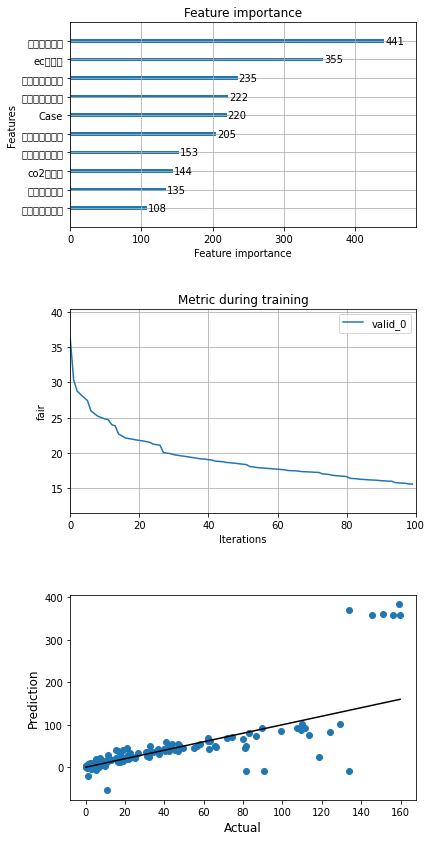

Features Importance Split & Gain...
    feature  split       gain
2   내부온도관측치    205  25.549958
7   시간당백색광량    153  16.516389
8   시간당적색광량    235  14.251440
5     ec관측치    355  14.075436
6    시간당분무량    441  12.134507
4    co2관측치    144   4.840277
1      Case    220   4.073667
3   내부습도관측치    222   3.790530
10   시간당총광량    135   2.319647
0       DAT    100   1.816200
9   시간당청색광량    108   0.631949
MAE: 97976792787120869959711763013940056230786912443786017878172788396093296647394054774207599994449220073662307924660525251504972837417674317669935021805886857080209408.000, MSE:    inf, RMSE:    inf


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [ ]:
import matplotlib.pyplot as plt
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


#max_bin = tuning_max_bin(train_x,train_y)
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train(train_x,train_y)

params = {'max_bin':2047, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [ ]:
#max_bin = tuning_max_bin()
max_bin = 2047
#train_x, train_y = load_train()
train_x = save_train
test_x = svae_test
RepNo = 5                                                                     # 품목 갯수


pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

predict['predicted_weight_g'] = pred_Y

test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = predict['predicted_weight_g'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.586217
1     2            1.532667
2     3            1.765668
3     4           -1.122647
4     5           -2.388947
5     6            9.591258
6     7            8.377445
7     8           -0.517700
8     9            4.380762
9    10            3.093411
10   11            7.440768
11   12           10.406772
12   13           16.544636
13   14           14.480500
14   15           20.400469
15   16           22.901854
16   17           32.242781
17   18           28.422598
18   19           30.067738
19   20           30.950042
20   21           35.943370
21   22           38.823700
22   23           50.233863
23   24           48.358921
24   25           68.006250
25   26          108.588201
26   27          118.523057
27   28          119.169410 0
    DAT  predicted_weight_g
0     1            1.549166
1     2            1.783523
2     3            1.412974
3     4            5.673309
4     5            8.827950
5     6           

# pycaret

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 4.7 MB/s 
     |████████████████████████████████| 141 kB 74.6 MB/s 
     |████████████████████████████████| 1.7 MB 75.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 57.8 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 325 kB 77.4 MB/s 
     |████████████████████████████████| 5.0 MB 73.0 MB/s 
     |████████████████████████████████| 88 kB 8.2 MB/s 
     |████████████████████████████████| 1.3 MB 47.4 MB/s 
     |████████████████████████████████| 3.3 MB 68.7 MB/s 
     |████████████████████████████████| 662 kB 62.3 MB/s 
     |████████████████████████████████| 25.8 MB 2.7 MB/s 
     |████████████████████████████████| 2

In [ ]:
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.regression import *

In [ ]:
caret = pd.concat([train_x,train_y],axis = 1)

In [ ]:
setup(caret, target = 'predicted_weight_g', silent = True)

,Description,Value
0,session_id,7746
1,Target,predicted_weight_g
2,Original Data,"(784, 285)"
3,Missing Values,False
4,Numeric Features,283
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(548, 31)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='predicted_weight_g',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                nume...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

([('Setup Config',
                                  Description               Value
   0                               session_id                7746
   1                                   Target  predicted_weight_g
   2                            Original Data          (784, 285)
   3                           Missing Values               False
   4                         Numeric Features                 283
   5                     Categorical Features                   1
   6                         Ordinal Features               False
   7                High Cardinality Features               False
   8                  High Cardinality Method                None
   9                    Transformed Train Set           (548, 31)
   10                    Transformed Test Set           (236, 31)
   11                      Shuffle Train-Test                True
   12                     Stratify Train-Test               False
   13                          Fold Generator            

In [ ]:
bm = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.565100e+00,5.328580e+01,7.202300e+00,9.680000e-01,0.3292,4.519000e-01,0.272
lightgbm,Light Gradient Boosting Machine,5.823300e+00,9.381800e+01,9.474600e+00,9.447000e-01,0.3685,4.886000e-01,0.097
gbr,Gradient Boosting Regressor,6.260000e+00,1.014356e+02,9.924400e+00,9.392000e-01,0.3991,6.167000e-01,0.191
rf,Random Forest Regressor,6.474500e+00,1.137901e+02,1.048910e+01,9.319000e-01,0.3631,4.623000e-01,0.495
knn,K Neighbors Regressor,8.577900e+00,2.202895e+02,1.471960e+01,8.676000e-01,0.4804,6.620000e-01,0.012
dt,Decision Tree Regressor,8.093400e+00,2.351019e+02,1.501380e+01,8.525000e-01,0.4778,5.933000e-01,0.014
ridge,Ridge Regression,1.101680e+01,2.508789e+02,1.547670e+01,8.513000e-01,0.7194,1.968300e+00,0.009
ada,AdaBoost Regressor,1.414600e+01,2.768021e+02,1.656570e+01,8.337000e-01,1.0418,4.067700e+00,0.113
br,Bayesian Ridge,1.172380e+01,3.062195e+02,1.708320e+01,8.197000e-01,0.6888,1.785500e+00,0.010
lasso,Lasso Regression,1.205930e+01,3.245788e+02,1.751620e+01,8.111000e-01,0.7044,1.990800e+00,0.017


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7746, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
y_pred = predict_model(bm, test_x)
y_pred

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7746, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,31_LPF,32_LPF,33_LPF,34_LPF,35_LPF,36_LPF,37_LPF,38_LPF,39_LPF,Label
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,6469.737331,6.972322e+03,3.916129e+04,1.036421e+05,1.397112e+05,1.225509e+05,8.903842e+04,6.469020e+04,4.700018e+04,1.662318
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,6856.454482,6.558109e+04,2.400900e+05,4.551325e+05,5.895620e+05,5.383766e+05,3.911535e+05,2.841897e+05,2.064759e+05,1.529403
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,9246.161347,1.917226e+05,6.387474e+05,1.123137e+06,1.437333e+06,1.320997e+06,9.597603e+05,6.973067e+05,5.066230e+05,2.856333
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,15905.875253,4.103413e+05,1.277409e+06,2.135115e+06,2.708277e+06,2.498173e+06,1.815029e+06,1.318696e+06,9.580885e+05,2.572758
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,14794.867894,7.096587e+05,2.105054e+06,3.354163e+06,4.209168e+06,3.896160e+06,2.830726e+06,2.056643e+06,1.494238e+06,3.178167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,105610.676546,7.760310e+05,1.986799e+06,2.954791e+06,3.653617e+06,3.424182e+06,2.567298e+06,1.949212e+06,1.498654e+06,59.143284
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,114854.494499,9.299059e+05,2.505445e+06,3.857250e+06,4.796682e+06,4.482012e+06,3.344794e+06,2.523019e+06,1.924476e+06,81.166218
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,123701.780726,1.205483e+06,3.249090e+06,4.949608e+06,6.140159e+06,5.736036e+06,4.264829e+06,3.200408e+06,2.425570e+06,78.370912
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,131999.710591,1.490920e+06,4.031110e+06,6.112800e+06,7.574464e+06,7.073427e+06,5.245446e+06,3.921813e+06,2.958646e+06,86.360142


In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred['Label'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.662318
1     2            1.529403
2     3            2.856333
3     4            2.572758
4     5            3.178167
5     6            2.853431
6     7            4.846604
7     8            6.607011
8     9            8.506381
9    10            9.945400
10   11           11.547756
11   12           13.120465
12   13           16.518163
13   14           15.343259
14   15           25.658244
15   16           34.643139
16   17           42.051870
17   18           44.772611
18   19           53.782223
19   20           65.056130
20   21           73.961135
21   22           88.615942
22   23           96.992909
23   24           96.767346
24   25          103.679384
25   26          109.822115
26   27          113.116003
27   28          112.301899 0
    DAT  predicted_weight_g
0     1            1.734149
1     2            1.697654
2     3            2.508163
3     4            3.103280
4     5            3.110655
5     6           

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import warnings
import gc
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

In [ ]:
X

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대,측정될수분량2,측정될수분량1,측정될수분량3
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,2,0.0,0.0,0.0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.0


In [ ]:
model = ExtraTreesRegressor(bootstrap=True, oob_score=True, warm_start=True, random_state=42, verbose=0)
model.fit(train_x, train_y)

ExtraTreesRegressor(bootstrap=True, oob_score=True, random_state=42,
                    warm_start=True)

In [ ]:
y_pred = model.predict(test_x)
y_pred

array([ 1.32714924,  1.93063041,  2.01365082,  1.89413641,  3.2416398 ,
        3.15698936,  4.58434635,  4.92662477,  6.64715589,  7.77923821,
        9.80512835, 11.96496066, 13.77703143, 15.32071092, 19.8384653 ,
       23.49712074, 26.23955574, 30.67313113, 37.33788617, 46.952378  ,
       55.08185632, 64.08300188, 68.95325955, 76.25060528, 88.34643281,
       91.9709107 , 98.5088374 , 99.31401645,  1.40760467,  2.21692444,
        1.60364851,  1.75645825,  2.50749563,  2.86400858,  3.27127802,
        3.8186682 ,  4.06128306,  4.93710305,  5.4407149 ,  6.75046541,
        7.99179939,  9.551948  , 11.26212958, 12.5056303 , 15.61061986,
       18.92395359, 21.8450105 , 24.2389591 , 27.53960603, 31.13085967,
       38.77888674, 49.28925058, 56.54329542, 63.64382147, 65.93054391,
       65.51740521,  1.63014939,  1.74818322,  1.60619519,  1.73025097,
        1.99352729,  2.19580756,  2.69984947,  3.25685051,  3.29905524,
        4.11344004,  4.64879712,  5.40408465,  6.14330205,  7.40

In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28]
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.327149
1     2            1.930630
2     3            2.013651
3     4            1.894136
4     5            3.241640
5     6            3.156989
6     7            4.584346
7     8            4.926625
8     9            6.647156
9    10            7.779238
10   11            9.805128
11   12           11.964961
12   13           13.777031
13   14           15.320711
14   15           19.838465
15   16           23.497121
16   17           26.239556
17   18           30.673131
18   19           37.337886
19   20           46.952378
20   21           55.081856
21   22           64.083002
22   23           68.953260
23   24           76.250605
24   25           88.346433
25   26           91.970911
26   27           98.508837
27   28           99.314016 0
    DAT  predicted_weight_g
0     1            1.407605
1     2            2.216924
2     3            1.603649
3     4            1.756458
4     5            2.507496
5     6           

In [ ]:
maes = []
X = train[train.columns]
X.drop(columns=['predicted_weight_g'], inplace=True)
y = train['predicted_weight_g']

test = test[X.columns]

pred = np.zeros((test.shape[0]))
for i, idx in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.loc[idx[0]], y.loc[idx[0]]
    val_x, val_y = X.loc[idx[1]], y.loc[idx[1]]


    model = ExtraTreesRegressor(bootstrap=True, oob_score=True, warm_start=True, random_state=42, verbose=0)
    model.fit(tr_x, tr_y)
    
    val_pred = model.predict(val_x)
    mae = NMAE(val_y, val_pred)
    print(f"{i + 1} Fold MAE = {mae}")
    maes.append(mae)
    
    fold_pred = model.predict(test) / kf.n_splits
    pred += fold_pred

KeyError: ignored